In [1]:
import numpy as np
import os

dir_name = 'lotka_volterra'
file_stem = 'lotkavolterra'  # 저장 시 이렇게 저장되었음

def load_dataset(dir_name, file_stem=None):
    if file_stem is None:
        file_stem = dir_name.replace('_', '')  # 기본 룰 적용
    path = os.path.join('..', 'generated', dir_name, f'{file_stem}_dataset.npz')
    # Python 객체가 포함되어 있으므로 allow_pickle=True 필요
    return np.load(path, allow_pickle=True)

# 로드
data = load_dataset(dir_name, file_stem)

# 내용 확인
print(data.files)  # 예: ['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']

# 예시 접근
params = data['params']        # shape: (10000, param_dim)
x0 = data['x0']                # shape: (10000, state_dim)
samples = data['samples']      # shape: (10000, T, D)
time_steps = data['time_steps']  # shape: (10000, T)
sols = data['sols']            # 리스트 형태로 저장된 solve_ivp 객체들


['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']


In [2]:
import numpy as np
import pandas as pd
def convert_npz_to_dataframe(npz_data):
    """
    npz 데이터를 compact하게 sample 단위로 요약한 DataFrame을 생성합니다.
    각 sample은 하나의 row로, 
      - 관측 시계열 ('samples')와 time grid ('time_steps')는 list로,
      - 초기 조건 ('x0'), 파라미터 ('params'),
      - 그리고 ground truth trajectory (solve_ivp 객체의 y.T, 'sols')가 저장됩니다.
    """
    import pandas as pd
    
    params = npz_data['params']         # shape: (N, P)
    x0 = npz_data['x0']                 # shape: (N, D)
    samples = npz_data['samples']       # shape: (N, T, D)
    time_steps = npz_data['time_steps'] # shape: (N, T)
    sols = npz_data['sols']             # list of solve_ivp objects, 길이 N
    
    N, T, D = samples.shape
    records = []
    for i in range(N):
        # true trajectory는 각 solve_ivp 객체의 y.T (shape: (T_full, D))를 리스트로 변환
        try:
            true_traj = sols[i].y.T.tolist()  
        except Exception as e:
            true_traj = None
        
        row = {
            'sample_idx': i,
            'x0': list(x0[i]),
            'params': list(params[i]),
            'times': list(time_steps[i]),
            'true_trajectory': true_traj  # ground truth trajectory
        }
        # 각 상태 변수에 대한 관측 시계열 (noisy observations)
        for d in range(D):
            row[f'state_{d}'] = list(samples[i, :, d])
        records.append(row)
    
    df = pd.DataFrame(records)
    return df

In [3]:
df = convert_npz_to_dataframe(data)

df

,sample_idx,x0,params,times,true_trajectory,state_0,state_1
0,0,"[9.49816047538945, 5.901428612819832]","[1.092797576724562, 0.10394633936788146, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.49816047538945, 5.901428612819832], [9.984...","[9.81400303849093, 23.820310985254146, 38.1766...","[6.054915558650414, 3.9254945106096795, 15.330..."
1,1,"[8.798695128633439, 5.028468876827223]","[1.036965827544817, 0.08185801650879991, 0.065...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[8.798695128633439, 5.028468876827223], [9.38...","[8.678567390649677, 26.859757077121937, 57.173...","[4.970130126868568, 2.7361512889073656, 18.912..."
2,2,"[9.554709158757928, 4.542698063547792]","[1.1314950036607718, 0.09427013306774357, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.554709158757928, 4.542698063547792], [10.2...","[9.619525952636888, 28.957527795169433, 23.387...","[4.4656816074645285, 4.469653296971071, 28.371..."
3,3,"[11.548850970305306, 4.944429850323899]","[0.8478376983753207, 0.1085297914889198, 0.076...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.548850970305306, 4.944429850323899], [11....","[11.541685762483317, 22.448197486321202, 38.24...","[5.2573585814867005, 2.911255710608391, 8.8830..."
4,4,"[11.214688307596457, 4.3731401177720715]","[1.1570235993959912, 0.10157368967662603, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.214688307596457, 4.3731401177720715], [12...","[11.074277688820986, 33.87231650253858, 15.072...","[4.307607688452518, 4.835836669578541, 26.3914..."
...,...,...,...,...,...,...,...
9995,9995,"[9.06674222472362, 5.3645536793597985]","[0.9480434487307816, 0.08078143951745678, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.06674222472362, 5.3645536793597985], [9.56...","[9.060958052312612, 23.83030903981786, 39.8795...","[5.196456735516876, 2.5995442412260426, 19.755..."
9996,9996,"[10.686058521731491, 4.239487630890881]","[1.0278582369298326, 0.09260471597377619, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.686058521731491, 4.239487630890881], [11....","[10.811219441088685, 28.16398830048308, 22.769...","[4.462505947047643, 4.874626080613738, 24.3013..."
9997,9997,"[10.65100326033214, 5.273218015173407]","[0.838361935376518, 0.11046376636499679, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.65100326033214, 5.273218015173407], [10.9...","[10.61096153260883, 18.956532493649554, 32.991...","[5.4727168018515835, 3.663571098487103, 6.0885..."
9998,9998,"[11.919242342013689, 5.0723115827422385]","[1.0752165747222993, 0.08828518687956767, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.919242342013689, 5.0723115827422385], [12...","[11.653639391931149, 29.769390760639084, 19.65...","[5.072443068170984, 6.646510368944044, 25.6346..."


In [4]:
def split_dataframe(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    """
    각 sample이 row인 DataFrame을 train, validation, test set으로 분할합니다.
    이 DataFrame은 관측 시계열, 실제(ground truth) trajectory, 초기조건, 파라미터 등의 정보를 포함합니다.
    
    Args:
        df (pd.DataFrame): 전체 데이터셋 (각 row가 하나의 sample)
        train_ratio (float): 학습 데이터 비율
        val_ratio (float): 검증 데이터 비율
        test_ratio (float): 테스트 데이터 비율
        seed (int, optional): 랜덤 시드
        
    Returns:
        tuple: (train_df, val_df, test_df)
    """
    import pandas as pd
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "비율의 합은 1이어야 합니다"
    
    if seed is not None:
        df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
    
    n = len(df_shuffled)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)
    
    train_df = df_shuffled.iloc[:train_end].reset_index(drop=True)
    val_df = df_shuffled.iloc[train_end:val_end].reset_index(drop=True)
    test_df = df_shuffled.iloc[val_end:].reset_index(drop=True)
    
    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = split_dataframe(df, seed=42)

In [6]:
def extract_timeseries_and_params(df):
    """
    compact dataframe에서 (시계열, 파라미터) 쌍 리스트 추출
    Returns:
        List[Tuple[np.ndarray, np.ndarray]]
    """
    data = []
    for _, row in df.iterrows():
        # 하나의 시계열: 모든 state 차원을 하나로 concat → shape (T, D)
        states = np.stack([row[f'state_{d}'] for d in range(len(row['x0']))], axis=1)
        params = np.array(row['params'])  # shape: (param_dim,)
        data.append((states, params))
    return data

In [7]:
train_data = extract_timeseries_and_params(train_df)
val_data = extract_timeseries_and_params(val_df)
test_data = extract_timeseries_and_params(test_df)

In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeseriesParamDataset(Dataset):
    def __init__(self, data):
        """
        data: List of tuples (timeseries, params)
            - timeseries: numpy array of shape (T, D)
            - params: numpy array of shape (param_dim,)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        timeseries, params = self.data[idx]
        return {
            'timeseries': torch.tensor(timeseries, dtype=torch.float32),
            'params': torch.tensor(params, dtype=torch.float32)
        }


def create_dataloaders(train_data, val_data, test_data, batch_size=64, shuffle=True):
    train_dataset = TimeseriesParamDataset(train_data)
    val_dataset = TimeseriesParamDataset(val_data)
    test_dataset = TimeseriesParamDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [9]:
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

# 한 배치 예시 보기
for batch in train_loader:
    print(batch['timeseries'].shape)  # (B, T, D)
    print(batch['params'].shape)      # (B, param_dim)
    break


torch.Size([64, 8, 2])
torch.Size([64, 4])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # Neural ODE solver (pip install torchdiffeq)
from tqdm import tqdm

# -------------------------------
# 1. Utility 함수: time grid 생성
# -------------------------------
def get_time_grid(T, device, dt=1.0):
    # T: time steps, dt: time step size (여기서는 1.0 등)
    return torch.linspace(0, dt*(T-1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    # pred, target: (B, T, output_dim)
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. PINN Loss: Direct Field Matching Loss
#    Lotka–Volterra의 실제 식과 neural ODE의 vector field를 비교
# -------------------------------
def lotka_volterra_rhs(x, theta):
    """
    x: (B, 2) → [x, y]
    theta: (B, 4) → [alpha, beta, gamma, delta]
    
    Lotka-Volterra:
      dx/dt = alpha * x - beta * x * y
      dy/dt = -gamma * y + delta * x * y
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    alpha = theta[:, 0]
    beta  = theta[:, 1]
    gamma = theta[:, 2]
    delta = theta[:, 3]
    dx_dt = alpha * x1 - beta * x1 * x2
    dy_dt = -gamma * x2 + delta * x1 * x2
    return torch.stack([dx_dt, dy_dt], dim=1)  # (B, 2)

def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    """
    xy_hat: (B, T, 2), predicted trajectory from Neural ODE decoder
    theta_hat: (B, 4), estimated parameters from encoder
    odefunc: neural network f(x, theta) (vector field) from the Neural ODE decoder
    """
    B, T, D = xy_hat.shape
    # 각 시간 step마다 동일한 theta 사용: (B, T, 4)
    theta_expanded = theta_hat.unsqueeze(1).repeat(1, T, 1)
    # Flatten: (B*T, *)
    xy_hat_flat = xy_hat.reshape(-1, D)
    theta_flat  = theta_expanded.reshape(-1, theta_hat.shape[-1])
    # Neural ODE에서 사용하는 vector field f_ψ(x, θ)
    f_pred = odefunc(xy_hat_flat, theta_flat)      # (B*T, 2)
    # 진짜 Lotka–Volterra 식에 따른 RHS
    f_true = lotka_volterra_rhs(xy_hat_flat, theta_flat)  # (B*T, 2)
    loss = torch.mean((f_pred - f_true) ** 2)
    return loss

# -------------------------------
# 4. LVODEFunc: Neural ODE의 vector field (f_ψ)
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(LVODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 4, hidden_dim),  # 입력: state (2)와 parameter (4)
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)       # 출력: dx/dt (2)
        )
    
    def forward(self, x, theta):
        # x: (B,2), theta: (B,4)
        inp = torch.cat([x, theta], dim=1)  # (B, 6)
        return self.net(inp)

# -------------------------------
# 5. Neural ODE Decoder: ODE solver 기반 decoder
# -------------------------------
class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super(NeuralODEDecoder, self).__init__()
        self.odefunc = odefunc  # e.g., instance of LVODEFunc
    
    def forward(self, x0, theta, t_grid):
        # x0: (B, state_dim) 예: (B, 2)
        # theta: (B, parameter_dim) 예: (B, 4)
        B = x0.shape[0]
        def dynamics(t, x):
            # x는 flatten된 상태: (B * state_dim,)
            x = x.view(B, -1)  # (B, state_dim)
            dxdt = self.odefunc(x, theta)  # (B, state_dim)
            return dxdt.view(-1)
        x0_flat = x0.view(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='rk4')
        # x_t: (T, B * state_dim) → reshape to (T, B, state_dim)
        x_t = x_t.view(t_grid.shape[0], B, -1)
        # return: (B, T, state_dim)
        return x_t.permute(1, 0, 2)

# -------------------------------
# 6. Encoder: LSTM 기반 (기존 코드 사용)
# -------------------------------
class TimeseriesEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TimeseriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        # x: (B, T, input_dim)
        out, (hn, _) = self.lstm(x)
        z = self.fc(hn[-1])  # (B, latent_dim)
        return z

# -------------------------------
# 7. 전체 모델: Encoder + Neural ODE Decoder
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dim, latent_dim, ode_hidden_dim, num_layers=1):
        super(ODEParameterEstimationModel, self).__init__()
        self.encoder = TimeseriesEncoder(input_dim, encoder_hidden_dim, latent_dim, num_layers)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden_dim))
    
    def forward(self, x):
        # x: (B, T, input_dim) (입력 시계열, 예를 들어 노이즈가 있는 관측치)
        theta = self.encoder(x)       # (B, latent_dim) → 여기서 latent_dim은 parameter dimension (예: 4)
        x0 = x[:, 0, :]               # 첫 시점 값 (B, input_dim)
        T = x.shape[1]
        t_grid = get_time_grid(T, x.device, dt=1.0)  # dt는 상황에 맞게 조절
        x_hat = self.decoder(x0, theta, t_grid)  # (B, T, input_dim)
        return x_hat, theta

# -------------------------------
# 8. 학습 코드 (기존 학습 루프와 유사하게 구현)
# -------------------------------
def train_ode_model(
    model, 
    train_loader, 
    val_loader=None, 
    num_epochs=1000, 
    lr=1e-3, 
    lambda_pinn=0.5, 
    device='cuda', 
    early_stopping_patience=20
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        epoch_loss = 0.0
        
        for batch in train_loader:
            x = batch['timeseries'].to(device)  # (B, T, input_dim)
            optimizer.zero_grad()
            x_hat, theta_hat = model(x)  # x_hat: (B, T, output_dim); theta_hat: (B, latent_dim)
            rec_loss = reconstruction_loss(x_hat, x)
            
            # PINN loss: compare neural ODE vector field with Lotka–Volterra RHS
            physics_loss = pinn_loss_direct_field_match(x_hat, theta_hat, model.decoder.odefunc)
            
            loss = rec_loss + lambda_pinn * physics_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * x.size(0)
        
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    x_val = batch['timeseries'].to(device)
                    x_hat_val, theta_val = model(x_val)
                    loss_val = reconstruction_loss(x_hat_val, x_val)
                    val_loss += loss_val.item() * x_val.size(0)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            
            scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improve_epochs = 0
                best_model_state = model.state_dict()
            else:
                no_improve_epochs += 1
            
            if no_improve_epochs >= early_stopping_patience:
                print("Early stopping triggered.")
                break
        else:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")
    
    if val_loader is not None and 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        if val_loader is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)
    
    return model, train_losses, val_losses


Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epochs:   0%|          | 1/5000 [00:22<31:44:20, 22.86s/it]

Epoch 1: Train Loss = 149.0794, Val Loss = 126.0308


Epochs:   0%|          | 2/5000 [00:48<34:09:24, 24.60s/it]

Epoch 2: Train Loss = 126.7447, Val Loss = 122.7894


Epochs:   0%|          | 3/5000 [01:18<37:40:25, 27.14s/it]

Epoch 3: Train Loss = 125.3626, Val Loss = 122.7145


Epochs:   0%|          | 4/5000 [01:47<38:26:36, 27.70s/it]

Epoch 4: Train Loss = 125.4955, Val Loss = 122.7218


Epochs:   0%|          | 5/5000 [02:13<37:50:38, 27.27s/it]

Epoch 5: Train Loss = 125.0302, Val Loss = 122.6351


Epochs:   0%|          | 6/5000 [02:42<38:32:13, 27.78s/it]

Epoch 6: Train Loss = 125.0156, Val Loss = 122.5941


Epochs:   0%|          | 7/5000 [03:08<37:36:56, 27.12s/it]

Epoch 7: Train Loss = 124.7485, Val Loss = 122.4820


Epochs:   0%|          | 8/5000 [03:40<39:37:20, 28.57s/it]

Epoch 8: Train Loss = 124.6925, Val Loss = 122.3738


Epochs:   0%|          | 9/5000 [04:13<41:45:53, 30.12s/it]

Epoch 9: Train Loss = 124.5857, Val Loss = 122.3777


Epochs:   0%|          | 10/5000 [04:45<42:41:17, 30.80s/it]

Epoch 10: Train Loss = 124.7710, Val Loss = 122.3155


Epochs:   0%|          | 11/5000 [05:20<44:06:28, 31.83s/it]

Epoch 11: Train Loss = 124.4488, Val Loss = 122.1781


Epochs:   0%|          | 12/5000 [05:45<41:26:45, 29.91s/it]

Epoch 12: Train Loss = 124.6597, Val Loss = 122.3064


Epochs:   0%|          | 13/5000 [06:17<42:24:55, 30.62s/it]

Epoch 13: Train Loss = 124.6469, Val Loss = 122.1331


Epochs:   0%|          | 14/5000 [06:44<40:52:30, 29.51s/it]

Epoch 14: Train Loss = 124.6387, Val Loss = 122.0739


Epochs:   0%|          | 15/5000 [07:21<43:51:39, 31.67s/it]

Epoch 15: Train Loss = 124.4256, Val Loss = 122.0448


Epochs:   0%|          | 16/5000 [07:55<44:38:02, 32.24s/it]

Epoch 16: Train Loss = 124.3683, Val Loss = 122.0625


Epochs:   0%|          | 17/5000 [08:27<44:45:18, 32.33s/it]

Epoch 17: Train Loss = 124.3308, Val Loss = 122.0894


Epochs:   0%|          | 18/5000 [08:58<44:00:24, 31.80s/it]

Epoch 18: Train Loss = 124.2502, Val Loss = 121.9434


Epochs:   0%|          | 19/5000 [09:26<42:38:30, 30.82s/it]

Epoch 19: Train Loss = 124.2132, Val Loss = 122.1523


Epochs:   0%|          | 20/5000 [09:59<43:35:47, 31.52s/it]

Epoch 20: Train Loss = 123.9241, Val Loss = 121.8594


Epochs:   0%|          | 21/5000 [10:33<44:30:40, 32.18s/it]

Epoch 21: Train Loss = 122.9305, Val Loss = 121.4381


Epochs:   0%|          | 22/5000 [11:13<47:53:33, 34.64s/it]

Epoch 22: Train Loss = 122.7356, Val Loss = 121.6709


Epochs:   0%|          | 23/5000 [11:46<47:07:48, 34.09s/it]

Epoch 23: Train Loss = 122.2915, Val Loss = 120.5520


Epochs:   0%|          | 24/5000 [12:30<51:06:25, 36.97s/it]

Epoch 24: Train Loss = 120.7019, Val Loss = 119.8179


Epochs:   0%|          | 25/5000 [13:13<53:35:45, 38.78s/it]

Epoch 25: Train Loss = 119.9826, Val Loss = 119.0964


Epochs:   1%|          | 26/5000 [14:06<59:18:57, 42.93s/it]

Epoch 26: Train Loss = 119.3731, Val Loss = 118.1119


Epochs:   1%|          | 27/5000 [14:57<62:39:00, 45.35s/it]

Epoch 27: Train Loss = 118.5382, Val Loss = 117.1849


Epochs:   1%|          | 28/5000 [15:42<62:30:57, 45.27s/it]

Epoch 28: Train Loss = 117.4612, Val Loss = 116.2013


Epochs:   1%|          | 29/5000 [16:17<58:12:27, 42.15s/it]

Epoch 29: Train Loss = 116.6483, Val Loss = 115.3785


Epochs:   1%|          | 30/5000 [17:13<63:59:07, 46.35s/it]

Epoch 30: Train Loss = 116.0529, Val Loss = 114.4713


Epochs:   1%|          | 31/5000 [18:05<66:18:21, 48.04s/it]

Epoch 31: Train Loss = 115.4666, Val Loss = 113.8544


Epochs:   1%|          | 32/5000 [18:59<68:56:39, 49.96s/it]

Epoch 32: Train Loss = 114.8475, Val Loss = 113.3125


Epochs:   1%|          | 33/5000 [20:04<75:02:33, 54.39s/it]

Epoch 33: Train Loss = 114.2618, Val Loss = 112.6446


Epochs:   1%|          | 34/5000 [21:04<77:15:11, 56.00s/it]

Epoch 34: Train Loss = 114.1508, Val Loss = 112.1875


Epochs:   1%|          | 35/5000 [22:06<79:50:41, 57.89s/it]

Epoch 35: Train Loss = 113.8671, Val Loss = 111.9116


Epochs:   1%|          | 36/5000 [23:18<85:48:44, 62.23s/it]

Epoch 36: Train Loss = 113.3882, Val Loss = 111.4338


Epochs:   1%|          | 37/5000 [24:24<87:06:46, 63.19s/it]

Epoch 37: Train Loss = 112.5992, Val Loss = 111.3472


Epochs:   1%|          | 38/5000 [25:33<89:24:58, 64.87s/it]

Epoch 38: Train Loss = 111.9896, Val Loss = 110.0191


Epochs:   1%|          | 39/5000 [26:51<94:50:16, 68.82s/it]

Epoch 39: Train Loss = 114.1692, Val Loss = 111.0583


Epochs:   1%|          | 40/5000 [28:00<95:05:44, 69.02s/it]

Epoch 40: Train Loss = 111.3804, Val Loss = 109.3543


Epochs:   1%|          | 41/5000 [29:21<99:49:29, 72.47s/it]

Epoch 41: Train Loss = 110.9725, Val Loss = 108.8078


Epochs:   1%|          | 42/5000 [30:43<103:53:00, 75.43s/it]

Epoch 42: Train Loss = 110.0451, Val Loss = 108.1899


Epochs:   1%|          | 43/5000 [32:09<108:15:51, 78.63s/it]

Epoch 43: Train Loss = 109.9681, Val Loss = 107.6065


Epochs:   1%|          | 44/5000 [33:46<115:59:12, 84.25s/it]

Epoch 44: Train Loss = 109.5872, Val Loss = 107.5237


Epochs:   1%|          | 45/5000 [36:22<145:31:26, 105.73s/it]

Epoch 45: Train Loss = 109.7194, Val Loss = 107.0742


Epochs:   1%|          | 46/5000 [38:06<144:48:59, 105.24s/it]

Epoch 46: Train Loss = 108.8530, Val Loss = 106.9336


Epochs:   1%|          | 47/5000 [39:50<144:06:32, 104.74s/it]

Epoch 47: Train Loss = 108.9202, Val Loss = 106.4820


Epochs:   1%|          | 48/5000 [41:26<140:36:50, 102.22s/it]

Epoch 48: Train Loss = 110.3337, Val Loss = 107.4951


Epochs:   1%|          | 49/5000 [43:12<142:08:17, 103.35s/it]

Epoch 49: Train Loss = 108.1924, Val Loss = 106.0688


Epochs:   1%|          | 50/5000 [45:02<144:42:33, 105.24s/it]

Epoch 50: Train Loss = 107.5649, Val Loss = 105.7745


Epochs:   1%|          | 51/5000 [46:33<138:50:02, 100.99s/it]

Epoch 51: Train Loss = 107.3883, Val Loss = 105.5496


Epochs:   1%|          | 52/5000 [48:16<139:40:33, 101.62s/it]

Epoch 52: Train Loss = 107.8584, Val Loss = 105.3164


Epochs:   1%|          | 53/5000 [50:03<141:43:58, 103.14s/it]

Epoch 53: Train Loss = 107.4113, Val Loss = 104.9756


Epochs:   1%|          | 54/5000 [51:47<142:20:17, 103.60s/it]

Epoch 54: Train Loss = 108.4500, Val Loss = 105.0273


Epochs:   1%|          | 55/5000 [53:42<146:58:39, 107.00s/it]

Epoch 55: Train Loss = 106.3087, Val Loss = 104.6069


Epochs:   1%|          | 56/5000 [56:30<171:58:51, 125.23s/it]

Epoch 56: Train Loss = 106.4180, Val Loss = 104.2131


Epochs:   1%|          | 57/5000 [58:01<157:59:03, 115.06s/it]

Epoch 57: Train Loss = 106.5008, Val Loss = 104.1282


Epochs:   1%|          | 58/5000 [59:41<151:40:09, 110.48s/it]

Epoch 58: Train Loss = 107.3247, Val Loss = 104.1980


Epochs:   1%|          | 59/5000 [1:01:28<150:10:14, 109.41s/it]

Epoch 59: Train Loss = 105.4213, Val Loss = 103.8407


Epochs:   1%|          | 60/5000 [1:02:56<141:17:18, 102.96s/it]

Epoch 60: Train Loss = 106.0525, Val Loss = 103.8483


Epochs:   1%|          | 61/5000 [1:05:13<155:16:56, 113.18s/it]

Epoch 61: Train Loss = 105.5496, Val Loss = 103.4163


Epochs:   1%|          | 62/5000 [1:07:28<164:13:59, 119.73s/it]

Epoch 62: Train Loss = 105.3074, Val Loss = 103.2996


Epochs:   1%|▏         | 63/5000 [1:09:45<171:14:08, 124.86s/it]

Epoch 63: Train Loss = 105.5230, Val Loss = 103.2358


Epochs:   1%|▏         | 64/5000 [1:12:00<175:24:57, 127.94s/it]

Epoch 64: Train Loss = 105.7648, Val Loss = 102.9365


Epochs:   1%|▏         | 65/5000 [1:14:27<183:16:45, 133.70s/it]

Epoch 65: Train Loss = 104.3766, Val Loss = 102.7912


Epochs:   1%|▏         | 66/5000 [1:17:43<208:46:37, 152.33s/it]

Epoch 66: Train Loss = 106.4346, Val Loss = 102.8457


Epochs:   1%|▏         | 67/5000 [1:20:49<222:34:34, 162.43s/it]

Epoch 67: Train Loss = 104.1955, Val Loss = 102.6704


Epochs:   1%|▏         | 68/5000 [1:23:27<220:41:27, 161.09s/it]

Epoch 68: Train Loss = 104.8371, Val Loss = 102.5474


Epochs:   1%|▏         | 69/5000 [1:25:38<208:14:38, 152.03s/it]

Epoch 69: Train Loss = 104.6329, Val Loss = 102.3429


Epochs:   1%|▏         | 70/5000 [1:27:48<199:01:19, 145.33s/it]

Epoch 70: Train Loss = 104.1414, Val Loss = 102.2689


Epochs:   1%|▏         | 71/5000 [1:30:04<195:18:52, 142.65s/it]

Epoch 71: Train Loss = 104.0417, Val Loss = 102.1198


Epochs:   1%|▏         | 72/5000 [1:32:15<190:23:55, 139.09s/it]

Epoch 72: Train Loss = 104.6254, Val Loss = 102.1966


Epochs:   1%|▏         | 73/5000 [1:34:28<187:55:49, 137.31s/it]

Epoch 73: Train Loss = 103.5618, Val Loss = 102.0479


Epochs:   1%|▏         | 74/5000 [1:36:37<184:33:41, 134.88s/it]

Epoch 74: Train Loss = 104.7300, Val Loss = 101.9291


Epochs:   2%|▏         | 75/5000 [1:38:45<181:48:10, 132.89s/it]

Epoch 75: Train Loss = 103.6233, Val Loss = 101.6442


Epochs:   2%|▏         | 76/5000 [1:40:56<180:53:10, 132.25s/it]

Epoch 76: Train Loss = 103.5840, Val Loss = 101.8409


Epochs:   2%|▏         | 77/5000 [1:43:13<182:45:20, 133.64s/it]

Epoch 77: Train Loss = 103.6318, Val Loss = 101.4757


Epochs:   2%|▏         | 78/5000 [1:45:23<181:17:30, 132.60s/it]

Epoch 78: Train Loss = 104.6107, Val Loss = 102.3618


Epochs:   2%|▏         | 79/5000 [1:47:34<180:35:44, 132.12s/it]

Epoch 79: Train Loss = 102.8947, Val Loss = 101.2714


Epochs:   2%|▏         | 80/5000 [1:49:07<164:31:56, 120.39s/it]

Epoch 80: Train Loss = 103.9520, Val Loss = 101.7239


Epochs:   2%|▏         | 81/5000 [1:51:00<161:28:12, 118.17s/it]

Epoch 81: Train Loss = 103.2468, Val Loss = 101.1590


Epochs:   2%|▏         | 82/5000 [1:52:49<157:41:07, 115.43s/it]

Epoch 82: Train Loss = 102.8100, Val Loss = 100.9570


Epochs:   2%|▏         | 83/5000 [1:54:41<156:07:51, 114.31s/it]

Epoch 83: Train Loss = 102.6048, Val Loss = 100.8619


Epochs:   2%|▏         | 84/5000 [1:56:32<154:58:26, 113.49s/it]

Epoch 84: Train Loss = 102.6136, Val Loss = 100.8471


Epochs:   2%|▏         | 85/5000 [1:58:22<153:23:46, 112.36s/it]

Epoch 85: Train Loss = 104.9188, Val Loss = 101.2744


Epochs:   2%|▏         | 86/5000 [2:00:12<152:27:46, 111.69s/it]

Epoch 86: Train Loss = 102.1742, Val Loss = 100.7433


Epochs:   2%|▏         | 87/5000 [2:01:55<148:44:16, 108.99s/it]

Epoch 87: Train Loss = 102.1816, Val Loss = 100.9313


Epochs:   2%|▏         | 88/5000 [2:03:14<136:24:32, 99.97s/it] 

Epoch 88: Train Loss = 102.6329, Val Loss = 100.6264


Epochs:   2%|▏         | 89/5000 [2:04:49<134:33:33, 98.64s/it]

Epoch 89: Train Loss = 102.7001, Val Loss = 100.6797


Epochs:   2%|▏         | 90/5000 [2:06:28<134:18:28, 98.47s/it]

Epoch 90: Train Loss = 102.1048, Val Loss = 100.4426


Epochs:   2%|▏         | 91/5000 [2:08:04<133:18:40, 97.76s/it]

Epoch 91: Train Loss = 102.4575, Val Loss = 100.4557


Epochs:   2%|▏         | 92/5000 [2:09:41<132:57:23, 97.52s/it]

Epoch 92: Train Loss = 101.9690, Val Loss = 100.3125


Epochs:   2%|▏         | 93/5000 [2:11:25<135:43:30, 99.57s/it]

Epoch 93: Train Loss = 102.5739, Val Loss = 100.3183


Epochs:   2%|▏         | 94/5000 [2:13:17<140:58:17, 103.44s/it]

Epoch 94: Train Loss = 101.8107, Val Loss = 100.2431


Epochs:   2%|▏         | 95/5000 [2:15:04<142:23:09, 104.50s/it]

Epoch 95: Train Loss = 101.7714, Val Loss = 100.1407


Epochs:   2%|▏         | 96/5000 [2:16:50<142:57:57, 104.95s/it]

Epoch 96: Train Loss = 103.8994, Val Loss = 100.3289


Epochs:   2%|▏         | 97/5000 [2:18:31<141:11:26, 103.67s/it]

Epoch 97: Train Loss = 101.5402, Val Loss = 100.0019


Epochs:   2%|▏         | 98/5000 [2:20:40<151:23:49, 111.19s/it]

Epoch 98: Train Loss = 101.1366, Val Loss = 99.8917


Epochs:   2%|▏         | 99/5000 [2:22:37<153:50:00, 113.00s/it]

Epoch 99: Train Loss = 101.6660, Val Loss = 99.9142


Epochs:   2%|▏         | 100/5000 [2:24:44<159:41:29, 117.32s/it]

Epoch 100: Train Loss = 102.7548, Val Loss = 100.3805


Epochs:   2%|▏         | 101/5000 [2:26:50<163:07:05, 119.87s/it]

Epoch 101: Train Loss = 101.8570, Val Loss = 99.7660


Epochs:   2%|▏         | 102/5000 [2:28:58<166:06:25, 122.09s/it]

Epoch 102: Train Loss = 101.0813, Val Loss = 99.7682


Epochs:   2%|▏         | 103/5000 [2:31:04<168:02:45, 123.54s/it]

Epoch 103: Train Loss = 101.3714, Val Loss = 99.6914


Epochs:   2%|▏         | 104/5000 [2:33:04<166:21:58, 122.33s/it]

Epoch 104: Train Loss = 101.4791, Val Loss = 99.6746


Epochs:   2%|▏         | 105/5000 [2:35:11<168:09:43, 123.67s/it]

Epoch 105: Train Loss = 102.1802, Val Loss = 99.8369


Epochs:   2%|▏         | 106/5000 [2:37:11<166:48:57, 122.71s/it]

Epoch 106: Train Loss = 101.2113, Val Loss = 99.4068


Epochs:   2%|▏         | 107/5000 [2:38:49<156:47:57, 115.36s/it]

Epoch 107: Train Loss = 101.5712, Val Loss = 99.4878


Epochs:   2%|▏         | 108/5000 [2:40:43<155:51:43, 114.70s/it]

Epoch 108: Train Loss = 100.5377, Val Loss = 99.4881


Epochs:   2%|▏         | 109/5000 [2:42:32<153:46:29, 113.19s/it]

Epoch 109: Train Loss = 101.8867, Val Loss = 99.5659


Epochs:   2%|▏         | 110/5000 [2:44:25<153:40:46, 113.14s/it]

Epoch 110: Train Loss = 100.7480, Val Loss = 99.3012


Epochs:   2%|▏         | 111/5000 [2:46:16<152:41:48, 112.44s/it]

Epoch 111: Train Loss = 101.1913, Val Loss = 99.3763


Epochs:   2%|▏         | 112/5000 [2:48:09<152:39:26, 112.43s/it]

Epoch 112: Train Loss = 101.7690, Val Loss = 99.2101


Epochs:   2%|▏         | 113/5000 [2:50:01<152:50:19, 112.59s/it]

Epoch 113: Train Loss = 101.4596, Val Loss = 99.1827


Epochs:   2%|▏         | 114/5000 [2:51:55<153:15:07, 112.92s/it]

Epoch 114: Train Loss = 100.7163, Val Loss = 99.1482


Epochs:   2%|▏         | 115/5000 [2:53:47<152:41:24, 112.52s/it]

Epoch 115: Train Loss = 100.6167, Val Loss = 98.9428


Epochs:   2%|▏         | 116/5000 [2:56:03<162:27:31, 119.75s/it]

Epoch 116: Train Loss = 101.2847, Val Loss = 99.0244


Epochs:   2%|▏         | 117/5000 [2:58:22<170:07:20, 125.42s/it]

Epoch 117: Train Loss = 100.5145, Val Loss = 98.9786


Epochs:   2%|▏         | 118/5000 [3:00:40<175:14:26, 129.22s/it]

Epoch 118: Train Loss = 100.7390, Val Loss = 99.2138


Epochs:   2%|▏         | 119/5000 [3:02:57<178:20:54, 131.54s/it]

Epoch 119: Train Loss = 102.1156, Val Loss = 98.9586


Epochs:   2%|▏         | 120/5000 [3:04:46<169:17:09, 124.88s/it]

Epoch 120: Train Loss = 100.3731, Val Loss = 99.0642


Epochs:   2%|▏         | 121/5000 [3:06:50<168:35:36, 124.40s/it]

Epoch 121: Train Loss = 100.4515, Val Loss = 99.1697


Epochs:   2%|▏         | 122/5000 [3:08:50<166:59:04, 123.24s/it]

Epoch 122: Train Loss = 100.4992, Val Loss = 98.9040


Epochs:   2%|▏         | 123/5000 [3:10:52<166:15:41, 122.73s/it]

Epoch 123: Train Loss = 100.5201, Val Loss = 98.7529


Epochs:   2%|▏         | 124/5000 [3:12:51<164:58:53, 121.81s/it]

Epoch 124: Train Loss = 101.3461, Val Loss = 98.8436


Epochs:   2%|▎         | 125/5000 [3:14:51<164:01:58, 121.13s/it]

Epoch 125: Train Loss = 100.1067, Val Loss = 98.7477


Epochs:   3%|▎         | 126/5000 [3:16:52<163:52:20, 121.04s/it]

Epoch 126: Train Loss = 100.9559, Val Loss = 98.8505


Epochs:   3%|▎         | 127/5000 [3:18:52<163:26:52, 120.75s/it]

Epoch 127: Train Loss = 101.4162, Val Loss = 98.8143


Epochs:   3%|▎         | 128/5000 [3:20:54<163:49:42, 121.06s/it]

Epoch 128: Train Loss = 99.6654, Val Loss = 98.6863


Epochs:   3%|▎         | 129/5000 [3:22:35<155:54:15, 115.22s/it]

Epoch 129: Train Loss = 99.6163, Val Loss = 98.6932


Epochs:   3%|▎         | 130/5000 [3:24:32<156:22:38, 115.60s/it]

Epoch 130: Train Loss = 100.7290, Val Loss = 98.6081


Epochs:   3%|▎         | 131/5000 [3:26:25<155:19:40, 114.84s/it]

Epoch 131: Train Loss = 100.5339, Val Loss = 98.5890


Epochs:   3%|▎         | 132/5000 [3:28:23<156:49:44, 115.98s/it]

Epoch 132: Train Loss = 100.4403, Val Loss = 98.5942


Epochs:   3%|▎         | 133/5000 [3:30:19<156:49:17, 116.00s/it]

Epoch 133: Train Loss = 99.9664, Val Loss = 99.1412


Epochs:   3%|▎         | 134/5000 [3:32:16<157:01:23, 116.17s/it]

Epoch 134: Train Loss = 100.2181, Val Loss = 98.4406


Epochs:   3%|▎         | 135/5000 [3:34:13<157:17:43, 116.40s/it]

Epoch 135: Train Loss = 99.8041, Val Loss = 98.4693


Epochs:   3%|▎         | 136/5000 [3:36:09<157:10:56, 116.34s/it]

Epoch 136: Train Loss = 100.9940, Val Loss = 100.8248


Epochs:   3%|▎         | 137/5000 [3:38:05<157:08:59, 116.34s/it]

Epoch 137: Train Loss = 101.0920, Val Loss = 98.3370


Epochs:   3%|▎         | 138/5000 [3:40:04<158:01:32, 117.01s/it]

Epoch 138: Train Loss = 99.3444, Val Loss = 98.4906


Epochs:   3%|▎         | 139/5000 [3:42:02<158:20:23, 117.26s/it]

Epoch 139: Train Loss = 101.3209, Val Loss = 99.6367


Epochs:   3%|▎         | 140/5000 [3:43:58<158:01:31, 117.06s/it]

Epoch 140: Train Loss = 100.1555, Val Loss = 98.3011


Epochs:   3%|▎         | 141/5000 [3:46:03<161:03:40, 119.33s/it]

Epoch 141: Train Loss = 99.1162, Val Loss = 98.2594


Epochs:   3%|▎         | 142/5000 [3:48:03<161:15:45, 119.50s/it]

Epoch 142: Train Loss = 102.0234, Val Loss = 98.3419


Epochs:   3%|▎         | 143/5000 [3:50:12<165:00:00, 122.30s/it]

Epoch 143: Train Loss = 99.5343, Val Loss = 98.3407


Epochs:   3%|▎         | 144/5000 [3:52:28<170:38:27, 126.50s/it]

Epoch 144: Train Loss = 99.2195, Val Loss = 98.2472


Epochs:   3%|▎         | 145/5000 [3:54:38<172:02:09, 127.57s/it]

Epoch 145: Train Loss = 99.9229, Val Loss = 98.2887


Epochs:   3%|▎         | 146/5000 [3:56:39<169:10:07, 125.47s/it]

Epoch 146: Train Loss = 99.6593, Val Loss = 98.2100


Epochs:   3%|▎         | 147/5000 [3:58:29<163:05:03, 120.98s/it]

Epoch 147: Train Loss = 101.1909, Val Loss = 98.1784


Epochs:   3%|▎         | 148/5000 [4:00:23<160:00:51, 118.72s/it]

Epoch 148: Train Loss = 99.7476, Val Loss = 98.2713


Epochs:   3%|▎         | 149/5000 [4:02:31<163:56:35, 121.66s/it]

Epoch 149: Train Loss = 99.5552, Val Loss = 98.1320


Epochs:   3%|▎         | 150/5000 [4:04:37<165:34:00, 122.90s/it]

Epoch 150: Train Loss = 100.6799, Val Loss = 98.2186


Epochs:   3%|▎         | 151/5000 [4:06:44<167:16:01, 124.18s/it]

Epoch 151: Train Loss = 99.5317, Val Loss = 98.0551


Epochs:   3%|▎         | 152/5000 [4:08:52<168:39:03, 125.24s/it]

Epoch 152: Train Loss = 98.9212, Val Loss = 98.0382


Epochs:   3%|▎         | 153/5000 [4:11:01<170:10:56, 126.40s/it]

Epoch 153: Train Loss = 99.6582, Val Loss = 98.0364


Epochs:   3%|▎         | 154/5000 [4:13:08<170:20:51, 126.55s/it]

Epoch 154: Train Loss = 99.7890, Val Loss = 98.6170


Epochs:   3%|▎         | 155/5000 [4:15:15<170:30:02, 126.69s/it]

Epoch 155: Train Loss = 100.8851, Val Loss = 97.9684


Epochs:   3%|▎         | 156/5000 [4:17:09<165:15:48, 122.82s/it]

Epoch 156: Train Loss = 98.7189, Val Loss = 97.9779


Epochs:   3%|▎         | 157/5000 [4:19:22<169:23:21, 125.91s/it]

Epoch 157: Train Loss = 100.4902, Val Loss = 97.9096


Epochs:   3%|▎         | 158/5000 [4:21:30<170:23:02, 126.68s/it]

Epoch 158: Train Loss = 99.0202, Val Loss = 97.9930


Epochs:   3%|▎         | 159/5000 [4:23:41<171:55:56, 127.86s/it]

Epoch 159: Train Loss = 99.3129, Val Loss = 97.9494


Epochs:   3%|▎         | 160/5000 [4:25:49<172:06:58, 128.02s/it]

Epoch 160: Train Loss = 99.8201, Val Loss = 97.9748


Epochs:   3%|▎         | 161/5000 [4:28:02<174:07:36, 129.54s/it]

Epoch 161: Train Loss = 99.8666, Val Loss = 97.8145


Epochs:   3%|▎         | 162/5000 [4:30:06<171:51:13, 127.88s/it]

Epoch 162: Train Loss = 101.2973, Val Loss = 98.0839


Epochs:   3%|▎         | 163/5000 [4:32:11<170:21:31, 126.79s/it]

Epoch 163: Train Loss = 98.8415, Val Loss = 97.9184


Epochs:   3%|▎         | 164/5000 [4:34:40<179:20:05, 133.50s/it]

Epoch 164: Train Loss = 98.9908, Val Loss = 97.8467


Epochs:   3%|▎         | 165/5000 [4:37:02<182:42:43, 136.04s/it]

Epoch 165: Train Loss = 98.9827, Val Loss = 97.8131


Epochs:   3%|▎         | 166/5000 [4:39:20<183:39:28, 136.77s/it]

Epoch 166: Train Loss = 100.2565, Val Loss = 97.8371


Epochs:   3%|▎         | 167/5000 [4:41:44<186:34:58, 138.98s/it]

Epoch 167: Train Loss = 99.2624, Val Loss = 97.8267


Epochs:   3%|▎         | 168/5000 [4:44:07<188:09:04, 140.18s/it]

Epoch 168: Train Loss = 99.1368, Val Loss = 97.7383


Epochs:   3%|▎         | 169/5000 [4:46:27<187:54:15, 140.02s/it]

Epoch 169: Train Loss = 99.9636, Val Loss = 97.8559


Epochs:   3%|▎         | 170/5000 [4:48:45<187:08:36, 139.49s/it]

Epoch 170: Train Loss = 99.5725, Val Loss = 97.7449


Epochs:   3%|▎         | 171/5000 [4:51:08<188:32:52, 140.56s/it]

Epoch 171: Train Loss = 99.0799, Val Loss = 97.7843


Epochs:   3%|▎         | 172/5000 [4:53:29<188:22:30, 140.46s/it]

Epoch 172: Train Loss = 100.4974, Val Loss = 97.7331


Epochs:   3%|▎         | 173/5000 [4:55:20<176:44:35, 131.82s/it]

Epoch 173: Train Loss = 98.6580, Val Loss = 97.7137


Epochs:   3%|▎         | 174/5000 [4:57:28<175:06:59, 130.63s/it]

Epoch 174: Train Loss = 100.0708, Val Loss = 97.7155


Epochs:   4%|▎         | 175/5000 [4:59:36<174:09:28, 129.94s/it]

Epoch 175: Train Loss = 99.2238, Val Loss = 97.6552


Epochs:   4%|▎         | 176/5000 [5:01:45<173:35:59, 129.55s/it]

Epoch 176: Train Loss = 99.6407, Val Loss = 97.6227


Epochs:   4%|▎         | 177/5000 [5:03:54<173:09:45, 129.25s/it]

Epoch 177: Train Loss = 98.8958, Val Loss = 97.6848


Epochs:   4%|▎         | 178/5000 [5:06:02<172:41:12, 128.92s/it]

Epoch 178: Train Loss = 101.0784, Val Loss = 97.9651


Epochs:   4%|▎         | 179/5000 [5:08:11<172:36:39, 128.89s/it]

Epoch 179: Train Loss = 99.1550, Val Loss = 97.6088


Epochs:   4%|▎         | 180/5000 [5:10:19<172:11:42, 128.61s/it]

Epoch 180: Train Loss = 98.5378, Val Loss = 97.6087


Epochs:   4%|▎         | 181/5000 [5:12:09<164:57:14, 123.23s/it]

Epoch 181: Train Loss = 98.6462, Val Loss = 97.5863


Epochs:   4%|▎         | 182/5000 [5:14:42<176:52:52, 132.17s/it]

Epoch 182: Train Loss = 99.3930, Val Loss = 97.6084


Epochs:   4%|▎         | 183/5000 [5:17:16<185:29:00, 138.62s/it]

Epoch 183: Train Loss = 98.9863, Val Loss = 97.6789


Epochs:   4%|▎         | 184/5000 [5:19:46<189:54:43, 141.96s/it]

Epoch 184: Train Loss = 99.1065, Val Loss = 97.5916


Epochs:   4%|▎         | 185/5000 [5:21:38<178:08:02, 133.18s/it]

Epoch 185: Train Loss = 98.8054, Val Loss = 97.6727


Epochs:   4%|▎         | 186/5000 [5:23:29<169:10:24, 126.51s/it]

Epoch 186: Train Loss = 99.5997, Val Loss = 98.0515


Epochs:   4%|▎         | 187/5000 [5:25:26<165:04:54, 123.48s/it]

Epoch 187: Train Loss = 100.1354, Val Loss = 97.5486


Epochs:   4%|▍         | 188/5000 [5:27:22<162:17:20, 121.41s/it]

Epoch 188: Train Loss = 99.0789, Val Loss = 97.5660


Epochs:   4%|▍         | 189/5000 [5:29:21<161:00:55, 120.49s/it]

Epoch 189: Train Loss = 99.0603, Val Loss = 97.5626


Epochs:   4%|▍         | 190/5000 [5:31:21<160:55:12, 120.44s/it]

Epoch 190: Train Loss = 98.8184, Val Loss = 97.4081


Epochs:   4%|▍         | 191/5000 [5:33:20<160:10:29, 119.91s/it]

Epoch 191: Train Loss = 98.5219, Val Loss = 97.4601


Epochs:   4%|▍         | 192/5000 [5:35:20<160:25:56, 120.12s/it]

Epoch 192: Train Loss = 99.7073, Val Loss = 97.5224


Epochs:   4%|▍         | 193/5000 [5:37:17<159:11:17, 119.22s/it]

Epoch 193: Train Loss = 99.4739, Val Loss = 97.3934


Epochs:   4%|▍         | 194/5000 [5:39:16<159:05:27, 119.17s/it]

Epoch 194: Train Loss = 98.4114, Val Loss = 97.4881


Epochs:   4%|▍         | 195/5000 [5:40:54<150:33:07, 112.80s/it]

Epoch 195: Train Loss = 99.7022, Val Loss = 97.6499


Epochs:   4%|▍         | 196/5000 [5:43:39<171:15:29, 128.34s/it]

Epoch 196: Train Loss = 99.0519, Val Loss = 97.4719


Epochs:   4%|▍         | 197/5000 [5:46:24<185:48:34, 139.27s/it]

Epoch 197: Train Loss = 98.6425, Val Loss = 97.4061


Epochs:   4%|▍         | 198/5000 [5:49:09<196:20:03, 147.19s/it]

Epoch 198: Train Loss = 98.7326, Val Loss = 97.7404


Epochs:   4%|▍         | 199/5000 [5:51:56<203:51:57, 152.87s/it]

Epoch 199: Train Loss = 102.4778, Val Loss = 97.4659


Epochs:   4%|▍         | 200/5000 [5:54:43<209:45:12, 157.32s/it]

Epoch 200: Train Loss = 98.2165, Val Loss = 97.4187


Epochs:   4%|▍         | 201/5000 [5:57:31<213:58:49, 160.52s/it]

Epoch 201: Train Loss = 97.9193, Val Loss = 97.3457


Epochs:   4%|▍         | 202/5000 [6:00:18<216:18:31, 162.30s/it]

Epoch 202: Train Loss = 99.5421, Val Loss = 97.5813


Epochs:   4%|▍         | 203/5000 [6:03:05<218:21:43, 163.87s/it]

Epoch 203: Train Loss = 98.6306, Val Loss = 97.2642


Epochs:   4%|▍         | 204/5000 [6:05:54<220:10:21, 165.27s/it]

Epoch 204: Train Loss = 98.4621, Val Loss = 97.2872


Epochs:   4%|▍         | 205/5000 [6:08:44<222:01:33, 166.69s/it]

Epoch 205: Train Loss = 98.3946, Val Loss = 97.4201


Epochs:   4%|▍         | 206/5000 [6:11:31<222:04:00, 166.76s/it]

Epoch 206: Train Loss = 100.6716, Val Loss = 97.2923


Epochs:   4%|▍         | 207/5000 [6:14:22<223:43:27, 168.04s/it]

Epoch 207: Train Loss = 98.5264, Val Loss = 97.2677


Epochs:   4%|▍         | 208/5000 [6:17:11<224:08:29, 168.39s/it]

Epoch 208: Train Loss = 99.2916, Val Loss = 97.3010


Epochs:   4%|▍         | 209/5000 [6:20:02<225:18:21, 169.30s/it]

Epoch 209: Train Loss = 98.8318, Val Loss = 97.4106


Epochs:   4%|▍         | 210/5000 [6:22:53<225:42:37, 169.64s/it]

Epoch 210: Train Loss = 98.4169, Val Loss = 97.2195


Epochs:   4%|▍         | 211/5000 [6:24:52<205:32:13, 154.51s/it]

Epoch 211: Train Loss = 98.1261, Val Loss = 97.2785


Epochs:   4%|▍         | 212/5000 [6:27:00<194:46:32, 146.45s/it]

Epoch 212: Train Loss = 100.6330, Val Loss = 97.2591


Epochs:   4%|▍         | 213/5000 [6:29:05<186:17:54, 140.10s/it]

Epoch 213: Train Loss = 98.1548, Val Loss = 97.2158


Epochs:   4%|▍         | 214/5000 [6:31:14<181:49:46, 136.77s/it]

Epoch 214: Train Loss = 98.9278, Val Loss = 97.2311


Epochs:   4%|▍         | 215/5000 [6:33:23<178:48:50, 134.53s/it]

Epoch 215: Train Loss = 99.1770, Val Loss = 97.2689


Epochs:   4%|▍         | 216/5000 [6:35:28<174:48:25, 131.54s/it]

Epoch 216: Train Loss = 99.0790, Val Loss = 97.1953


Epochs:   4%|▍         | 217/5000 [6:37:35<173:04:49, 130.27s/it]

Epoch 217: Train Loss = 98.8115, Val Loss = 97.2942


Epochs:   4%|▍         | 218/5000 [6:38:57<153:58:39, 115.92s/it]

Epoch 218: Train Loss = 99.3364, Val Loss = 97.1064


Epochs:   4%|▍         | 219/5000 [6:39:37<123:42:00, 93.14s/it] 

Epoch 219: Train Loss = 98.1946, Val Loss = 97.1812


Epochs:   4%|▍         | 220/5000 [6:40:18<102:33:36, 77.24s/it]

Epoch 220: Train Loss = 98.1813, Val Loss = 97.0183


Epochs:   4%|▍         | 221/5000 [6:40:57<87:31:19, 65.93s/it] 

Epoch 221: Train Loss = 98.4474, Val Loss = 97.1724


Epochs:   4%|▍         | 222/5000 [6:41:37<77:15:22, 58.21s/it]

Epoch 222: Train Loss = 100.5898, Val Loss = 97.3755


Epochs:   4%|▍         | 223/5000 [6:42:17<69:50:37, 52.64s/it]

Epoch 223: Train Loss = 98.1727, Val Loss = 97.1113


Epochs:   4%|▍         | 224/5000 [6:42:57<64:59:50, 48.99s/it]

Epoch 224: Train Loss = 98.6950, Val Loss = 97.1098


Epochs:   4%|▍         | 225/5000 [6:43:38<61:36:49, 46.45s/it]

Epoch 225: Train Loss = 97.8689, Val Loss = 97.0849


Epochs:   5%|▍         | 226/5000 [6:44:17<58:46:58, 44.33s/it]

Epoch 226: Train Loss = 99.3534, Val Loss = 97.1781


Epochs:   5%|▍         | 227/5000 [6:44:58<57:06:39, 43.08s/it]

Epoch 227: Train Loss = 98.6259, Val Loss = 97.0756


Epochs:   5%|▍         | 228/5000 [6:45:38<56:00:42, 42.26s/it]

Epoch 228: Train Loss = 99.6468, Val Loss = 97.5697


Epochs:   5%|▍         | 229/5000 [6:46:18<55:13:07, 41.67s/it]

Epoch 229: Train Loss = 99.2115, Val Loss = 97.0538


Epochs:   5%|▍         | 230/5000 [6:46:58<54:32:30, 41.16s/it]

Epoch 230: Train Loss = 98.1852, Val Loss = 97.2130


Epochs:   5%|▍         | 231/5000 [6:47:38<54:07:19, 40.86s/it]

Epoch 00231: reducing learning rate of group 0 to 5.0000e-03.
Epoch 231: Train Loss = 98.1576, Val Loss = 97.0667


Epochs:   5%|▍         | 232/5000 [6:48:18<53:47:19, 40.61s/it]

Epoch 232: Train Loss = 97.3651, Val Loss = 97.0054


Epochs:   5%|▍         | 233/5000 [6:48:58<53:33:01, 40.44s/it]

Epoch 233: Train Loss = 97.3416, Val Loss = 97.0523


Epochs:   5%|▍         | 234/5000 [6:49:39<53:28:24, 40.39s/it]

Epoch 234: Train Loss = 97.3482, Val Loss = 97.0308


Epochs:   5%|▍         | 235/5000 [6:50:19<53:31:35, 40.44s/it]

Epoch 235: Train Loss = 97.3425, Val Loss = 97.0169


Epochs:   5%|▍         | 236/5000 [6:50:59<53:26:50, 40.39s/it]

Epoch 236: Train Loss = 97.3273, Val Loss = 97.0046


Epochs:   5%|▍         | 237/5000 [6:51:40<53:31:44, 40.46s/it]

Epoch 237: Train Loss = 97.3534, Val Loss = 97.0253


Epochs:   5%|▍         | 238/5000 [6:52:21<53:34:11, 40.50s/it]

Epoch 238: Train Loss = 97.3196, Val Loss = 97.0272


Epochs:   5%|▍         | 239/5000 [6:53:01<53:30:07, 40.46s/it]

Epoch 239: Train Loss = 97.3417, Val Loss = 96.9663


Epochs:   5%|▍         | 240/5000 [6:53:42<53:37:45, 40.56s/it]

Epoch 240: Train Loss = 97.3131, Val Loss = 96.9284


Epochs:   5%|▍         | 241/5000 [6:54:23<53:44:41, 40.66s/it]

Epoch 241: Train Loss = 97.3078, Val Loss = 96.9633


Epochs:   5%|▍         | 242/5000 [6:55:04<53:51:34, 40.75s/it]

Epoch 242: Train Loss = 97.3860, Val Loss = 96.9600


Epochs:   5%|▍         | 243/5000 [6:55:45<54:00:45, 40.88s/it]

Epoch 243: Train Loss = 97.4678, Val Loss = 96.9408


Epochs:   5%|▍         | 244/5000 [6:56:25<53:52:34, 40.78s/it]

Epoch 244: Train Loss = 97.4696, Val Loss = 96.9001


Epochs:   5%|▍         | 245/5000 [6:57:06<53:42:38, 40.66s/it]

Epoch 245: Train Loss = 97.3997, Val Loss = 96.9160


Epochs:   5%|▍         | 246/5000 [6:57:46<53:41:09, 40.65s/it]

Epoch 246: Train Loss = 97.4532, Val Loss = 96.9170


Epochs:   5%|▍         | 247/5000 [6:58:27<53:41:45, 40.67s/it]

Epoch 247: Train Loss = 97.5783, Val Loss = 96.9342


Epochs:   5%|▍         | 248/5000 [6:59:08<53:54:53, 40.84s/it]

Epoch 248: Train Loss = 97.4203, Val Loss = 96.9610


Epochs:   5%|▍         | 249/5000 [6:59:50<54:05:57, 40.99s/it]

Epoch 249: Train Loss = 98.0753, Val Loss = 96.9383


Epochs:   5%|▌         | 250/5000 [7:00:31<54:03:28, 40.97s/it]

Epoch 250: Train Loss = 97.3886, Val Loss = 96.8496


Epochs:   5%|▌         | 251/5000 [7:01:12<54:03:37, 40.98s/it]

Epoch 251: Train Loss = 97.2718, Val Loss = 96.8831


Epochs:   5%|▌         | 252/5000 [7:01:52<53:57:52, 40.92s/it]

Epoch 252: Train Loss = 97.3432, Val Loss = 96.8330


Epochs:   5%|▌         | 253/5000 [7:02:34<54:03:00, 40.99s/it]

Epoch 253: Train Loss = 97.5564, Val Loss = 96.8915


Epochs:   5%|▌         | 254/5000 [7:03:15<54:00:42, 40.97s/it]

Epoch 254: Train Loss = 97.2847, Val Loss = 96.8487


Epochs:   5%|▌         | 255/5000 [7:03:55<53:57:27, 40.94s/it]

Epoch 255: Train Loss = 97.3706, Val Loss = 96.8442


Epochs:   5%|▌         | 256/5000 [7:04:36<54:00:50, 40.99s/it]

Epoch 256: Train Loss = 97.3544, Val Loss = 96.8314


Epochs:   5%|▌         | 257/5000 [7:05:18<54:11:36, 41.13s/it]

Epoch 257: Train Loss = 97.8338, Val Loss = 96.8708


Epochs:   5%|▌         | 258/5000 [7:05:59<54:17:43, 41.22s/it]

Epoch 258: Train Loss = 97.2452, Val Loss = 96.7898


Epochs:   5%|▌         | 259/5000 [7:06:41<54:16:28, 41.21s/it]

Epoch 259: Train Loss = 97.2193, Val Loss = 96.8237


Epochs:   5%|▌         | 260/5000 [7:07:21<54:03:37, 41.06s/it]

Epoch 260: Train Loss = 97.5826, Val Loss = 96.8254


Epochs:   5%|▌         | 261/5000 [7:08:02<53:57:46, 40.99s/it]

Epoch 261: Train Loss = 97.4225, Val Loss = 96.7956


Epochs:   5%|▌         | 262/5000 [7:08:43<53:46:43, 40.86s/it]

Epoch 262: Train Loss = 97.2123, Val Loss = 96.7684


Epochs:   5%|▌         | 263/5000 [7:09:24<54:04:04, 41.09s/it]

Epoch 263: Train Loss = 97.4123, Val Loss = 96.7728


Epochs:   5%|▌         | 264/5000 [7:10:06<54:09:22, 41.17s/it]

Epoch 264: Train Loss = 97.2472, Val Loss = 96.6896


Epochs:   5%|▌         | 265/5000 [7:10:46<53:58:00, 41.03s/it]

Epoch 265: Train Loss = 98.5427, Val Loss = 96.7909


Epochs:   5%|▌         | 266/5000 [7:11:28<54:03:23, 41.11s/it]

Epoch 266: Train Loss = 97.1971, Val Loss = 96.7763


Epochs:   5%|▌         | 267/5000 [7:12:09<54:13:33, 41.25s/it]

Epoch 267: Train Loss = 97.1352, Val Loss = 96.7462


Epochs:   5%|▌         | 268/5000 [7:12:51<54:14:17, 41.26s/it]

Epoch 268: Train Loss = 97.0898, Val Loss = 96.7477


Epochs:   5%|▌         | 269/5000 [7:13:32<54:23:42, 41.39s/it]

Epoch 269: Train Loss = 97.3147, Val Loss = 96.6629


Epochs:   5%|▌         | 270/5000 [7:14:14<54:22:30, 41.38s/it]

Epoch 270: Train Loss = 97.1473, Val Loss = 96.7195


Epochs:   5%|▌         | 271/5000 [7:14:55<54:16:39, 41.32s/it]

Epoch 271: Train Loss = 97.5241, Val Loss = 96.7415


Epochs:   5%|▌         | 272/5000 [7:15:36<54:11:43, 41.27s/it]

Epoch 272: Train Loss = 97.4929, Val Loss = 96.6710


Epochs:   5%|▌         | 273/5000 [7:16:18<54:20:55, 41.39s/it]

Epoch 273: Train Loss = 97.3123, Val Loss = 96.7081


Epochs:   5%|▌         | 274/5000 [7:16:59<54:27:35, 41.48s/it]

Epoch 274: Train Loss = 97.1010, Val Loss = 96.6887


Epochs:   6%|▌         | 275/5000 [7:17:41<54:22:25, 41.43s/it]

Epoch 275: Train Loss = 97.4791, Val Loss = 96.7370


Epochs:   6%|▌         | 276/5000 [7:18:22<54:31:07, 41.55s/it]

Epoch 276: Train Loss = 97.3052, Val Loss = 96.6846


Epochs:   6%|▌         | 277/5000 [7:19:04<54:25:23, 41.48s/it]

Epoch 277: Train Loss = 97.0980, Val Loss = 96.6718


Epochs:   6%|▌         | 278/5000 [7:19:45<54:19:06, 41.41s/it]

Epoch 278: Train Loss = 97.4133, Val Loss = 96.6788


Epochs:   6%|▌         | 279/5000 [7:20:27<54:25:00, 41.50s/it]

Epoch 279: Train Loss = 97.0818, Val Loss = 96.6390


Epochs:   6%|▌         | 280/5000 [7:21:09<54:41:54, 41.72s/it]

Epoch 280: Train Loss = 97.1655, Val Loss = 96.6352


Epochs:   6%|▌         | 281/5000 [7:21:51<54:50:33, 41.84s/it]

Epoch 281: Train Loss = 97.5729, Val Loss = 96.6437


Epochs:   6%|▌         | 282/5000 [7:22:33<54:45:15, 41.78s/it]

Epoch 282: Train Loss = 97.2643, Val Loss = 96.6917


Epochs:   6%|▌         | 283/5000 [7:23:14<54:41:57, 41.75s/it]

Epoch 283: Train Loss = 97.2820, Val Loss = 96.6210


Epochs:   6%|▌         | 284/5000 [7:23:56<54:46:57, 41.82s/it]

Epoch 284: Train Loss = 97.0714, Val Loss = 96.6107


Epochs:   6%|▌         | 285/5000 [7:24:38<54:47:29, 41.83s/it]

Epoch 285: Train Loss = 97.0962, Val Loss = 96.5778


Epochs:   6%|▌         | 286/5000 [7:25:20<54:53:15, 41.92s/it]

Epoch 286: Train Loss = 97.2781, Val Loss = 96.6150


Epochs:   6%|▌         | 287/5000 [7:26:03<55:02:39, 42.05s/it]

Epoch 287: Train Loss = 97.1088, Val Loss = 96.6348


Epochs:   6%|▌         | 288/5000 [7:26:45<55:06:58, 42.11s/it]

Epoch 288: Train Loss = 97.3123, Val Loss = 96.5820


Epochs:   6%|▌         | 289/5000 [7:27:27<55:11:06, 42.17s/it]

Epoch 289: Train Loss = 97.2013, Val Loss = 96.5654


Epochs:   6%|▌         | 290/5000 [7:28:09<55:10:52, 42.18s/it]

Epoch 290: Train Loss = 97.0582, Val Loss = 96.5952


Epochs:   6%|▌         | 291/5000 [7:28:51<54:47:12, 41.88s/it]

Epoch 291: Train Loss = 97.3335, Val Loss = 96.5433


Epochs:   6%|▌         | 292/5000 [7:29:32<54:38:28, 41.78s/it]

Epoch 292: Train Loss = 97.1901, Val Loss = 96.5395


Epochs:   6%|▌         | 293/5000 [7:30:14<54:42:07, 41.84s/it]

Epoch 293: Train Loss = 96.9640, Val Loss = 96.5357


Epochs:   6%|▌         | 294/5000 [7:30:56<54:50:30, 41.95s/it]

Epoch 294: Train Loss = 97.0249, Val Loss = 96.5105


Epochs:   6%|▌         | 295/5000 [7:31:38<54:39:32, 41.82s/it]

Epoch 295: Train Loss = 97.3342, Val Loss = 96.5644


Epochs:   6%|▌         | 296/5000 [7:32:19<54:33:09, 41.75s/it]

Epoch 296: Train Loss = 97.2330, Val Loss = 96.5349


Epochs:   6%|▌         | 297/5000 [7:33:02<54:40:12, 41.85s/it]

Epoch 297: Train Loss = 96.8415, Val Loss = 96.5134


Epochs:   6%|▌         | 298/5000 [7:33:44<54:48:00, 41.96s/it]

Epoch 298: Train Loss = 97.1130, Val Loss = 96.5119


Epochs:   6%|▌         | 299/5000 [7:34:26<54:48:49, 41.98s/it]

Epoch 299: Train Loss = 97.1726, Val Loss = 96.5206


Epochs:   6%|▌         | 300/5000 [7:35:08<54:54:12, 42.05s/it]

Epoch 300: Train Loss = 97.2977, Val Loss = 96.4964


Epochs:   6%|▌         | 301/5000 [7:35:50<55:02:47, 42.17s/it]

Epoch 301: Train Loss = 96.8846, Val Loss = 96.4719


Epochs:   6%|▌         | 302/5000 [7:36:33<55:10:12, 42.28s/it]

Epoch 302: Train Loss = 97.1345, Val Loss = 96.5425


Epochs:   6%|▌         | 303/5000 [7:37:15<55:09:43, 42.28s/it]

Epoch 303: Train Loss = 97.0672, Val Loss = 96.4647


Epochs:   6%|▌         | 304/5000 [7:37:57<55:00:14, 42.17s/it]

Epoch 304: Train Loss = 96.9086, Val Loss = 96.4540


Epochs:   6%|▌         | 305/5000 [7:38:40<55:11:19, 42.32s/it]

Epoch 305: Train Loss = 97.0110, Val Loss = 96.5124


Epochs:   6%|▌         | 306/5000 [7:39:23<55:21:39, 42.46s/it]

Epoch 306: Train Loss = 97.2494, Val Loss = 96.4291


Epochs:   6%|▌         | 307/5000 [7:40:05<55:20:41, 42.46s/it]

Epoch 307: Train Loss = 97.0331, Val Loss = 96.4176


Epochs:   6%|▌         | 308/5000 [7:40:47<55:07:00, 42.29s/it]

Epoch 308: Train Loss = 96.9342, Val Loss = 96.4021


Epochs:   6%|▌         | 309/5000 [7:41:29<55:00:22, 42.21s/it]

Epoch 309: Train Loss = 97.0140, Val Loss = 96.4489


Epochs:   6%|▌         | 310/5000 [7:42:11<55:03:59, 42.27s/it]

Epoch 310: Train Loss = 97.2910, Val Loss = 96.4289


Epochs:   6%|▌         | 311/5000 [7:42:54<55:12:28, 42.39s/it]

Epoch 311: Train Loss = 96.8433, Val Loss = 96.4031


Epochs:   6%|▌         | 312/5000 [7:43:37<55:21:22, 42.51s/it]

Epoch 312: Train Loss = 97.0633, Val Loss = 96.3495


Epochs:   6%|▋         | 313/5000 [7:44:19<55:11:23, 42.39s/it]

Epoch 313: Train Loss = 96.7669, Val Loss = 96.4149


Epochs:   6%|▋         | 314/5000 [7:45:01<55:00:34, 42.26s/it]

Epoch 314: Train Loss = 96.9677, Val Loss = 96.3933


Epochs:   6%|▋         | 315/5000 [7:45:43<54:57:49, 42.23s/it]

Epoch 315: Train Loss = 96.9769, Val Loss = 96.3641


Epochs:   6%|▋         | 316/5000 [7:46:25<54:51:01, 42.16s/it]

Epoch 316: Train Loss = 96.9959, Val Loss = 96.3637


Epochs:   6%|▋         | 317/5000 [7:47:07<54:44:39, 42.08s/it]

Epoch 317: Train Loss = 96.8729, Val Loss = 96.3610


Epochs:   6%|▋         | 318/5000 [7:47:49<54:46:32, 42.12s/it]

Epoch 318: Train Loss = 96.9919, Val Loss = 96.3551


Epochs:   6%|▋         | 319/5000 [7:48:31<54:30:11, 41.92s/it]

Epoch 319: Train Loss = 97.2142, Val Loss = 96.3193


Epochs:   6%|▋         | 320/5000 [7:49:13<54:36:56, 42.01s/it]

Epoch 320: Train Loss = 96.9402, Val Loss = 96.3277


Epochs:   6%|▋         | 321/5000 [7:49:55<54:47:38, 42.16s/it]

Epoch 321: Train Loss = 97.0901, Val Loss = 96.3649


Epochs:   6%|▋         | 322/5000 [7:50:37<54:37:11, 42.03s/it]

Epoch 322: Train Loss = 97.0245, Val Loss = 96.3211


Epochs:   6%|▋         | 323/5000 [7:51:19<54:42:58, 42.12s/it]

Epoch 323: Train Loss = 96.8102, Val Loss = 96.3144


Epochs:   6%|▋         | 324/5000 [7:52:02<54:49:38, 42.21s/it]

Epoch 324: Train Loss = 96.9177, Val Loss = 96.3375


Epochs:   6%|▋         | 325/5000 [7:52:44<54:43:11, 42.14s/it]

Epoch 325: Train Loss = 96.6830, Val Loss = 96.3362


Epochs:   7%|▋         | 326/5000 [7:53:26<54:36:42, 42.06s/it]

Epoch 326: Train Loss = 96.9487, Val Loss = 96.3043


Epochs:   7%|▋         | 327/5000 [7:54:08<54:43:43, 42.16s/it]

Epoch 327: Train Loss = 96.7294, Val Loss = 96.4373


Epochs:   7%|▋         | 328/5000 [7:54:50<54:44:38, 42.18s/it]

Epoch 328: Train Loss = 96.9411, Val Loss = 96.3030


Epochs:   7%|▋         | 329/5000 [7:55:32<54:43:34, 42.18s/it]

Epoch 329: Train Loss = 97.0235, Val Loss = 96.2339


Epochs:   7%|▋         | 330/5000 [7:56:15<54:44:22, 42.20s/it]

Epoch 330: Train Loss = 96.8208, Val Loss = 96.2712


Epochs:   7%|▋         | 331/5000 [7:56:57<54:45:47, 42.22s/it]

Epoch 331: Train Loss = 96.9194, Val Loss = 96.2588


Epochs:   7%|▋         | 332/5000 [7:57:39<54:49:01, 42.28s/it]

Epoch 332: Train Loss = 96.8062, Val Loss = 96.2595


Epochs:   7%|▋         | 333/5000 [7:58:22<54:44:54, 42.23s/it]

Epoch 333: Train Loss = 96.7334, Val Loss = 96.2709


Epochs:   7%|▋         | 334/5000 [7:59:04<54:42:37, 42.21s/it]

Epoch 334: Train Loss = 96.8669, Val Loss = 96.2387


Epochs:   7%|▋         | 335/5000 [7:59:47<54:58:15, 42.42s/it]

Epoch 335: Train Loss = 96.9115, Val Loss = 96.2155


Epochs:   7%|▋         | 336/5000 [8:00:29<55:06:23, 42.54s/it]

Epoch 336: Train Loss = 97.0222, Val Loss = 96.2335


Epochs:   7%|▋         | 337/5000 [8:01:12<55:04:43, 42.52s/it]

Epoch 337: Train Loss = 96.8933, Val Loss = 96.2304


Epochs:   7%|▋         | 338/5000 [8:01:54<55:04:22, 42.53s/it]

Epoch 338: Train Loss = 96.7089, Val Loss = 96.2158


Epochs:   7%|▋         | 339/5000 [8:02:37<55:09:48, 42.61s/it]

Epoch 339: Train Loss = 96.5976, Val Loss = 96.2280


Epochs:   7%|▋         | 340/5000 [8:03:20<55:12:46, 42.65s/it]

Epoch 340: Train Loss = 97.5292, Val Loss = 96.2269


Epochs:   7%|▋         | 341/5000 [8:03:55<52:18:52, 40.42s/it]

Epoch 341: Train Loss = 96.5570, Val Loss = 96.2095


Epochs:   7%|▋         | 342/5000 [8:04:27<48:54:58, 37.81s/it]

Epoch 342: Train Loss = 96.6357, Val Loss = 96.1863


Epochs:   7%|▋         | 343/5000 [8:05:09<50:44:06, 39.22s/it]

Epoch 343: Train Loss = 97.7653, Val Loss = 96.1415


Epochs:   7%|▋         | 344/5000 [8:05:52<52:10:55, 40.35s/it]

Epoch 344: Train Loss = 96.5994, Val Loss = 96.1881


Epochs:   7%|▋         | 345/5000 [8:06:35<53:00:32, 41.00s/it]

Epoch 345: Train Loss = 96.5481, Val Loss = 96.1534


Epochs:   7%|▋         | 346/5000 [8:07:18<53:40:15, 41.52s/it]

Epoch 346: Train Loss = 96.6838, Val Loss = 96.1704


Epochs:   7%|▋         | 347/5000 [8:08:00<54:10:24, 41.91s/it]

Epoch 347: Train Loss = 96.6582, Val Loss = 96.1698


Epochs:   7%|▋         | 348/5000 [8:08:45<55:20:53, 42.83s/it]

Epoch 348: Train Loss = 96.6486, Val Loss = 96.1612


Epochs:   7%|▋         | 349/5000 [8:09:28<55:13:51, 42.75s/it]

Epoch 349: Train Loss = 96.6190, Val Loss = 96.2401


Epochs:   7%|▋         | 350/5000 [8:09:56<49:38:34, 38.43s/it]

Epoch 350: Train Loss = 97.0555, Val Loss = 96.1277


Epochs:   7%|▋         | 351/5000 [8:10:41<51:59:06, 40.26s/it]

Epoch 351: Train Loss = 96.6072, Val Loss = 96.0966


Epochs:   7%|▋         | 352/5000 [8:11:25<53:38:25, 41.55s/it]

Epoch 352: Train Loss = 96.6090, Val Loss = 96.1192


Epochs:   7%|▋         | 353/5000 [8:12:10<54:37:21, 42.32s/it]

Epoch 353: Train Loss = 97.0896, Val Loss = 96.0768


Epochs:   7%|▋         | 354/5000 [8:12:53<55:12:59, 42.79s/it]

Epoch 354: Train Loss = 97.2189, Val Loss = 96.0637


Epochs:   7%|▋         | 355/5000 [8:13:39<56:09:44, 43.53s/it]

Epoch 355: Train Loss = 96.6964, Val Loss = 96.0516


Epochs:   7%|▋         | 356/5000 [8:14:23<56:37:32, 43.90s/it]

Epoch 356: Train Loss = 96.5395, Val Loss = 96.0697


Epochs:   7%|▋         | 357/5000 [8:15:09<57:07:26, 44.29s/it]

Epoch 357: Train Loss = 96.6070, Val Loss = 95.9552


Epochs:   7%|▋         | 358/5000 [8:15:54<57:41:26, 44.74s/it]

Epoch 358: Train Loss = 96.5525, Val Loss = 95.9297


Epochs:   7%|▋         | 359/5000 [8:16:41<58:24:53, 45.31s/it]

Epoch 359: Train Loss = 96.6064, Val Loss = 95.9254


Epochs:   7%|▋         | 360/5000 [8:17:29<59:15:03, 45.97s/it]

Epoch 360: Train Loss = 96.9943, Val Loss = 95.8812


Epochs:   7%|▋         | 361/5000 [8:18:16<59:46:04, 46.38s/it]

Epoch 361: Train Loss = 96.3977, Val Loss = 95.8508


Epochs:   7%|▋         | 362/5000 [8:19:04<60:34:25, 47.02s/it]

Epoch 362: Train Loss = 96.5053, Val Loss = 95.8331


Epochs:   7%|▋         | 363/5000 [8:19:54<61:21:37, 47.64s/it]

Epoch 363: Train Loss = 96.6915, Val Loss = 95.8398


Epochs:   7%|▋         | 364/5000 [8:20:43<62:00:30, 48.15s/it]

Epoch 364: Train Loss = 96.5589, Val Loss = 95.7976


Epochs:   7%|▋         | 365/5000 [8:21:32<62:30:06, 48.55s/it]

Epoch 365: Train Loss = 96.2418, Val Loss = 95.7939


Epochs:   7%|▋         | 366/5000 [8:22:21<62:29:35, 48.55s/it]

Epoch 366: Train Loss = 96.8085, Val Loss = 95.8282


Epochs:   7%|▋         | 367/5000 [8:23:10<62:30:03, 48.57s/it]

Epoch 367: Train Loss = 96.4909, Val Loss = 95.8007


Epochs:   7%|▋         | 368/5000 [8:23:58<62:23:52, 48.50s/it]

Epoch 368: Train Loss = 96.7239, Val Loss = 95.7678


Epochs:   7%|▋         | 369/5000 [8:24:47<62:39:29, 48.71s/it]

Epoch 369: Train Loss = 96.6685, Val Loss = 95.8472


Epochs:   7%|▋         | 370/5000 [8:25:36<62:50:43, 48.86s/it]

Epoch 370: Train Loss = 96.5149, Val Loss = 95.7755


Epochs:   7%|▋         | 371/5000 [8:26:26<62:59:56, 48.99s/it]

Epoch 371: Train Loss = 96.2962, Val Loss = 95.7915


Epochs:   7%|▋         | 372/5000 [8:27:15<63:09:00, 49.12s/it]

Epoch 372: Train Loss = 96.2655, Val Loss = 95.7720


Epochs:   7%|▋         | 373/5000 [8:28:05<63:19:51, 49.27s/it]

Epoch 373: Train Loss = 96.4730, Val Loss = 95.7707


Epochs:   7%|▋         | 374/5000 [8:28:54<63:18:49, 49.27s/it]

Epoch 374: Train Loss = 96.6662, Val Loss = 95.7613


Epochs:   8%|▊         | 375/5000 [8:29:42<62:57:08, 49.00s/it]

Epoch 375: Train Loss = 96.2517, Val Loss = 95.7568


Epochs:   8%|▊         | 376/5000 [8:30:31<62:58:38, 49.03s/it]

Epoch 376: Train Loss = 96.3068, Val Loss = 95.7812


Epochs:   8%|▊         | 377/5000 [8:31:20<62:40:32, 48.81s/it]

Epoch 377: Train Loss = 96.6962, Val Loss = 95.7673


Epochs:   8%|▊         | 378/5000 [8:32:08<62:30:14, 48.68s/it]

Epoch 378: Train Loss = 96.4302, Val Loss = 95.7642


Epochs:   8%|▊         | 379/5000 [8:32:57<62:32:37, 48.72s/it]

Epoch 379: Train Loss = 96.5014, Val Loss = 95.7946


Epochs:   8%|▊         | 380/5000 [8:33:46<62:42:37, 48.87s/it]

Epoch 380: Train Loss = 96.1627, Val Loss = 95.7539


Epochs:   8%|▊         | 381/5000 [8:34:36<63:03:14, 49.14s/it]

Epoch 381: Train Loss = 96.7065, Val Loss = 95.7634


Epochs:   8%|▊         | 382/5000 [8:35:26<63:22:03, 49.40s/it]

Epoch 382: Train Loss = 96.2645, Val Loss = 95.7307


Epochs:   8%|▊         | 383/5000 [8:36:15<63:17:56, 49.36s/it]

Epoch 383: Train Loss = 96.5204, Val Loss = 95.7674


Epochs:   8%|▊         | 384/5000 [8:37:04<63:03:32, 49.18s/it]

Epoch 384: Train Loss = 96.2866, Val Loss = 95.6990


Epochs:   8%|▊         | 385/5000 [8:37:53<62:58:44, 49.13s/it]

Epoch 385: Train Loss = 96.4363, Val Loss = 95.7738


Epochs:   8%|▊         | 386/5000 [8:38:42<62:51:17, 49.04s/it]

Epoch 386: Train Loss = 96.3393, Val Loss = 95.6792


Epochs:   8%|▊         | 387/5000 [8:39:30<62:40:38, 48.91s/it]

Epoch 387: Train Loss = 96.3614, Val Loss = 95.7355


Epochs:   8%|▊         | 388/5000 [8:40:20<62:51:57, 49.07s/it]

Epoch 388: Train Loss = 96.4385, Val Loss = 96.0828


Epochs:   8%|▊         | 389/5000 [8:41:10<63:08:36, 49.30s/it]

Epoch 389: Train Loss = 96.5304, Val Loss = 95.7396


Epochs:   8%|▊         | 390/5000 [8:41:59<63:16:55, 49.42s/it]

Epoch 390: Train Loss = 96.5500, Val Loss = 95.7109


Epochs:   8%|▊         | 391/5000 [8:42:49<63:32:06, 49.63s/it]

Epoch 391: Train Loss = 97.0517, Val Loss = 95.7432


Epochs:   8%|▊         | 392/5000 [8:43:39<63:32:48, 49.65s/it]

Epoch 392: Train Loss = 96.0722, Val Loss = 95.7152


Epochs:   8%|▊         | 393/5000 [8:44:29<63:33:23, 49.66s/it]

Epoch 393: Train Loss = 96.1954, Val Loss = 95.7041


Epochs:   8%|▊         | 394/5000 [8:45:18<63:29:09, 49.62s/it]

Epoch 394: Train Loss = 96.1502, Val Loss = 95.6943


Epochs:   8%|▊         | 395/5000 [8:46:09<63:54:50, 49.97s/it]

Epoch 395: Train Loss = 96.6531, Val Loss = 95.7252


Epochs:   8%|▊         | 396/5000 [8:46:59<64:03:44, 50.09s/it]

Epoch 396: Train Loss = 96.4080, Val Loss = 95.7197


Epochs:   8%|▊         | 397/5000 [8:47:49<63:55:34, 50.00s/it]

Epoch 397: Train Loss = 96.1253, Val Loss = 95.6635


Epochs:   8%|▊         | 398/5000 [8:48:39<63:42:47, 49.84s/it]

Epoch 398: Train Loss = 96.4650, Val Loss = 95.7880


Epochs:   8%|▊         | 399/5000 [8:49:28<63:39:58, 49.81s/it]

Epoch 399: Train Loss = 96.3064, Val Loss = 95.6677


Epochs:   8%|▊         | 400/5000 [8:50:18<63:33:45, 49.74s/it]

Epoch 400: Train Loss = 96.2943, Val Loss = 95.6923


Epochs:   8%|▊         | 401/5000 [8:51:08<63:27:56, 49.68s/it]

Epoch 401: Train Loss = 96.1440, Val Loss = 95.6657


Epochs:   8%|▊         | 402/5000 [8:51:58<63:38:07, 49.82s/it]

Epoch 402: Train Loss = 96.0722, Val Loss = 95.6775


Epochs:   8%|▊         | 403/5000 [8:52:48<63:39:15, 49.85s/it]

Epoch 403: Train Loss = 96.1687, Val Loss = 95.6902


Epochs:   8%|▊         | 404/5000 [8:53:38<63:55:34, 50.07s/it]

Epoch 404: Train Loss = 96.4367, Val Loss = 95.6959


Epochs:   8%|▊         | 405/5000 [8:54:28<63:54:50, 50.07s/it]

Epoch 405: Train Loss = 96.6302, Val Loss = 95.6429


Epochs:   8%|▊         | 406/5000 [8:55:18<63:33:54, 49.81s/it]

Epoch 406: Train Loss = 96.0685, Val Loss = 95.6571


Epochs:   8%|▊         | 407/5000 [8:56:07<63:20:05, 49.64s/it]

Epoch 407: Train Loss = 96.1403, Val Loss = 95.6587


Epochs:   8%|▊         | 408/5000 [8:56:56<63:12:52, 49.56s/it]

Epoch 408: Train Loss = 96.4572, Val Loss = 95.6356


Epochs:   8%|▊         | 409/5000 [8:57:46<63:10:51, 49.54s/it]

Epoch 409: Train Loss = 96.1389, Val Loss = 95.6413


Epochs:   8%|▊         | 410/5000 [8:58:36<63:18:29, 49.65s/it]

Epoch 410: Train Loss = 96.1899, Val Loss = 95.6647


Epochs:   8%|▊         | 411/5000 [8:59:27<63:50:08, 50.08s/it]

Epoch 411: Train Loss = 96.0992, Val Loss = 95.6234


Epochs:   8%|▊         | 412/5000 [9:00:17<63:58:51, 50.20s/it]

Epoch 412: Train Loss = 96.3873, Val Loss = 95.6319


Epochs:   8%|▊         | 413/5000 [9:01:08<64:06:08, 50.31s/it]

Epoch 413: Train Loss = 96.1591, Val Loss = 95.6534


Epochs:   8%|▊         | 414/5000 [9:01:58<64:08:52, 50.36s/it]

Epoch 414: Train Loss = 96.0965, Val Loss = 95.6354


Epochs:   8%|▊         | 415/5000 [9:02:48<64:00:27, 50.26s/it]

Epoch 415: Train Loss = 96.2938, Val Loss = 95.5995


Epochs:   8%|▊         | 416/5000 [9:03:39<64:19:12, 50.51s/it]

Epoch 416: Train Loss = 96.6766, Val Loss = 95.6366


Epochs:   8%|▊         | 417/5000 [9:04:30<64:26:56, 50.63s/it]

Epoch 417: Train Loss = 95.9804, Val Loss = 95.6281


Epochs:   8%|▊         | 418/5000 [9:05:20<64:15:38, 50.49s/it]

Epoch 418: Train Loss = 96.1841, Val Loss = 95.6305


Epochs:   8%|▊         | 419/5000 [9:06:11<64:22:14, 50.59s/it]

Epoch 419: Train Loss = 96.1586, Val Loss = 95.6428


Epochs:   8%|▊         | 420/5000 [9:07:01<64:08:45, 50.42s/it]

Epoch 420: Train Loss = 96.0445, Val Loss = 95.5914


Epochs:   8%|▊         | 421/5000 [9:07:52<64:18:50, 50.56s/it]

Epoch 421: Train Loss = 96.2245, Val Loss = 95.5896


Epochs:   8%|▊         | 422/5000 [9:08:43<64:18:12, 50.57s/it]

Epoch 422: Train Loss = 96.6382, Val Loss = 95.7078


Epochs:   8%|▊         | 423/5000 [9:09:34<64:25:34, 50.67s/it]

Epoch 423: Train Loss = 96.0690, Val Loss = 95.5950


Epochs:   8%|▊         | 424/5000 [9:10:25<64:35:58, 50.82s/it]

Epoch 424: Train Loss = 96.1863, Val Loss = 95.5776


Epochs:   8%|▊         | 425/5000 [9:11:16<64:52:23, 51.05s/it]

Epoch 425: Train Loss = 96.0237, Val Loss = 95.5974


Epochs:   9%|▊         | 426/5000 [9:12:07<64:50:19, 51.03s/it]

Epoch 426: Train Loss = 96.1269, Val Loss = 95.5734


Epochs:   9%|▊         | 427/5000 [9:12:59<65:01:48, 51.19s/it]

Epoch 427: Train Loss = 95.9797, Val Loss = 95.5780


Epochs:   9%|▊         | 428/5000 [9:13:50<65:09:26, 51.31s/it]

Epoch 428: Train Loss = 96.8649, Val Loss = 95.6288


Epochs:   9%|▊         | 429/5000 [9:14:41<65:01:29, 51.21s/it]

Epoch 429: Train Loss = 96.0040, Val Loss = 95.6025


Epochs:   9%|▊         | 430/5000 [9:15:33<65:10:32, 51.34s/it]

Epoch 430: Train Loss = 95.8491, Val Loss = 95.5821


Epochs:   9%|▊         | 431/5000 [9:16:24<64:58:05, 51.19s/it]

Epoch 431: Train Loss = 96.2842, Val Loss = 95.5730


Epochs:   9%|▊         | 432/5000 [9:17:15<64:53:13, 51.14s/it]

Epoch 432: Train Loss = 95.9381, Val Loss = 95.5705


Epochs:   9%|▊         | 433/5000 [9:18:05<64:37:06, 50.94s/it]

Epoch 433: Train Loss = 96.2943, Val Loss = 95.7313


Epochs:   9%|▊         | 434/5000 [9:18:57<64:51:21, 51.13s/it]

Epoch 434: Train Loss = 97.1317, Val Loss = 95.6034


Epochs:   9%|▊         | 435/5000 [9:19:49<65:00:58, 51.27s/it]

Epoch 435: Train Loss = 95.9388, Val Loss = 95.5439


Epochs:   9%|▊         | 436/5000 [9:20:41<65:17:07, 51.50s/it]

Epoch 436: Train Loss = 95.8533, Val Loss = 95.5520


Epochs:   9%|▊         | 437/5000 [9:21:32<65:13:53, 51.46s/it]

Epoch 437: Train Loss = 95.8779, Val Loss = 95.5578


Epochs:   9%|▉         | 438/5000 [9:22:24<65:24:45, 51.62s/it]

Epoch 438: Train Loss = 95.9730, Val Loss = 95.5869


Epochs:   9%|▉         | 439/5000 [9:23:16<65:28:34, 51.68s/it]

Epoch 439: Train Loss = 97.0194, Val Loss = 95.8746


Epochs:   9%|▉         | 440/5000 [9:24:08<65:37:25, 51.81s/it]

Epoch 440: Train Loss = 96.1623, Val Loss = 95.5576


Epochs:   9%|▉         | 441/5000 [9:24:59<65:11:01, 51.47s/it]

Epoch 441: Train Loss = 95.7851, Val Loss = 95.5704


Epochs:   9%|▉         | 442/5000 [9:25:50<64:57:10, 51.30s/it]

Epoch 442: Train Loss = 95.8786, Val Loss = 95.5436


Epochs:   9%|▉         | 443/5000 [9:26:43<65:36:15, 51.83s/it]

Epoch 443: Train Loss = 96.3059, Val Loss = 95.5614


Epochs:   9%|▉         | 444/5000 [9:27:35<65:55:43, 52.09s/it]

Epoch 444: Train Loss = 95.9478, Val Loss = 95.5444


Epochs:   9%|▉         | 445/5000 [9:28:27<65:40:31, 51.91s/it]

Epoch 445: Train Loss = 96.3049, Val Loss = 95.5654


Epochs:   9%|▉         | 446/5000 [9:29:18<65:27:36, 51.75s/it]

Epoch 00446: reducing learning rate of group 0 to 2.5000e-03.
Epoch 446: Train Loss = 95.9985, Val Loss = 95.6690


Epochs:   9%|▉         | 447/5000 [9:30:10<65:29:06, 51.78s/it]

Epoch 447: Train Loss = 95.7681, Val Loss = 95.5295


Epochs:   9%|▉         | 448/5000 [9:31:02<65:32:19, 51.83s/it]

Epoch 448: Train Loss = 95.6906, Val Loss = 95.5260


Epochs:   9%|▉         | 449/5000 [9:31:53<65:25:15, 51.75s/it]

Epoch 449: Train Loss = 95.6979, Val Loss = 95.5325


Epochs:   9%|▉         | 450/5000 [9:32:45<65:16:11, 51.64s/it]

Epoch 450: Train Loss = 95.7427, Val Loss = 95.5284


Epochs:   9%|▉         | 451/5000 [9:33:36<65:06:08, 51.52s/it]

Epoch 451: Train Loss = 95.6904, Val Loss = 95.5348


Epochs:   9%|▉         | 452/5000 [9:34:28<65:17:50, 51.69s/it]

Epoch 452: Train Loss = 95.6890, Val Loss = 95.5178


Epochs:   9%|▉         | 453/5000 [9:35:20<65:19:50, 51.72s/it]

Epoch 453: Train Loss = 95.6951, Val Loss = 95.5277


Epochs:   9%|▉         | 454/5000 [9:36:11<65:03:44, 51.52s/it]

Epoch 454: Train Loss = 95.6953, Val Loss = 95.5172


Epochs:   9%|▉         | 455/5000 [9:37:02<64:40:18, 51.23s/it]

Epoch 455: Train Loss = 95.7023, Val Loss = 95.5433


Epochs:   9%|▉         | 456/5000 [9:37:53<64:38:21, 51.21s/it]

Epoch 456: Train Loss = 95.7006, Val Loss = 95.5110


Epochs:   9%|▉         | 457/5000 [9:38:44<64:46:04, 51.32s/it]

Epoch 457: Train Loss = 95.7078, Val Loss = 95.5120


Epochs:   9%|▉         | 458/5000 [9:39:37<65:09:58, 51.65s/it]

Epoch 458: Train Loss = 95.7183, Val Loss = 95.5149


Epochs:   9%|▉         | 459/5000 [9:40:28<65:06:30, 51.62s/it]

Epoch 459: Train Loss = 95.7305, Val Loss = 95.5366


Epochs:   9%|▉         | 460/5000 [9:41:20<64:56:57, 51.50s/it]

Epoch 460: Train Loss = 95.7271, Val Loss = 95.5191


Epochs:   9%|▉         | 461/5000 [9:42:10<64:42:17, 51.32s/it]

Epoch 461: Train Loss = 95.6927, Val Loss = 95.4916


Epochs:   9%|▉         | 462/5000 [9:43:03<64:58:50, 51.55s/it]

Epoch 462: Train Loss = 95.7221, Val Loss = 95.4978


Epochs:   9%|▉         | 463/5000 [9:43:55<65:14:15, 51.76s/it]

Epoch 463: Train Loss = 95.9776, Val Loss = 95.5147


Epochs:   9%|▉         | 464/5000 [9:44:47<65:27:17, 51.95s/it]

Epoch 464: Train Loss = 95.7364, Val Loss = 95.4926


Epochs:   9%|▉         | 465/5000 [9:45:39<65:23:39, 51.91s/it]

Epoch 465: Train Loss = 95.7266, Val Loss = 95.4985


Epochs:   9%|▉         | 466/5000 [9:46:17<60:11:47, 47.80s/it]

Epoch 466: Train Loss = 95.7052, Val Loss = 95.5085


Epochs:   9%|▉         | 467/5000 [9:47:03<59:27:32, 47.22s/it]

Epoch 467: Train Loss = 95.6742, Val Loss = 95.4952


Epochs:   9%|▉         | 468/5000 [9:47:54<60:54:32, 48.38s/it]

Epoch 468: Train Loss = 95.6741, Val Loss = 95.4913


Epochs:   9%|▉         | 469/5000 [9:48:45<61:38:12, 48.97s/it]

Epoch 469: Train Loss = 95.7987, Val Loss = 95.4796


Epochs:   9%|▉         | 470/5000 [9:49:36<62:31:38, 49.69s/it]

Epoch 470: Train Loss = 95.6580, Val Loss = 95.4702


Epochs:   9%|▉         | 471/5000 [9:50:27<63:05:45, 50.15s/it]

Epoch 471: Train Loss = 95.6760, Val Loss = 95.4744


Epochs:   9%|▉         | 472/5000 [9:51:19<63:34:41, 50.55s/it]

Epoch 472: Train Loss = 95.7994, Val Loss = 95.4925


Epochs:   9%|▉         | 473/5000 [9:52:02<60:58:01, 48.48s/it]

Epoch 473: Train Loss = 95.7550, Val Loss = 95.4745


Epochs:   9%|▉         | 474/5000 [9:52:42<57:33:13, 45.78s/it]

Epoch 474: Train Loss = 95.7521, Val Loss = 95.4869


Epochs:  10%|▉         | 475/5000 [9:53:36<60:35:15, 48.20s/it]

Epoch 475: Train Loss = 95.7019, Val Loss = 95.4454


Epochs:  10%|▉         | 476/5000 [9:54:29<62:21:59, 49.63s/it]

Epoch 476: Train Loss = 95.7940, Val Loss = 95.4906


Epochs:  10%|▉         | 477/5000 [9:55:21<63:18:20, 50.39s/it]

Epoch 477: Train Loss = 95.6962, Val Loss = 95.4831


Epochs:  10%|▉         | 478/5000 [9:56:12<63:48:55, 50.80s/it]

Epoch 478: Train Loss = 95.6709, Val Loss = 95.4791


Epochs:  10%|▉         | 479/5000 [9:57:04<64:06:32, 51.05s/it]

Epoch 479: Train Loss = 95.7709, Val Loss = 95.4578


Epochs:  10%|▉         | 480/5000 [9:57:57<64:41:02, 51.52s/it]

Epoch 480: Train Loss = 95.6270, Val Loss = 95.4643


Epochs:  10%|▉         | 481/5000 [9:58:49<65:06:14, 51.86s/it]

Epoch 481: Train Loss = 95.8378, Val Loss = 95.4611


Epochs:  10%|▉         | 482/5000 [9:59:41<65:07:53, 51.90s/it]

Epoch 482: Train Loss = 95.6232, Val Loss = 95.4720


Epochs:  10%|▉         | 483/5000 [10:00:33<65:05:52, 51.88s/it]

Epoch 483: Train Loss = 95.7451, Val Loss = 95.4710


Epochs:  10%|▉         | 484/5000 [10:01:25<65:01:09, 51.83s/it]

Epoch 484: Train Loss = 95.6272, Val Loss = 95.4520


Epochs:  10%|▉         | 485/5000 [10:02:17<65:00:24, 51.83s/it]

Epoch 485: Train Loss = 95.8678, Val Loss = 95.4411


Epochs:  10%|▉         | 486/5000 [10:03:08<64:56:23, 51.79s/it]

Epoch 00486: reducing learning rate of group 0 to 1.2500e-03.
Epoch 486: Train Loss = 95.5946, Val Loss = 95.4582


Epochs:  10%|▉         | 487/5000 [10:04:01<65:12:20, 52.01s/it]

Epoch 487: Train Loss = 95.5635, Val Loss = 95.4417


Epochs:  10%|▉         | 488/5000 [10:04:53<65:15:00, 52.06s/it]

Epoch 488: Train Loss = 95.5605, Val Loss = 95.4391


Epochs:  10%|▉         | 489/5000 [10:05:45<65:20:51, 52.15s/it]

Epoch 489: Train Loss = 95.5580, Val Loss = 95.4471


Epochs:  10%|▉         | 490/5000 [10:06:37<64:56:22, 51.84s/it]

Epoch 490: Train Loss = 95.5610, Val Loss = 95.4579


Epochs:  10%|▉         | 491/5000 [10:07:29<64:58:12, 51.87s/it]

Epoch 491: Train Loss = 95.5667, Val Loss = 95.4455


Epochs:  10%|▉         | 492/5000 [10:08:20<64:46:10, 51.72s/it]

Epoch 492: Train Loss = 95.5584, Val Loss = 95.4445


Epochs:  10%|▉         | 493/5000 [10:09:12<64:48:38, 51.77s/it]

Epoch 493: Train Loss = 95.5704, Val Loss = 95.4455


Epochs:  10%|▉         | 494/5000 [10:10:06<65:40:18, 52.47s/it]

Epoch 494: Train Loss = 95.5551, Val Loss = 95.4417


Epochs:  10%|▉         | 495/5000 [10:10:58<65:41:12, 52.49s/it]

Epoch 495: Train Loss = 95.5576, Val Loss = 95.4478


Epochs:  10%|▉         | 496/5000 [10:11:50<65:25:58, 52.30s/it]

Epoch 496: Train Loss = 95.5615, Val Loss = 95.4346


Epochs:  10%|▉         | 497/5000 [10:12:42<65:07:42, 52.07s/it]

Epoch 497: Train Loss = 95.5818, Val Loss = 95.4368


Epochs:  10%|▉         | 498/5000 [10:13:35<65:26:22, 52.33s/it]

Epoch 498: Train Loss = 95.5587, Val Loss = 95.4372


Epochs:  10%|▉         | 499/5000 [10:14:27<65:25:15, 52.33s/it]

Epoch 499: Train Loss = 95.5638, Val Loss = 95.4321


Epochs:  10%|█         | 500/5000 [10:15:20<65:46:08, 52.62s/it]

Epoch 500: Train Loss = 95.5518, Val Loss = 95.4300


Epochs:  10%|█         | 501/5000 [10:16:12<65:23:36, 52.33s/it]

Epoch 501: Train Loss = 95.5647, Val Loss = 95.4253


Epochs:  10%|█         | 502/5000 [10:17:07<66:22:35, 53.12s/it]

Epoch 502: Train Loss = 95.5522, Val Loss = 95.4177


Epochs:  10%|█         | 503/5000 [10:18:00<66:16:57, 53.06s/it]

Epoch 503: Train Loss = 95.5574, Val Loss = 95.4305


Epochs:  10%|█         | 504/5000 [10:18:53<66:06:56, 52.94s/it]

Epoch 504: Train Loss = 95.5463, Val Loss = 95.4200


Epochs:  10%|█         | 505/5000 [10:19:45<65:53:21, 52.77s/it]

Epoch 505: Train Loss = 95.5465, Val Loss = 95.4351


Epochs:  10%|█         | 506/5000 [10:20:37<65:34:56, 52.54s/it]

Epoch 506: Train Loss = 95.5490, Val Loss = 95.4091


Epochs:  10%|█         | 507/5000 [10:21:30<65:46:12, 52.70s/it]

Epoch 507: Train Loss = 95.5483, Val Loss = 95.4034


Epochs:  10%|█         | 508/5000 [10:22:23<66:00:44, 52.90s/it]

Epoch 508: Train Loss = 95.5732, Val Loss = 95.4265


Epochs:  10%|█         | 509/5000 [10:23:16<65:52:20, 52.80s/it]

Epoch 509: Train Loss = 95.5573, Val Loss = 95.4010


Epochs:  10%|█         | 510/5000 [10:24:09<66:02:27, 52.95s/it]

Epoch 510: Train Loss = 95.5285, Val Loss = 95.4241


Epochs:  10%|█         | 511/5000 [10:25:03<66:08:36, 53.04s/it]

Epoch 511: Train Loss = 95.5475, Val Loss = 95.4144


Epochs:  10%|█         | 512/5000 [10:25:55<65:58:26, 52.92s/it]

Epoch 512: Train Loss = 95.5574, Val Loss = 95.4045


Epochs:  10%|█         | 513/5000 [10:26:47<65:37:20, 52.65s/it]

Epoch 513: Train Loss = 95.5382, Val Loss = 95.3988


Epochs:  10%|█         | 514/5000 [10:27:40<65:31:24, 52.58s/it]

Epoch 514: Train Loss = 95.5403, Val Loss = 95.4167


Epochs:  10%|█         | 515/5000 [10:28:33<65:45:01, 52.78s/it]

Epoch 515: Train Loss = 95.5303, Val Loss = 95.4085


Epochs:  10%|█         | 516/5000 [10:29:25<65:24:30, 52.51s/it]

Epoch 516: Train Loss = 95.5602, Val Loss = 95.3981


Epochs:  10%|█         | 517/5000 [10:30:18<65:36:31, 52.69s/it]

Epoch 517: Train Loss = 95.5365, Val Loss = 95.4034


Epochs:  10%|█         | 518/5000 [10:31:11<65:37:41, 52.71s/it]

Epoch 00518: reducing learning rate of group 0 to 6.2500e-04.
Epoch 518: Train Loss = 95.5178, Val Loss = 95.4014


Epochs:  10%|█         | 519/5000 [10:32:04<65:51:20, 52.91s/it]

Epoch 519: Train Loss = 95.4874, Val Loss = 95.3934


Epochs:  10%|█         | 520/5000 [10:32:57<65:47:56, 52.87s/it]

Epoch 520: Train Loss = 95.4823, Val Loss = 95.4001


Epochs:  10%|█         | 521/5000 [10:33:50<65:53:15, 52.96s/it]

Epoch 521: Train Loss = 95.4844, Val Loss = 95.3961


Epochs:  10%|█         | 522/5000 [10:34:42<65:31:57, 52.68s/it]

Epoch 522: Train Loss = 95.4831, Val Loss = 95.3944


Epochs:  10%|█         | 523/5000 [10:35:35<65:31:11, 52.69s/it]

Epoch 523: Train Loss = 95.4802, Val Loss = 95.3954


Epochs:  10%|█         | 524/5000 [10:36:26<65:03:20, 52.32s/it]

Epoch 524: Train Loss = 95.4835, Val Loss = 95.3908


Epochs:  10%|█         | 525/5000 [10:37:19<65:12:51, 52.46s/it]

Epoch 525: Train Loss = 95.4810, Val Loss = 95.3917


Epochs:  11%|█         | 526/5000 [10:38:11<65:13:26, 52.48s/it]

Epoch 526: Train Loss = 95.4837, Val Loss = 95.3794


Epochs:  11%|█         | 527/5000 [10:39:05<65:28:50, 52.70s/it]

Epoch 527: Train Loss = 95.4773, Val Loss = 95.3973


Epochs:  11%|█         | 528/5000 [10:39:59<66:09:31, 53.26s/it]

Epoch 528: Train Loss = 95.4772, Val Loss = 95.3850


Epochs:  11%|█         | 529/5000 [10:40:52<66:08:16, 53.25s/it]

Epoch 529: Train Loss = 95.4736, Val Loss = 95.3877


Epochs:  11%|█         | 530/5000 [10:41:46<66:06:38, 53.24s/it]

Epoch 530: Train Loss = 95.4789, Val Loss = 95.3742


Epochs:  11%|█         | 531/5000 [10:42:38<65:44:53, 52.96s/it]

Epoch 531: Train Loss = 95.4805, Val Loss = 95.3774


Epochs:  11%|█         | 532/5000 [10:43:30<65:19:54, 52.64s/it]

Epoch 532: Train Loss = 95.4744, Val Loss = 95.4068


Epochs:  11%|█         | 533/5000 [10:44:23<65:22:18, 52.68s/it]

Epoch 533: Train Loss = 95.4810, Val Loss = 95.3886


Epochs:  11%|█         | 534/5000 [10:45:16<65:25:28, 52.74s/it]

Epoch 534: Train Loss = 95.4872, Val Loss = 95.3717


Epochs:  11%|█         | 535/5000 [10:46:09<65:45:57, 53.03s/it]

Epoch 535: Train Loss = 95.4756, Val Loss = 95.3784


Epochs:  11%|█         | 536/5000 [10:47:02<65:41:51, 52.98s/it]

Epoch 536: Train Loss = 95.4643, Val Loss = 95.3888


Epochs:  11%|█         | 537/5000 [10:47:54<65:24:04, 52.75s/it]

Epoch 537: Train Loss = 95.4649, Val Loss = 95.3615


Epochs:  11%|█         | 538/5000 [10:48:46<65:08:59, 52.56s/it]

Epoch 538: Train Loss = 95.4710, Val Loss = 95.3771


Epochs:  11%|█         | 539/5000 [10:49:38<64:44:41, 52.25s/it]

Epoch 539: Train Loss = 95.4709, Val Loss = 95.3734


Epochs:  11%|█         | 540/5000 [10:50:30<64:46:39, 52.29s/it]

Epoch 540: Train Loss = 95.4607, Val Loss = 95.3759


Epochs:  11%|█         | 541/5000 [10:51:22<64:35:27, 52.15s/it]

Epoch 541: Train Loss = 95.4584, Val Loss = 95.3740


Epochs:  11%|█         | 542/5000 [10:52:15<64:51:01, 52.37s/it]

Epoch 542: Train Loss = 95.4573, Val Loss = 95.3873


Epochs:  11%|█         | 543/5000 [10:53:07<64:34:11, 52.15s/it]

Epoch 543: Train Loss = 95.4634, Val Loss = 95.3665


Epochs:  11%|█         | 544/5000 [10:53:59<64:41:03, 52.26s/it]

Epoch 544: Train Loss = 95.4569, Val Loss = 95.3816


Epochs:  11%|█         | 545/5000 [10:54:51<64:28:14, 52.10s/it]

Epoch 545: Train Loss = 95.4503, Val Loss = 95.3712


Epochs:  11%|█         | 546/5000 [10:55:43<64:32:56, 52.17s/it]

Epoch 546: Train Loss = 95.4621, Val Loss = 95.3773


Epochs:  11%|█         | 547/5000 [10:56:35<64:30:37, 52.15s/it]

Epoch 547: Train Loss = 95.4475, Val Loss = 95.3758


Epochs:  11%|█         | 548/5000 [10:57:28<64:32:48, 52.19s/it]

Epoch 00548: reducing learning rate of group 0 to 3.1250e-04.
Epoch 548: Train Loss = 95.4457, Val Loss = 95.3720


Epochs:  11%|█         | 549/5000 [10:58:20<64:26:49, 52.13s/it]

Epoch 549: Train Loss = 95.4330, Val Loss = 95.3686


Epochs:  11%|█         | 550/5000 [10:59:11<64:09:51, 51.91s/it]

Epoch 550: Train Loss = 95.4303, Val Loss = 95.3684


Epochs:  11%|█         | 551/5000 [11:00:03<64:10:11, 51.92s/it]

Epoch 551: Train Loss = 95.4300, Val Loss = 95.3656


Epochs:  11%|█         | 552/5000 [11:00:54<63:59:34, 51.79s/it]

Epoch 552: Train Loss = 95.4268, Val Loss = 95.3630


Epochs:  11%|█         | 553/5000 [11:01:47<64:10:12, 51.95s/it]

Epoch 553: Train Loss = 95.4277, Val Loss = 95.3670


Epochs:  11%|█         | 554/5000 [11:02:40<64:30:01, 52.23s/it]

Epoch 554: Train Loss = 95.4239, Val Loss = 95.3621


Epochs:  11%|█         | 555/5000 [11:03:32<64:40:50, 52.38s/it]

Epoch 555: Train Loss = 95.4251, Val Loss = 95.3608


Epochs:  11%|█         | 556/5000 [11:04:24<64:24:44, 52.18s/it]

Epoch 556: Train Loss = 95.4237, Val Loss = 95.3680


Epochs:  11%|█         | 557/5000 [11:05:16<64:11:19, 52.01s/it]

Epoch 557: Train Loss = 95.4210, Val Loss = 95.3609


Epochs:  11%|█         | 558/5000 [11:06:09<64:33:04, 52.32s/it]

Epoch 558: Train Loss = 95.4187, Val Loss = 95.3554


Epochs:  11%|█         | 559/5000 [11:07:02<64:51:09, 52.57s/it]

Epoch 00559: reducing learning rate of group 0 to 1.5625e-04.
Epoch 559: Train Loss = 95.4199, Val Loss = 95.3600


Epochs:  11%|█         | 560/5000 [11:07:55<64:55:30, 52.64s/it]

Epoch 560: Train Loss = 95.4122, Val Loss = 95.3554


Epochs:  11%|█         | 561/5000 [11:08:47<64:54:09, 52.64s/it]

Epoch 561: Train Loss = 95.4122, Val Loss = 95.3589


Epochs:  11%|█         | 562/5000 [11:09:39<64:38:08, 52.43s/it]

Epoch 562: Train Loss = 95.4124, Val Loss = 95.3581


Epochs:  11%|█▏        | 563/5000 [11:10:32<64:33:54, 52.39s/it]

Epoch 563: Train Loss = 95.4113, Val Loss = 95.3521


Epochs:  11%|█▏        | 564/5000 [11:11:24<64:24:21, 52.27s/it]

Epoch 564: Train Loss = 95.4106, Val Loss = 95.3567


Epochs:  11%|█▏        | 565/5000 [11:12:16<64:21:33, 52.24s/it]

Epoch 565: Train Loss = 95.4089, Val Loss = 95.3507


Epochs:  11%|█▏        | 566/5000 [11:13:08<64:09:44, 52.09s/it]

Epoch 566: Train Loss = 95.4102, Val Loss = 95.3577


Epochs:  11%|█▏        | 567/5000 [11:13:59<63:48:24, 51.82s/it]

Epoch 567: Train Loss = 95.4086, Val Loss = 95.3540


Epochs:  11%|█▏        | 568/5000 [11:14:50<63:45:15, 51.79s/it]

Epoch 568: Train Loss = 95.4080, Val Loss = 95.3545


Epochs:  11%|█▏        | 569/5000 [11:15:44<64:14:15, 52.19s/it]

Epoch 569: Train Loss = 95.4057, Val Loss = 95.3537


Epochs:  11%|█▏        | 570/5000 [11:16:37<64:35:39, 52.49s/it]

Epoch 570: Train Loss = 95.4062, Val Loss = 95.3464


Epochs:  11%|█▏        | 571/5000 [11:17:29<64:26:03, 52.37s/it]

Epoch 571: Train Loss = 95.4053, Val Loss = 95.3555


Epochs:  11%|█▏        | 572/5000 [11:18:22<64:32:21, 52.47s/it]

Epoch 572: Train Loss = 95.4059, Val Loss = 95.3525


Epochs:  11%|█▏        | 573/5000 [11:19:13<64:17:11, 52.28s/it]

Epoch 573: Train Loss = 95.4041, Val Loss = 95.3529


Epochs:  11%|█▏        | 574/5000 [11:20:05<64:13:20, 52.24s/it]

Epoch 574: Train Loss = 95.4027, Val Loss = 95.3509


Epochs:  12%|█▏        | 575/5000 [11:20:57<64:06:02, 52.15s/it]

Epoch 575: Train Loss = 95.4031, Val Loss = 95.3549


Epochs:  12%|█▏        | 576/5000 [11:21:50<64:06:45, 52.17s/it]

Epoch 00576: reducing learning rate of group 0 to 7.8125e-05.
Epoch 576: Train Loss = 95.4041, Val Loss = 95.3445


Epochs:  12%|█▏        | 577/5000 [11:22:42<63:59:26, 52.08s/it]

Epoch 577: Train Loss = 95.3982, Val Loss = 95.3448


Epochs:  12%|█▏        | 578/5000 [11:23:33<63:43:29, 51.88s/it]

Epoch 578: Train Loss = 95.3979, Val Loss = 95.3516


Epochs:  12%|█▏        | 579/5000 [11:24:25<63:44:59, 51.91s/it]

Epoch 579: Train Loss = 95.3974, Val Loss = 95.3464


Epochs:  12%|█▏        | 580/5000 [11:25:18<64:07:17, 52.23s/it]

Epoch 580: Train Loss = 95.3971, Val Loss = 95.3483


Epochs:  12%|█▏        | 581/5000 [11:26:11<64:23:46, 52.46s/it]

Epoch 581: Train Loss = 95.3958, Val Loss = 95.3487


Epochs:  12%|█▏        | 582/5000 [11:27:03<64:24:07, 52.48s/it]

Epoch 582: Train Loss = 95.3946, Val Loss = 95.3449


Epochs:  12%|█▏        | 583/5000 [11:27:56<64:23:25, 52.48s/it]

Epoch 583: Train Loss = 95.3953, Val Loss = 95.3450


Epochs:  12%|█▏        | 584/5000 [11:28:49<64:36:48, 52.67s/it]

Epoch 584: Train Loss = 95.3937, Val Loss = 95.3471


Epochs:  12%|█▏        | 585/5000 [11:29:35<62:18:39, 50.81s/it]

Epoch 585: Train Loss = 95.3942, Val Loss = 95.3461


Epochs:  12%|█▏        | 586/5000 [11:30:13<57:34:09, 46.95s/it]

Epoch 586: Train Loss = 95.3939, Val Loss = 95.3430


Epochs:  12%|█▏        | 587/5000 [11:31:04<58:47:28, 47.96s/it]

Epoch 00587: reducing learning rate of group 0 to 3.9063e-05.
Epoch 587: Train Loss = 95.3928, Val Loss = 95.3459


Epochs:  12%|█▏        | 588/5000 [11:31:54<59:41:27, 48.71s/it]

Epoch 588: Train Loss = 95.3916, Val Loss = 95.3433


Epochs:  12%|█▏        | 589/5000 [11:32:45<60:36:03, 49.46s/it]

Epoch 589: Train Loss = 95.3906, Val Loss = 95.3424


Epochs:  12%|█▏        | 590/5000 [11:33:36<60:59:27, 49.79s/it]

Epoch 590: Train Loss = 95.3904, Val Loss = 95.3412


Epochs:  12%|█▏        | 591/5000 [11:34:27<61:18:07, 50.05s/it]

Epoch 591: Train Loss = 95.3909, Val Loss = 95.3435


Epochs:  12%|█▏        | 592/5000 [11:35:18<61:35:37, 50.30s/it]

Epoch 592: Train Loss = 95.3898, Val Loss = 95.3435


Epochs:  12%|█▏        | 593/5000 [11:35:52<55:54:34, 45.67s/it]

Epoch 593: Train Loss = 95.3900, Val Loss = 95.3448


Epochs:  12%|█▏        | 594/5000 [11:36:41<57:01:31, 46.59s/it]

Epoch 594: Train Loss = 95.3895, Val Loss = 95.3429


Epochs:  12%|█▏        | 595/5000 [11:37:33<59:06:01, 48.30s/it]

Epoch 595: Train Loss = 95.3898, Val Loss = 95.3419


Epochs:  12%|█▏        | 596/5000 [11:38:25<60:24:36, 49.38s/it]

Epoch 596: Train Loss = 95.3887, Val Loss = 95.3413


Epochs:  12%|█▏        | 597/5000 [11:39:17<61:21:25, 50.17s/it]

Epoch 597: Train Loss = 95.3890, Val Loss = 95.3457


Epochs:  12%|█▏        | 598/5000 [11:40:09<61:48:18, 50.54s/it]

Epoch 598: Train Loss = 95.3888, Val Loss = 95.3417


Epochs:  12%|█▏        | 599/5000 [11:41:01<62:22:41, 51.03s/it]

Epoch 599: Train Loss = 95.3885, Val Loss = 95.3424


Epochs:  12%|█▏        | 600/5000 [11:41:53<62:41:25, 51.29s/it]

Epoch 600: Train Loss = 95.3888, Val Loss = 95.3396


Epochs:  12%|█▏        | 601/5000 [11:42:45<62:56:17, 51.51s/it]

Epoch 00601: reducing learning rate of group 0 to 1.9531e-05.
Epoch 601: Train Loss = 95.3890, Val Loss = 95.3414


Epochs:  12%|█▏        | 602/5000 [11:43:37<63:06:27, 51.66s/it]

Epoch 602: Train Loss = 95.3873, Val Loss = 95.3389


Epochs:  12%|█▏        | 603/5000 [11:44:29<63:18:04, 51.83s/it]

Epoch 603: Train Loss = 95.3868, Val Loss = 95.3420


Epochs:  12%|█▏        | 604/5000 [11:45:21<63:14:41, 51.79s/it]

Epoch 604: Train Loss = 95.3867, Val Loss = 95.3437


Epochs:  12%|█▏        | 605/5000 [11:46:13<63:17:37, 51.84s/it]

Epoch 605: Train Loss = 95.3865, Val Loss = 95.3398


Epochs:  12%|█▏        | 606/5000 [11:47:04<63:03:08, 51.66s/it]

Epoch 606: Train Loss = 95.3862, Val Loss = 95.3392


Epochs:  12%|█▏        | 607/5000 [11:47:56<63:12:40, 51.80s/it]

Epoch 607: Train Loss = 95.3861, Val Loss = 95.3417


Epochs:  12%|█▏        | 608/5000 [11:48:48<63:21:07, 51.93s/it]

Epoch 608: Train Loss = 95.3859, Val Loss = 95.3400


Epochs:  12%|█▏        | 609/5000 [11:49:40<63:25:25, 52.00s/it]

Epoch 609: Train Loss = 95.3854, Val Loss = 95.3406


Epochs:  12%|█▏        | 610/5000 [11:50:33<63:25:41, 52.01s/it]

Epoch 610: Train Loss = 95.3856, Val Loss = 95.3411


Epochs:  12%|█▏        | 611/5000 [11:51:24<63:15:45, 51.89s/it]

Epoch 611: Train Loss = 95.3849, Val Loss = 95.3405


Epochs:  12%|█▏        | 612/5000 [11:52:16<63:14:12, 51.88s/it]

Epoch 00612: reducing learning rate of group 0 to 9.7656e-06.
Epoch 612: Train Loss = 95.3851, Val Loss = 95.3398


Epochs:  12%|█▏        | 613/5000 [11:53:08<63:11:04, 51.85s/it]

Epoch 613: Train Loss = 95.3845, Val Loss = 95.3390


Epochs:  12%|█▏        | 614/5000 [11:53:59<63:06:57, 51.81s/it]

Epoch 614: Train Loss = 95.3841, Val Loss = 95.3405


Epochs:  12%|█▏        | 615/5000 [11:54:52<63:16:19, 51.95s/it]

Epoch 615: Train Loss = 95.3841, Val Loss = 95.3378


Epochs:  12%|█▏        | 616/5000 [11:55:44<63:19:55, 52.01s/it]

Epoch 616: Train Loss = 95.3841, Val Loss = 95.3403


Epochs:  12%|█▏        | 617/5000 [11:56:36<63:25:06, 52.09s/it]

Epoch 617: Train Loss = 95.3840, Val Loss = 95.3396


Epochs:  12%|█▏        | 618/5000 [11:57:29<63:42:59, 52.35s/it]

Epoch 618: Train Loss = 95.3839, Val Loss = 95.3410


Epochs:  12%|█▏        | 619/5000 [11:58:22<63:53:55, 52.51s/it]

Epoch 619: Train Loss = 95.3839, Val Loss = 95.3392


Epochs:  12%|█▏        | 620/5000 [11:59:14<63:46:54, 52.42s/it]

Epoch 620: Train Loss = 95.3837, Val Loss = 95.3383


Epochs:  12%|█▏        | 621/5000 [12:00:06<63:41:53, 52.37s/it]

Epoch 621: Train Loss = 95.3836, Val Loss = 95.3386


Epochs:  12%|█▏        | 622/5000 [12:00:59<63:34:31, 52.28s/it]

Epoch 622: Train Loss = 95.3836, Val Loss = 95.3391


Epochs:  12%|█▏        | 623/5000 [12:01:52<63:55:42, 52.58s/it]

Epoch 00623: reducing learning rate of group 0 to 4.8828e-06.
Epoch 623: Train Loss = 95.3835, Val Loss = 95.3388


Epochs:  12%|█▏        | 624/5000 [12:02:44<63:40:19, 52.38s/it]

Epoch 624: Train Loss = 95.3832, Val Loss = 95.3399


Epochs:  12%|█▎        | 625/5000 [12:03:36<63:43:52, 52.44s/it]

Epoch 625: Train Loss = 95.3831, Val Loss = 95.3390


Epochs:  13%|█▎        | 626/5000 [12:04:29<63:55:26, 52.61s/it]

Epoch 626: Train Loss = 95.3830, Val Loss = 95.3407


Epochs:  13%|█▎        | 627/5000 [12:05:21<63:41:43, 52.44s/it]

Epoch 627: Train Loss = 95.3829, Val Loss = 95.3393


Epochs:  13%|█▎        | 628/5000 [12:06:13<63:19:09, 52.14s/it]

Epoch 628: Train Loss = 95.3830, Val Loss = 95.3396


Epochs:  13%|█▎        | 629/5000 [12:07:05<63:12:35, 52.06s/it]

Epoch 629: Train Loss = 95.3829, Val Loss = 95.3396


Epochs:  13%|█▎        | 630/5000 [12:08:00<64:20:15, 53.00s/it]

Epoch 630: Train Loss = 95.3828, Val Loss = 95.3390


Epochs:  13%|█▎        | 631/5000 [12:08:54<64:46:04, 53.37s/it]

Epoch 631: Train Loss = 95.3829, Val Loss = 95.3388


Epochs:  13%|█▎        | 632/5000 [12:09:48<64:57:12, 53.53s/it]

Epoch 632: Train Loss = 95.3829, Val Loss = 95.3389


Epochs:  13%|█▎        | 633/5000 [12:10:41<64:53:15, 53.49s/it]

Epoch 633: Train Loss = 95.3827, Val Loss = 95.3392


Epochs:  13%|█▎        | 634/5000 [12:11:34<64:25:16, 53.12s/it]

Epoch 00634: reducing learning rate of group 0 to 2.4414e-06.
Epoch 634: Train Loss = 95.3827, Val Loss = 95.3394


Epochs:  13%|█▎        | 635/5000 [12:12:25<63:49:10, 52.63s/it]

Epoch 635: Train Loss = 95.3825, Val Loss = 95.3387


Epochs:  13%|█▎        | 636/5000 [12:13:17<63:33:06, 52.43s/it]

Epoch 636: Train Loss = 95.3825, Val Loss = 95.3389


Epochs:  13%|█▎        | 637/5000 [12:14:09<63:17:37, 52.22s/it]

Epoch 637: Train Loss = 95.3825, Val Loss = 95.3387


Epochs:  13%|█▎        | 638/5000 [12:15:03<64:04:21, 52.88s/it]

Epoch 638: Train Loss = 95.3824, Val Loss = 95.3385


Epochs:  13%|█▎        | 639/5000 [12:15:56<64:04:31, 52.89s/it]

Epoch 639: Train Loss = 95.3824, Val Loss = 95.3390


Epochs:  13%|█▎        | 640/5000 [12:16:50<64:18:08, 53.09s/it]

Epoch 640: Train Loss = 95.3824, Val Loss = 95.3385


Epochs:  13%|█▎        | 641/5000 [12:17:42<64:00:16, 52.86s/it]

Epoch 641: Train Loss = 95.3824, Val Loss = 95.3388


Epochs:  13%|█▎        | 642/5000 [12:18:36<64:13:12, 53.05s/it]

Epoch 642: Train Loss = 95.3823, Val Loss = 95.3387


Epochs:  13%|█▎        | 643/5000 [12:19:29<64:19:04, 53.14s/it]

Epoch 643: Train Loss = 95.3823, Val Loss = 95.3388


Epochs:  13%|█▎        | 644/5000 [12:20:22<64:23:41, 53.22s/it]

Epoch 644: Train Loss = 95.3822, Val Loss = 95.3390


Epochs:  13%|█▎        | 645/5000 [12:21:15<64:02:30, 52.94s/it]

Epoch 00645: reducing learning rate of group 0 to 1.2207e-06.
Epoch 645: Train Loss = 95.3822, Val Loss = 95.3384


Epochs:  13%|█▎        | 646/5000 [12:22:07<63:50:04, 52.78s/it]

Epoch 646: Train Loss = 95.3821, Val Loss = 95.3388


Epochs:  13%|█▎        | 647/5000 [12:22:59<63:41:23, 52.67s/it]

Epoch 647: Train Loss = 95.3821, Val Loss = 95.3388


Epochs:  13%|█▎        | 648/5000 [12:23:52<63:35:34, 52.60s/it]

Epoch 648: Train Loss = 95.3821, Val Loss = 95.3388


Epochs:  13%|█▎        | 649/5000 [12:24:45<63:39:42, 52.67s/it]

Epoch 649: Train Loss = 95.3821, Val Loss = 95.3389


Epochs:  13%|█▎        | 650/5000 [12:25:37<63:19:59, 52.41s/it]

Epoch 650: Train Loss = 95.3821, Val Loss = 95.3386


Epochs:  13%|█▎        | 651/5000 [12:26:29<63:19:33, 52.42s/it]

Epoch 651: Train Loss = 95.3821, Val Loss = 95.3386


Epochs:  13%|█▎        | 652/5000 [12:27:21<63:03:35, 52.21s/it]

Epoch 652: Train Loss = 95.3821, Val Loss = 95.3387


Epochs:  13%|█▎        | 653/5000 [12:28:14<63:18:43, 52.43s/it]

Epoch 653: Train Loss = 95.3821, Val Loss = 95.3388


Epochs:  13%|█▎        | 654/5000 [12:29:06<63:13:33, 52.37s/it]

Epoch 654: Train Loss = 95.3820, Val Loss = 95.3389


Epochs:  13%|█▎        | 655/5000 [12:29:58<63:12:17, 52.37s/it]

Epoch 655: Train Loss = 95.3820, Val Loss = 95.3388


Epochs:  13%|█▎        | 656/5000 [12:30:51<63:14:03, 52.40s/it]

Epoch 00656: reducing learning rate of group 0 to 6.1035e-07.
Epoch 656: Train Loss = 95.3820, Val Loss = 95.3387


Epochs:  13%|█▎        | 657/5000 [12:31:43<63:00:30, 52.23s/it]

Epoch 657: Train Loss = 95.3819, Val Loss = 95.3387


Epochs:  13%|█▎        | 658/5000 [12:32:35<63:13:15, 52.42s/it]

Epoch 658: Train Loss = 95.3819, Val Loss = 95.3384


Epochs:  13%|█▎        | 659/5000 [12:33:28<63:20:18, 52.53s/it]

Epoch 659: Train Loss = 95.3819, Val Loss = 95.3385


Epochs:  13%|█▎        | 660/5000 [12:34:21<63:35:40, 52.75s/it]

Epoch 660: Train Loss = 95.3820, Val Loss = 95.3385


Epochs:  13%|█▎        | 661/5000 [12:35:14<63:30:35, 52.69s/it]

Epoch 661: Train Loss = 95.3820, Val Loss = 95.3386


Epochs:  13%|█▎        | 662/5000 [12:36:07<63:26:14, 52.65s/it]

Epoch 662: Train Loss = 95.3820, Val Loss = 95.3387


Epochs:  13%|█▎        | 663/5000 [12:36:59<63:12:41, 52.47s/it]

Epoch 663: Train Loss = 95.3819, Val Loss = 95.3388


Epochs:  13%|█▎        | 664/5000 [12:37:51<63:08:34, 52.42s/it]

Epoch 664: Train Loss = 95.3820, Val Loss = 95.3387


Epochs:  13%|█▎        | 664/5000 [12:38:44<82:34:38, 68.56s/it]

Early stopping triggered.


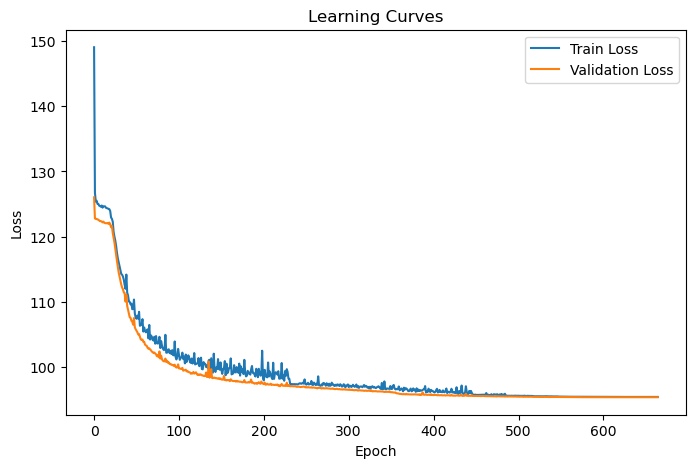

Test Reconstruction Loss: 93.5230
Test Parameter Estimation Loss: 188.2367


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # pip install torchdiffeq
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=1.0):
    # T: time steps, dt: time step size (여기서는 1.0 등)
    return torch.linspace(0, dt*(T-1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    # pred, target: (B, T, output_dim)
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    """
    x: (B, 2) → [x, y]
    theta: (B, 4) → [alpha, beta, gamma, delta]
    
    Lotka-Volterra:
      dx/dt = alpha * x - beta * x * y
      dy/dt = -gamma * y + delta * x * y
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    alpha = theta[:, 0]
    beta  = theta[:, 1]
    gamma = theta[:, 2]
    delta = theta[:, 3]
    dx_dt = alpha * x1 - beta * x1 * x2
    dy_dt = -gamma * x2 + delta * x1 * x2
    return torch.stack([dx_dt, dy_dt], dim=1)  # (B, 2)

# -------------------------------
# 4. PINN Loss: Vector Field Matching
# -------------------------------
def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    """
    xy_hat: (B, T, 2), Neural ODE decoder가 생성한 trajectory
    theta_hat: (B, 4), encoder에서 추정된 파라미터
    odefunc: Neural ODE의 vector field f(x, theta)
    """
    B, T, D = xy_hat.shape
    # 각 time step마다 동일한 theta 사용 (B, T, 4)
    theta_expanded = theta_hat.unsqueeze(1).repeat(1, T, 1)
    # Flatten: (B*T, *)
    xy_hat_flat = xy_hat.reshape(-1, D)
    theta_flat  = theta_expanded.reshape(-1, theta_hat.shape[-1])
    # Neural ODE에서 사용하는 벡터 필드의 출력
    f_pred = odefunc(xy_hat_flat, theta_flat)      # (B*T, 2)
    # 실제 Lotka-Volterra 식에 따른 RHS
    f_true = lotka_volterra_rhs(xy_hat_flat, theta_flat)  # (B*T, 2)
    loss = torch.mean((f_pred - f_true) ** 2)
    return loss

# -------------------------------
# 5. LVODEFunc: Neural ODE Vector Field
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(LVODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 4, hidden_dim),  # state (2) + parameter (4)
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)       # 출력: dx/dt (2)
        )
    
    def forward(self, x, theta):
        # x: (B, 2), theta: (B, 4)
        inp = torch.cat([x, theta], dim=1)  # (B, 6)
        return self.net(inp)

# -------------------------------
# 6. Neural ODE Decoder: ODE Solver 기반 decoder
# -------------------------------
class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super(NeuralODEDecoder, self).__init__()
        self.odefunc = odefunc  # LVODEFunc 인스턴스
    
    def forward(self, x0, theta, t_grid):
        # x0: (B, 2), theta: (B, 4), t_grid: (T,)
        B = x0.shape[0]
        def dynamics(t, x):
            # x는 flatten된 상태: (B * state_dim,)
            x = x.reshape(B, -1)  # (B, 2)
            dxdt = self.odefunc(x, theta)  # (B, 2)
            return dxdt.reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='dopri5')
        # x_t: (T, B*2) → reshape → (T, B, 2)
        x_t = x_t.reshape(t_grid.shape[0], B, -1)
        # return: (B, T, 2)
        return x_t.permute(1, 0, 2)


# -------------------------------
# 7. Encoder: LSTM 기반 (기존 코드 사용)
# -------------------------------
class TimeseriesEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TimeseriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        # x: (B, T, input_dim)
        out, (hn, _) = self.lstm(x)
        z = self.fc(hn[-1])  # (B, latent_dim)
        return z

# -------------------------------
# 8. 전체 모델: Encoder + Neural ODE Decoder
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dim, latent_dim, ode_hidden_dim, num_layers=1):
        super(ODEParameterEstimationModel, self).__init__()
        self.encoder = TimeseriesEncoder(input_dim, encoder_hidden_dim, latent_dim, num_layers)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden_dim))
    
    def forward(self, x):
        # x: (B, T, input_dim) → 관측 시계열 (예: noisy)
        theta = self.encoder(x)       # (B, latent_dim); latent_dim는 파라미터 차원 (예: 4)
        x0 = x[:, 0, :]               # 첫 시점의 값 (B, input_dim)
        T = x.shape[1]
        t_grid = get_time_grid(T, x.device, dt=0.1)  # dt는 상황에 맞게 설정
        x_hat = self.decoder(x0, theta, t_grid)  # (B, T, input_dim)
        return x_hat, theta

# -------------------------------
# 9. 학습 루프: ODE 모델 학습 (PINN loss + reconstruction loss)
# -------------------------------
def train_ode_model(
    model, 
    train_loader, 
    val_loader=None, 
    num_epochs=1000, 
    lr=1e-3, 
    lambda_pinn=0.5, 
    device='cuda', 
    early_stopping_patience=20
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        epoch_loss = 0.0
        
        for batch in train_loader:
            x = batch['timeseries'].to(device)  # (B, T, input_dim)
            optimizer.zero_grad()
            x_hat, theta_hat = model(x)  # x_hat: (B, T, output_dim), theta_hat: (B, latent_dim)
            rec_loss = reconstruction_loss(x_hat, x)
            
            # PINN loss: Neural ODE의 벡터필드와 Lotka-Volterra 식 비교
            physics_loss = pinn_loss_direct_field_match(x_hat, theta_hat, model.decoder.odefunc)
            
            loss = rec_loss + lambda_pinn * physics_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * x.size(0)
        
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    x_val = batch['timeseries'].to(device)
                    x_hat_val, theta_val = model(x_val)
                    loss_val = reconstruction_loss(x_hat_val, x_val)
                    val_loss += loss_val.item() * x_val.size(0)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            
            scheduler.step(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improve_epochs = 0
                best_model_state = model.state_dict()
            else:
                no_improve_epochs += 1
            
            if no_improve_epochs >= early_stopping_patience:
                print("Early stopping triggered.")
                break
        else:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")
    
        # 매 epoch마다 진행 상황 출력
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}" +
              (f", Val Loss = {avg_val_loss:.4f}" if val_loader is not None else ""))
    
    if val_loader is not None and 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        if val_loader is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)
    
    return model, train_losses, val_losses

# -------------------------------
# 10. Evaluation 코드 (제공해준 코드 그대로 사용)
# -------------------------------
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    total_rec_loss = 0.0
    total_param_loss = 0.0
    count = 0  # 전체 배치의 샘플 수 누적

    with torch.no_grad():
        for batch in dataloader:
            # 배치 데이터 로딩
            x_obs = batch['timeseries'].to(device)      # (B, T_obs, state_dim)
            true_params = batch['params'].to(device)      # (B, param_dim)

            # 모델 예측: reconstruction 및 parameter proxy 추출
            pred_obs, cond = model(x_obs)                # pred_obs: (B, T_obs, output_dim), cond: (B, latent_dim)
            
            # 1. Reconstruction Loss (noisy 관측 시계열과 재구성 시계열 간 MSE)
            rec_loss = torch.mean((pred_obs - x_obs) ** 2)
            total_rec_loss += rec_loss.item() * x_obs.size(0)
            
            # 2. Parameter Estimation Loss (추정된 조건 벡터와 ground truth 파라미터 간 MSE)
            param_loss = torch.mean((cond - true_params) ** 2)
            total_param_loss += param_loss.item() * x_obs.size(0)
            
            # 각 배치의 샘플 수 누적
            count += x_obs.size(0)
    
    avg_rec_loss = total_rec_loss / count
    avg_param_loss = total_param_loss / count
    
    print(f"Test Reconstruction Loss: {avg_rec_loss:.4f}")
    print(f"Test Parameter Estimation Loss: {avg_param_loss:.4f}")
    
    return avg_rec_loss, avg_param_loss

# -------------------------------
# 11. 전체 파이프라인 실행 예시
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 하이퍼파라미터 설정 (입력, hidden, latent, ODE hidden dim 등 상황에 맞게 조절)
    input_dim = 2       # state dimension (ex. Lotka-Volterra: [x, y])
    encoder_hidden_dim = 32
    latent_dim = 4      # parameter dimension (예: [alpha, beta, gamma, delta])
    ode_hidden_dim = 32
    num_layers = 1
    
    # 모델 초기화
    model = ODEParameterEstimationModel(input_dim, encoder_hidden_dim, latent_dim, ode_hidden_dim, num_layers=num_layers)
    
    # 데이터 로더 (train_loader, val_loader, test_loader)는 미리 준비되어 있다고 가정
    # 예를 들어:
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # 모델 학습
    trained_model, train_losses, val_losses = train_ode_model(
        model, 
        train_loader, 
        val_loader=val_loader, 
        num_epochs=5000, 
        lr=1e-2, 
        lambda_pinn=1.0, 
        device=device, 
        early_stopping_patience=50
    )
    
    # 평가 수행
    evaluate_model(trained_model, test_loader, device=device)


In [27]:
evaluate_model(trained_model, test_loader, device=device)


Test Reconstruction Loss: 93.5230
Test Parameter Estimation Loss: 188.2367


(93.52300447591146, 188.2366999511719)

In [10]:
import torch
import numpy as np

def extract_true_and_estimated_params(model, dataloader, device='cuda'):
    """
    모델을 이용하여 각 배치의 추정 파라미터 (estimated parameters)를 계산하고,
    dataloader에 포함된 ground truth 파라미터와 함께 numpy 배열로 반환합니다.

    Args:
        model: 학습된 모델 (RNNParameterEstimationModel)
        dataloader: 테스트 데이터셋 DataLoader, 각 batch는 'timeseries'와 'params' key를 포함.
        device: 사용 장치 ('cuda' 또는 'cpu')

    Returns:
        Tuple (true_params, estimated_params), 둘 다 numpy array 형태, shape: (N, param_dim)
    """
    model.eval()
    all_true_params = []
    all_estimated_params = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch['timeseries'].to(device)         # (B, T, input_dim)
            true_params = batch['params'].to(device)     # (B, param_dim)
            # 모델의 인코더를 통해 추정한 조건 벡터를 얻음.
            _, cond = model(x)                          # cond: (B, latent_dim)
            
            all_true_params.append(true_params.cpu().numpy())
            all_estimated_params.append(cond.cpu().numpy())
    
    true_params_all = np.concatenate(all_true_params, axis=0)
    estimated_params_all = np.concatenate(all_estimated_params, axis=0)
    return true_params_all, estimated_params_all

import matplotlib.pyplot as plt

def plot_parameter_scatter(true_params, estimated_params, title='True vs. Estimated Parameters'):
    """
    각 파라미터 차원별로, true parameter와 estimated parameter를 y=x 기준으로 scatter plot으로 시각화합니다.
    
    Args:
        true_params: numpy array, shape (N, param_dim)
        estimated_params: numpy array, shape (N, param_dim)
        title: 전체 그래프 제목
    """
    param_dim = true_params.shape[1]
    fig, axes = plt.subplots(1, param_dim, figsize=(5 * param_dim, 4))
    
    if param_dim == 1:
        axes = [axes]
    
    for d in range(param_dim):
        ax = axes[d]
        ax.scatter(true_params[:, d], estimated_params[:, d], alpha=0.6, edgecolor='k')
        # y = x 기준 선: x 범위는 두 배열의 min과 max를 사용
        min_val = min(np.min(true_params[:, d]), np.min(estimated_params[:, d]))
        max_val = max(np.max(true_params[:, d]), np.max(estimated_params[:, d]))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax.set_xlabel(f"True (Param {d+1})")
        ax.set_ylabel(f"Estimated (Param {d+1})")
        ax.set_title(f"Parameter {d+1}")
    
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


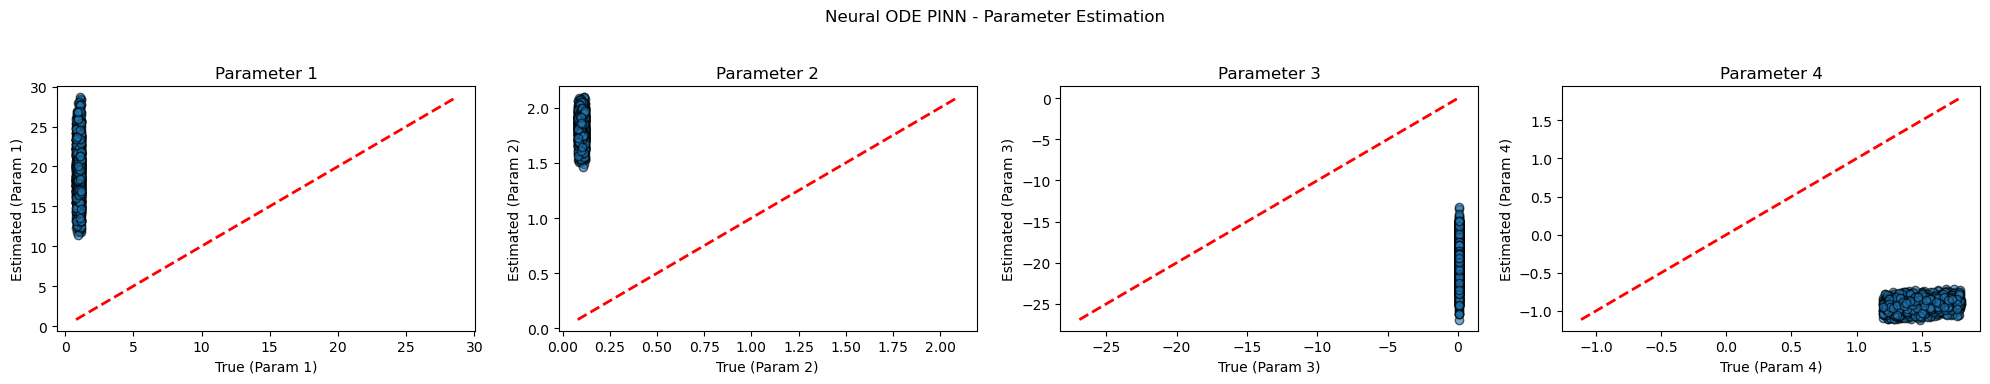

In [29]:
# 모델 학습 후, 테스트 데이터셋에 대해 추정된 파라미터를 비교
true_params, estimated_params = extract_true_and_estimated_params(trained_model, test_loader, device='cuda')

# 시각화
plot_parameter_scatter(true_params, estimated_params, title='Neural ODE PINN - Parameter Estimation')


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_with_decoder_and_phase_space(sample_row, model, device='cuda'):
    # 1. 데이터 파싱
    t_obs = np.array(sample_row['times'])  # 관측 시점
    state_dim = len(sample_row['x0'])
    obs = np.stack([sample_row[f'state_{d}'] for d in range(state_dim)], axis=1)  # (T_obs, state_dim)
    true_traj = np.array(sample_row['true_trajectory'])  # (T_full, state_dim)
    x0 = np.array(sample_row['x0'])  # 초기 상태
    true_params = np.array(sample_row['params'])
    true_params_str = ", ".join([f"{p:.4f}" for p in true_params])

    T_full = true_traj.shape[0]
    t_full = np.linspace(t_obs[0], t_obs[-1], T_full)
    t_tensor = torch.tensor(t_full, dtype=torch.float32).to(device)

    # 2. 모델로부터 예측 trajectory 추출
    x_obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # (1, T_obs, state_dim)
    model.eval()
    with torch.no_grad():
        theta_hat = model.encoder(x_obs_tensor)                     # (1, param_dim)
        x0_tensor = x_obs_tensor[:, 0, :]                           # (1, state_dim)
        traj_tensor = model.decoder(x0_tensor, theta_hat, t_tensor)  # (1, T_full, state_dim)

    est_params = theta_hat.squeeze(0).cpu().numpy()
    est_params_str = ", ".join([f"{p:.4f}" for p in est_params])
    model_traj = traj_tensor.squeeze(0).cpu().numpy()  # (T_full, state_dim)

    # 3. decoder reconstruction at t_obs 추출
    # 시간 정렬 상 같은 t_obs가 t_full의 subset이기 때문에 index를 맞춰 추출
    t_indices = np.linspace(0, T_full - 1, len(t_obs)).astype(int)
    recon_points = model_traj[t_indices]  # decoder output at t_obs

    # 4. 시각화
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    ## (A) Time-Series Plot
    for d in range(state_dim):
        axs[0].plot(t_full, true_traj[:, d], label=f"True Traj dim {d}", color=f"C{d}", linewidth=2)
        axs[0].scatter(t_obs, obs[:, d], label=f"Obs dim {d}", color=f"C{d}", marker='o', edgecolor='k', s=60)
        axs[0].scatter(t_obs, recon_points[:, d], label=f"Reconstruct dim {d}", color=f"C{d}", marker='x', s=60)
        axs[0].plot(t_full, model_traj[:, d], label=f"Decoder Traj dim {d}", color=f"C{d}", linestyle='--', linewidth=2)

    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("State Value")
    axs[0].set_title(f"Time Series\nTrue Params: [{true_params_str}]\nEstimated Params: [{est_params_str}]")
    axs[0].legend(fontsize=8)
    axs[0].grid(alpha=0.3)

    ## (B) Phase Space Plot
    axs[1].plot(true_traj[:, 0], true_traj[:, 1], label="True Traj", color="C0", linewidth=2)
    axs[1].plot(model_traj[:, 0], model_traj[:, 1], label="Decoder Traj", color="C1", linestyle='--', linewidth=2)
    axs[1].scatter(obs[:, 0], obs[:, 1], label="Obs", color="black", marker='o', edgecolor='k', s=60, alpha=0.5)
    axs[1].scatter(recon_points[:, 0], recon_points[:, 1], label="Reconstruct", color="C2", marker='x', s=60)

    axs[1].set_xlabel("State 0")
    axs[1].set_ylabel("State 1")
    axs[1].set_title("Phase Space: State 0 vs State 1")
    axs[1].legend(fontsize=8)
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


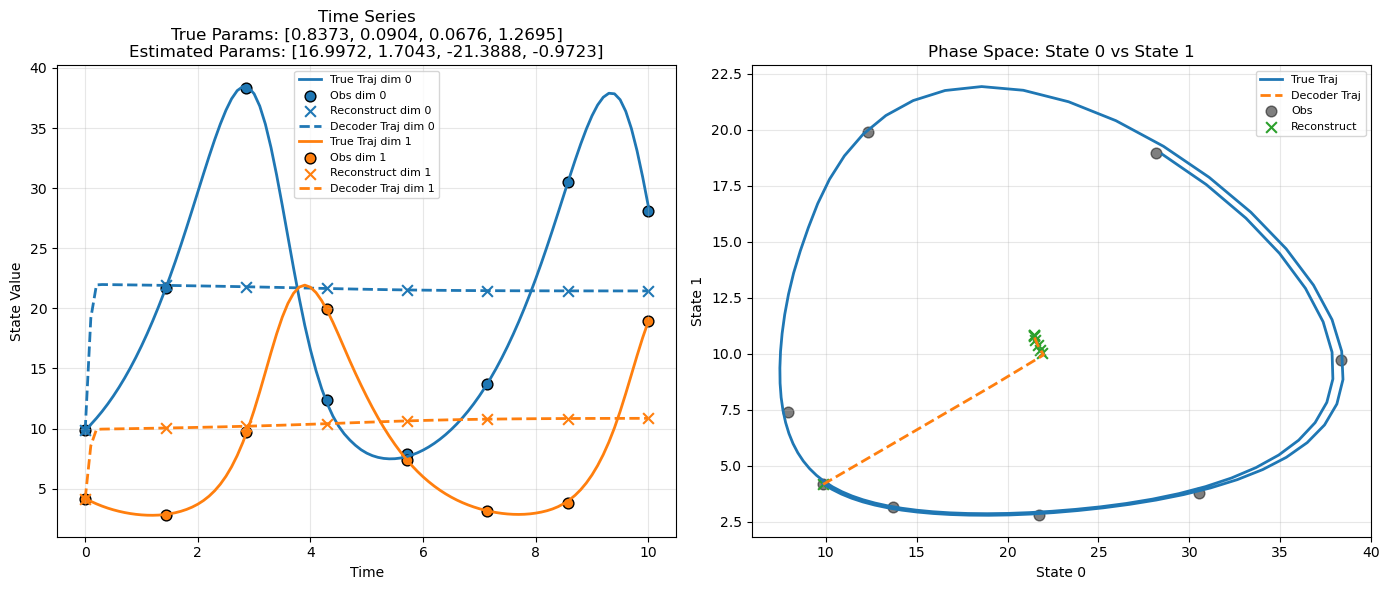

In [31]:
sample_idx = 4
sample_row = test_df.iloc[sample_idx].to_dict()
plot_sample_with_decoder_and_phase_space(sample_row, trained_model, device='cuda')


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # pip install torchdiffeq
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.1):
    # T: time steps, dt: time step size (여기서는 1.0 등)
    return torch.linspace(0, dt*(T-1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    # pred, target: (B, T, output_dim)
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    """
    x: (B, 2) → [x, y]
    theta: (B, 4) → [alpha, beta, gamma, delta]
    
    Lotka-Volterra:
      dx/dt = alpha * x - beta * x * y
      dy/dt = -gamma * y + delta * x * y
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    alpha = theta[:, 0]
    beta  = theta[:, 1]
    gamma = theta[:, 2]
    delta = theta[:, 3]
    dx_dt = alpha * x1 - beta * x1 * x2
    dy_dt = -gamma * x2 + delta * x1 * x2
    return torch.stack([dx_dt, dy_dt], dim=1)  # (B, 2)

# -------------------------------
# 4. PINN Loss: Vector Field Matching
# -------------------------------
def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    """
    xy_hat: (B, T, 2), Neural ODE decoder가 생성한 trajectory
    theta_hat: (B, 4), encoder에서 추정된 파라미터
    odefunc: Neural ODE의 vector field f(x, theta)
    """
    B, T, D = xy_hat.shape
    # 각 time step마다 동일한 theta 사용 (B, T, 4)
    theta_expanded = theta_hat.unsqueeze(1).repeat(1, T, 1)
    # Flatten: (B*T, *)
    xy_hat_flat = xy_hat.reshape(-1, D)
    theta_flat  = theta_expanded.reshape(-1, theta_hat.shape[-1])
    # Neural ODE에서 사용하는 벡터 필드의 출력
    f_pred = odefunc(xy_hat_flat, theta_flat)      # (B*T, 2)
    # 실제 Lotka-Volterra 식에 따른 RHS
    f_true = lotka_volterra_rhs(xy_hat_flat, theta_flat)  # (B*T, 2)
    loss = torch.mean((f_pred - f_true) ** 2)
    return loss

# -------------------------------
# LVODEFunc: 개선된 Neural ODE Vector Field
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(LVODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)  # (B, 6)
        return self.net(inp)

# -------------------------------
# Neural ODE Decoder
# -------------------------------
class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super(NeuralODEDecoder, self).__init__()
        self.odefunc = odefunc

    def forward(self, x0, theta, t_grid):
        B = x0.shape[0]

        def dynamics(t, x):
            x = x.reshape(B, -1)
            dxdt = self.odefunc(x, theta)
            return dxdt.reshape(-1)

        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='dopri5')
        x_t = x_t.reshape(t_grid.shape[0], B, -1)
        return x_t.permute(1, 0, 2)






# -------------------------------
# Sinusoidal Positional Encoding
# -------------------------------
def get_sinusoidal_positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
    return pe  # (1, max_len, d_model)

# -------------------------------
# Transformer Encoder 정의
# -------------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_heads=4, ff_dim=128, n_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Linear(input_dim, ff_dim)
        self.register_buffer('pos_encoding', get_sinusoidal_positional_encoding(max_len, ff_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=ff_dim, nhead=n_heads, dim_feedforward=ff_dim * 2, dropout=dropout, batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.output_layer = nn.Sequential(
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, latent_dim)
        )

    def forward(self, x):
        B, T, _ = x.size()
        x = self.embedding(x) + self.pos_encoding[:, :T, :]
        x = self.transformer(x)
        x_pooled = x.mean(dim=1)
        return self.output_layer(x_pooled)

# -------------------------------
# 전체 모델: Transformer Encoder + 개선된 Decoder
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dim, latent_dim, ode_hidden_dim, num_layers=1):
        super(ODEParameterEstimationModel, self).__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim, n_heads=4, ff_dim=encoder_hidden_dim, n_layers=2)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden_dim))

    def forward(self, x):
        theta = self.encoder(x)
        x0 = x[:, 0, :]
        T = x.shape[1]
        t_grid = get_time_grid(T, x.device, dt=0.1)
        x_hat = self.decoder(x0, theta, t_grid)
        return x_hat, theta

# -------------------------------
# Optimizer & Scheduler 세팅 함수 (Warm-up + CosineAnnealing)
# -------------------------------
def setup_optimizer_scheduler(model, num_epochs, lr=1e-3, weight_decay=1e-4, warmup_epochs=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / float(warmup_epochs)
        else:
            progress = (current_epoch - warmup_epochs) / float(max(1, num_epochs - warmup_epochs))
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return optimizer, scheduler

# -------------------------------
# 개선된 학습 루프
# -------------------------------
def train_ode_model(model, train_loader, val_loader=None, num_epochs=1000, lr=1e-3,
                    lambda_pinn=0.5, device='cuda', early_stopping_patience=20, warmup_epochs=10):
    model.to(device)
    optimizer, scheduler = setup_optimizer_scheduler(model, num_epochs, lr, warmup_epochs=warmup_epochs)

    best_val_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        epoch_loss = 0.0

        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            x_hat, theta_hat = model(x)
            rec_loss = reconstruction_loss(x_hat, x)
            physics_loss = pinn_loss_direct_field_match(x_hat, theta_hat, model.decoder.odefunc)
            lambda_curr = min(lambda_pinn, lambda_pinn * epoch / warmup_epochs)
            loss = rec_loss + lambda_curr * physics_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * x.size(0)

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    x_val = batch['timeseries'].to(device)
                    x_hat_val, theta_val = model(x_val)
                    loss_val = reconstruction_loss(x_hat_val, x_val)
                    val_loss += loss_val.item() * x_val.size(0)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)

            scheduler.step()

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improve_epochs = 0
                best_model_state = model.state_dict()
            else:
                no_improve_epochs += 1

            if no_improve_epochs >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}" +
              (f", Val Loss = {avg_val_loss:.4f}" if val_loader is not None else ""))

    if val_loader is not None and 'best_model_state' in locals():
        model.load_state_dict(best_model_state)

    try:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        if val_loader is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)

    return model, train_losses, val_losses


# -------------------------------
# 10. Evaluation 코드 (제공해준 코드 그대로 사용)
# -------------------------------
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    total_rec_loss = 0.0
    total_param_loss = 0.0
    count = 0  # 전체 배치의 샘플 수 누적

    with torch.no_grad():
        for batch in dataloader:
            # 배치 데이터 로딩
            x_obs = batch['timeseries'].to(device)      # (B, T_obs, state_dim)
            true_params = batch['params'].to(device)      # (B, param_dim)

            # 모델 예측: reconstruction 및 parameter proxy 추출
            pred_obs, cond = model(x_obs)                # pred_obs: (B, T_obs, output_dim), cond: (B, latent_dim)
            
            # 1. Reconstruction Loss (noisy 관측 시계열과 재구성 시계열 간 MSE)
            rec_loss = torch.mean((pred_obs - x_obs) ** 2)
            total_rec_loss += rec_loss.item() * x_obs.size(0)
            
            # 2. Parameter Estimation Loss (추정된 조건 벡터와 ground truth 파라미터 간 MSE)
            param_loss = torch.mean((cond - true_params) ** 2)
            total_param_loss += param_loss.item() * x_obs.size(0)
            
            # 각 배치의 샘플 수 누적
            count += x_obs.size(0)
    
    avg_rec_loss = total_rec_loss / count
    avg_param_loss = total_param_loss / count
    
    print(f"Test Reconstruction Loss: {avg_rec_loss:.4f}")
    print(f"Test Parameter Estimation Loss: {avg_param_loss:.4f}")
    
    return avg_rec_loss, avg_param_loss
# -------------------------------
# 12. 전체 파이프라인 실행 예시
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 하이퍼파라미터 설정
    input_dim = 2             # Lotka-Volterra 상태 차원
    encoder_hidden_dim = 64  # Transformer FFN 차원
    latent_dim = 4           # 추정할 파라미터 차원
    ode_hidden_dim = 64      # ODE 벡터필드 차원
    num_layers = 2

    model = ODEParameterEstimationModel(
        input_dim=input_dim,
        encoder_hidden_dim=encoder_hidden_dim,
        latent_dim=latent_dim,
        ode_hidden_dim=ode_hidden_dim,
        num_layers=num_layers
    )

    # 데이터로더는 외부에서 정의된 것으로 가정
    # train_loader, val_loader, test_loader

    trained_model, train_losses, val_losses = train_ode_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=10000,
        lr=1e-2,
        lambda_pinn=1.0,
        device=device,
        early_stopping_patience=100,
        warmup_epochs=100
    )

    
    # 평가 수행
    evaluate_model(trained_model, test_loader, device=device)


Epochs:   3%|▎         | 278/10000 [10:35:30<1276:47:52, 472.79s/it]

Epoch 278: Train Loss = 80.5307, Val Loss = 79.0957


Epochs:   3%|▎         | 279/10000 [10:44:52<1348:59:41, 499.58s/it]

Epoch 279: Train Loss = 81.6634, Val Loss = 79.0953


Epochs:   3%|▎         | 280/10000 [10:54:10<1396:25:59, 517.20s/it]

Epoch 280: Train Loss = 81.5450, Val Loss = 79.0674


Epochs:   3%|▎         | 281/10000 [11:03:23<1425:27:07, 528.00s/it]

Epoch 281: Train Loss = 81.4484, Val Loss = 78.8713


Epochs:   3%|▎         | 282/10000 [11:13:46<1502:03:09, 556.43s/it]

Epoch 282: Train Loss = 81.2203, Val Loss = 78.8201


Epochs:   3%|▎         | 283/10000 [11:27:30<1718:25:08, 636.65s/it]

Epoch 283: Train Loss = 80.9476, Val Loss = 79.0684


Epochs:   3%|▎         | 284/10000 [11:35:59<1615:18:26, 598.51s/it]

Epoch 284: Train Loss = 80.6613, Val Loss = 78.8990


Epochs:   3%|▎         | 285/10000 [11:44:20<1536:02:21, 569.20s/it]

Epoch 285: Train Loss = 80.4387, Val Loss = 78.9829


Epochs:   3%|▎         | 286/10000 [11:52:49<1486:49:51, 551.02s/it]

Epoch 286: Train Loss = 81.5329, Val Loss = 78.8875


Epochs:   3%|▎         | 287/10000 [12:01:18<1452:58:17, 538.53s/it]

Epoch 287: Train Loss = 81.0745, Val Loss = 78.7951


Epochs:   3%|▎         | 288/10000 [12:09:55<1435:35:09, 532.14s/it]

Epoch 288: Train Loss = 80.6325, Val Loss = 79.0335


Epochs:   3%|▎         | 289/10000 [12:18:19<1412:04:39, 523.48s/it]

Epoch 289: Train Loss = 80.2628, Val Loss = 79.0994


Epochs:   3%|▎         | 290/10000 [12:26:44<1397:34:47, 518.16s/it]

Epoch 290: Train Loss = 80.7682, Val Loss = 78.6935


Epochs:   3%|▎         | 291/10000 [12:34:54<1374:01:20, 509.47s/it]

Epoch 291: Train Loss = 81.1315, Val Loss = 78.8404


Epochs:   3%|▎         | 292/10000 [12:43:22<1372:52:25, 509.10s/it]

Epoch 292: Train Loss = 81.2862, Val Loss = 78.9761


Epochs:   3%|▎         | 293/10000 [12:51:51<1372:27:31, 509.00s/it]

Epoch 293: Train Loss = 80.6623, Val Loss = 79.2151


Epochs:   3%|▎         | 294/10000 [13:00:14<1368:04:46, 507.43s/it]

Epoch 294: Train Loss = 80.6634, Val Loss = 78.7251


Epochs:   3%|▎         | 295/10000 [13:08:34<1361:19:15, 504.97s/it]

Epoch 295: Train Loss = 80.8206, Val Loss = 78.6294


Epochs:   3%|▎         | 296/10000 [13:16:31<1338:55:05, 496.71s/it]

Epoch 296: Train Loss = 81.3056, Val Loss = 78.9871


Epochs:   3%|▎         | 297/10000 [13:24:53<1342:36:39, 498.13s/it]

Epoch 297: Train Loss = 81.6580, Val Loss = 79.1974


Epochs:   3%|▎         | 298/10000 [13:33:25<1354:10:49, 502.48s/it]

Epoch 298: Train Loss = 81.4282, Val Loss = 78.7766


Epochs:   3%|▎         | 299/10000 [13:41:28<1338:25:05, 496.68s/it]

Epoch 299: Train Loss = 81.3685, Val Loss = 78.6889


Epochs:   3%|▎         | 300/10000 [13:49:56<1347:04:05, 499.94s/it]

Epoch 300: Train Loss = 81.3879, Val Loss = 78.9079


Epochs:   3%|▎         | 301/10000 [13:57:58<1332:53:08, 494.73s/it]

Epoch 301: Train Loss = 81.1852, Val Loss = 78.6202


Epochs:   3%|▎         | 302/10000 [14:06:20<1337:52:03, 496.63s/it]

Epoch 302: Train Loss = 81.2109, Val Loss = 78.6673


Epochs:   3%|▎         | 303/10000 [14:15:24<1376:47:44, 511.13s/it]

Epoch 303: Train Loss = 82.1140, Val Loss = 79.1132


Epochs:   3%|▎         | 304/10000 [14:25:56<1473:36:25, 547.13s/it]

Epoch 304: Train Loss = 80.4795, Val Loss = 78.6460


Epochs:   3%|▎         | 305/10000 [14:36:32<1545:10:00, 573.76s/it]

Epoch 305: Train Loss = 80.0304, Val Loss = 78.4981


Epochs:   3%|▎         | 306/10000 [14:46:04<1543:39:46, 573.26s/it]

Epoch 306: Train Loss = 80.4206, Val Loss = 78.8783


Epochs:   3%|▎         | 307/10000 [14:55:18<1527:56:02, 567.48s/it]

Epoch 307: Train Loss = 80.2558, Val Loss = 78.6485


Epochs:   3%|▎         | 308/10000 [15:05:03<1542:28:05, 572.93s/it]

Epoch 308: Train Loss = 80.6485, Val Loss = 78.6261


Epochs:   3%|▎         | 309/10000 [15:15:20<1577:47:12, 586.11s/it]

Epoch 309: Train Loss = 80.4459, Val Loss = 78.9136


Epochs:   3%|▎         | 310/10000 [15:27:00<1669:05:40, 620.10s/it]

Epoch 310: Train Loss = 80.0553, Val Loss = 78.5793


Epochs:   3%|▎         | 311/10000 [15:35:32<1581:39:53, 587.68s/it]

Epoch 311: Train Loss = 79.8918, Val Loss = 78.4560


Epochs:   3%|▎         | 312/10000 [15:44:27<1539:35:40, 572.10s/it]

Epoch 312: Train Loss = 80.0213, Val Loss = 78.6468


Epochs:   3%|▎         | 313/10000 [15:53:31<1516:08:11, 563.44s/it]

Epoch 313: Train Loss = 80.1996, Val Loss = 78.5520


Epochs:   3%|▎         | 314/10000 [16:02:12<1481:42:54, 550.71s/it]

Epoch 314: Train Loss = 80.1466, Val Loss = 78.5298


Epochs:   3%|▎         | 315/10000 [16:10:47<1453:18:28, 540.21s/it]

Epoch 315: Train Loss = 79.9957, Val Loss = 78.4358


Epochs:   3%|▎         | 316/10000 [16:19:15<1426:36:13, 530.34s/it]

Epoch 316: Train Loss = 80.0550, Val Loss = 78.6054


Epochs:   3%|▎         | 317/10000 [16:27:57<1420:21:59, 528.07s/it]

Epoch 317: Train Loss = 81.1666, Val Loss = 78.8352


Epochs:   3%|▎         | 318/10000 [16:36:46<1420:32:26, 528.19s/it]

Epoch 318: Train Loss = 80.0276, Val Loss = 78.8010


Epochs:   3%|▎         | 319/10000 [16:45:53<1435:20:56, 533.75s/it]

Epoch 319: Train Loss = 80.9603, Val Loss = 78.5043


Epochs:   3%|▎         | 320/10000 [16:54:26<1419:02:30, 527.74s/it]

Epoch 320: Train Loss = 80.1840, Val Loss = 79.6474


Epochs:   3%|▎         | 321/10000 [17:03:05<1411:28:39, 524.98s/it]

Epoch 321: Train Loss = 80.5457, Val Loss = 79.4283


Epochs:   3%|▎         | 322/10000 [17:12:10<1427:52:11, 531.14s/it]

Epoch 322: Train Loss = 80.9100, Val Loss = 78.7723


Epochs:   3%|▎         | 323/10000 [17:21:43<1461:04:44, 543.54s/it]

Epoch 323: Train Loss = 80.0316, Val Loss = 78.5998


Epochs:   3%|▎         | 324/10000 [17:31:04<1475:14:32, 548.87s/it]

Epoch 324: Train Loss = 81.6312, Val Loss = 78.6483


Epochs:   3%|▎         | 325/10000 [17:39:29<1440:02:22, 535.83s/it]

Epoch 325: Train Loss = 80.5010, Val Loss = 78.3583


Epochs:   3%|▎         | 326/10000 [17:45:09<1281:20:10, 476.83s/it]

Epoch 326: Train Loss = 80.4730, Val Loss = 78.7717


Epochs:   3%|▎         | 327/10000 [17:50:49<1170:48:34, 435.74s/it]

Epoch 327: Train Loss = 80.6571, Val Loss = 78.4152


Epochs:   3%|▎         | 328/10000 [17:56:27<1091:56:48, 406.43s/it]

Epoch 328: Train Loss = 80.9847, Val Loss = 78.5163


Epochs:   3%|▎         | 329/10000 [18:01:54<1028:13:39, 382.75s/it]

Epoch 329: Train Loss = 80.9988, Val Loss = 78.4784


Epochs:   3%|▎         | 330/10000 [18:07:37<996:15:25, 370.89s/it] 

Epoch 330: Train Loss = 80.8883, Val Loss = 78.3360


Epochs:   3%|▎         | 331/10000 [18:13:09<964:14:02, 359.01s/it]

Epoch 331: Train Loss = 80.8957, Val Loss = 78.3300


Epochs:   3%|▎         | 332/10000 [18:18:44<944:57:39, 351.87s/it]

Epoch 332: Train Loss = 80.8612, Val Loss = 78.4572


Epochs:   3%|▎         | 333/10000 [18:24:13<926:48:06, 345.14s/it]

Epoch 333: Train Loss = 80.1294, Val Loss = 78.3093


Epochs:   3%|▎         | 334/10000 [18:29:39<911:02:43, 339.31s/it]

Epoch 334: Train Loss = 80.0702, Val Loss = 78.4051


Epochs:   3%|▎         | 335/10000 [18:35:19<911:41:15, 339.58s/it]

Epoch 335: Train Loss = 80.2138, Val Loss = 78.4493


Epochs:   3%|▎         | 336/10000 [18:40:58<911:10:10, 339.43s/it]

Epoch 336: Train Loss = 79.9937, Val Loss = 78.2979


Epochs:   3%|▎         | 337/10000 [18:46:33<907:25:19, 338.06s/it]

Epoch 337: Train Loss = 81.8289, Val Loss = 78.4310


Epochs:   3%|▎         | 338/10000 [18:51:59<897:41:43, 334.48s/it]

Epoch 338: Train Loss = 80.5361, Val Loss = 78.2235


Epochs:   3%|▎         | 339/10000 [18:57:30<895:02:01, 333.52s/it]

Epoch 339: Train Loss = 80.8488, Val Loss = 80.0212


Epochs:   3%|▎         | 340/10000 [19:03:07<897:08:46, 334.34s/it]

Epoch 340: Train Loss = 80.6431, Val Loss = 78.2447


Epochs:   3%|▎         | 341/10000 [19:08:29<887:17:29, 330.70s/it]

Epoch 341: Train Loss = 79.7204, Val Loss = 78.5212


Epochs:   3%|▎         | 342/10000 [19:13:59<887:01:28, 330.64s/it]

Epoch 342: Train Loss = 80.0284, Val Loss = 78.2735


Epochs:   3%|▎         | 343/10000 [19:19:36<891:33:13, 332.36s/it]

Epoch 343: Train Loss = 81.0112, Val Loss = 78.2736


Epochs:   3%|▎         | 344/10000 [19:24:57<882:49:07, 329.14s/it]

Epoch 344: Train Loss = 80.7181, Val Loss = 78.2065


Epochs:   3%|▎         | 345/10000 [19:30:40<893:40:04, 333.22s/it]

Epoch 345: Train Loss = 79.8407, Val Loss = 78.2025


Epochs:   3%|▎         | 346/10000 [19:36:25<902:49:55, 336.67s/it]

Epoch 346: Train Loss = 79.8240, Val Loss = 78.1682


Epochs:   3%|▎         | 347/10000 [19:42:08<908:15:33, 338.73s/it]

Epoch 347: Train Loss = 79.6932, Val Loss = 78.2406


Epochs:   3%|▎         | 348/10000 [19:47:41<903:10:36, 336.87s/it]

Epoch 348: Train Loss = 80.1070, Val Loss = 78.2473


Epochs:   3%|▎         | 349/10000 [19:53:16<901:23:19, 336.23s/it]

Epoch 349: Train Loss = 79.7440, Val Loss = 78.5151


Epochs:   4%|▎         | 350/10000 [19:58:56<904:11:23, 337.31s/it]

Epoch 350: Train Loss = 80.4831, Val Loss = 78.3193


Epochs:   4%|▎         | 351/10000 [20:04:31<902:49:19, 336.84s/it]

Epoch 351: Train Loss = 80.3922, Val Loss = 78.2763


Epochs:   4%|▎         | 352/10000 [20:10:13<907:04:16, 338.46s/it]

Epoch 352: Train Loss = 80.1020, Val Loss = 78.2258


Epochs:   4%|▎         | 353/10000 [20:15:37<895:02:00, 334.00s/it]

Epoch 353: Train Loss = 80.8002, Val Loss = 80.5189


Epochs:   4%|▎         | 354/10000 [20:21:08<892:26:30, 333.07s/it]

Epoch 354: Train Loss = 82.1013, Val Loss = 78.6091


Epochs:   4%|▎         | 355/10000 [20:26:37<889:15:31, 331.92s/it]

Epoch 355: Train Loss = 82.4203, Val Loss = 79.2935


Epochs:   4%|▎         | 356/10000 [20:32:17<895:35:46, 334.32s/it]

Epoch 356: Train Loss = 80.3658, Val Loss = 78.0410


Epochs:   4%|▎         | 357/10000 [20:37:56<899:10:20, 335.69s/it]

Epoch 357: Train Loss = 80.1346, Val Loss = 78.3377


Epochs:   4%|▎         | 358/10000 [20:43:47<911:05:17, 340.17s/it]

Epoch 358: Train Loss = 79.5669, Val Loss = 78.0368


Epochs:   4%|▎         | 359/10000 [20:49:41<922:21:59, 344.42s/it]

Epoch 359: Train Loss = 79.9510, Val Loss = 77.9630


Epochs:   4%|▎         | 360/10000 [20:55:19<917:21:43, 342.58s/it]

Epoch 360: Train Loss = 79.3063, Val Loss = 78.0015


Epochs:   4%|▎         | 361/10000 [21:00:53<909:47:12, 339.79s/it]

Epoch 361: Train Loss = 79.5096, Val Loss = 78.1184


Epochs:   4%|▎         | 362/10000 [21:06:11<892:55:55, 333.53s/it]

Epoch 362: Train Loss = 81.0514, Val Loss = 78.0460


Epochs:   4%|▎         | 363/10000 [21:11:38<887:35:26, 331.57s/it]

Epoch 363: Train Loss = 79.6276, Val Loss = 77.9736


Epochs:   4%|▎         | 364/10000 [21:17:23<898:02:55, 335.51s/it]

Epoch 364: Train Loss = 80.2271, Val Loss = 78.0504


Epochs:   4%|▎         | 365/10000 [21:23:07<904:45:05, 338.05s/it]

Epoch 365: Train Loss = 81.7296, Val Loss = 78.0222


Epochs:   4%|▎         | 366/10000 [21:28:49<907:48:33, 339.23s/it]

Epoch 366: Train Loss = 79.6535, Val Loss = 78.1421


Epochs:   4%|▎         | 367/10000 [21:34:21<901:33:06, 336.92s/it]

Epoch 367: Train Loss = 80.1624, Val Loss = 78.3136


Epochs:   4%|▎         | 368/10000 [21:39:53<897:24:24, 335.41s/it]

Epoch 368: Train Loss = 80.8654, Val Loss = 78.2753


Epochs:   4%|▎         | 369/10000 [21:45:28<897:32:54, 335.50s/it]

Epoch 369: Train Loss = 80.7269, Val Loss = 77.9400


Epochs:   4%|▎         | 370/10000 [21:51:02<895:59:37, 334.95s/it]

Epoch 370: Train Loss = 81.4585, Val Loss = 79.7856


Epochs:   4%|▎         | 371/10000 [21:56:32<892:19:28, 333.61s/it]

Epoch 371: Train Loss = 80.5376, Val Loss = 77.9611


Epochs:   4%|▎         | 372/10000 [22:01:52<880:35:27, 329.26s/it]

Epoch 372: Train Loss = 80.4586, Val Loss = 78.0125


Epochs:   4%|▎         | 373/10000 [22:07:11<873:00:55, 326.46s/it]

Epoch 373: Train Loss = 80.4087, Val Loss = 78.1308


Epochs:   4%|▎         | 374/10000 [22:12:31<867:02:38, 324.26s/it]

Epoch 374: Train Loss = 80.2928, Val Loss = 77.7879


Epochs:   4%|▍         | 375/10000 [22:17:56<867:52:58, 324.61s/it]

Epoch 375: Train Loss = 79.4948, Val Loss = 78.1192


Epochs:   4%|▍         | 376/10000 [22:23:16<863:54:08, 323.16s/it]

Epoch 376: Train Loss = 80.9213, Val Loss = 78.1610


Epochs:   4%|▍         | 377/10000 [22:28:37<862:30:29, 322.67s/it]

Epoch 377: Train Loss = 81.1094, Val Loss = 77.9080


Epochs:   4%|▍         | 378/10000 [22:33:54<857:30:32, 320.83s/it]

Epoch 378: Train Loss = 79.5916, Val Loss = 78.0590


Epochs:   4%|▍         | 379/10000 [22:39:13<856:05:06, 320.33s/it]

Epoch 379: Train Loss = 80.0344, Val Loss = 78.1850


Epochs:   4%|▍         | 380/10000 [22:44:30<853:20:27, 319.34s/it]

Epoch 380: Train Loss = 80.3588, Val Loss = 77.8850


Epochs:   4%|▍         | 381/10000 [22:49:55<857:45:48, 321.03s/it]

Epoch 381: Train Loss = 79.3955, Val Loss = 77.8825


Epochs:   4%|▍         | 382/10000 [22:55:18<858:58:06, 321.51s/it]

Epoch 382: Train Loss = 79.9168, Val Loss = 78.1428


Epochs:   4%|▍         | 383/10000 [23:00:57<872:48:23, 326.72s/it]

Epoch 383: Train Loss = 80.1001, Val Loss = 78.1275


Epochs:   4%|▍         | 384/10000 [23:06:23<872:46:58, 326.75s/it]

Epoch 384: Train Loss = 80.5522, Val Loss = 77.8397


Epochs:   4%|▍         | 385/10000 [23:12:03<882:40:22, 330.49s/it]

Epoch 385: Train Loss = 80.4069, Val Loss = 77.8984


Epochs:   4%|▍         | 386/10000 [23:17:46<892:54:27, 334.35s/it]

Epoch 386: Train Loss = 80.1559, Val Loss = 78.1524


Epochs:   4%|▍         | 387/10000 [23:23:32<902:28:32, 337.97s/it]

Epoch 387: Train Loss = 80.7616, Val Loss = 78.6301


Epochs:   4%|▍         | 388/10000 [23:29:27<915:55:36, 343.04s/it]

Epoch 388: Train Loss = 80.0359, Val Loss = 78.4509


Epochs:   4%|▍         | 389/10000 [23:35:24<927:11:32, 347.30s/it]

Epoch 389: Train Loss = 79.2882, Val Loss = 77.9782


Epochs:   4%|▍         | 390/10000 [23:41:20<934:01:13, 349.89s/it]

Epoch 390: Train Loss = 79.3507, Val Loss = 77.9546


Epochs:   4%|▍         | 391/10000 [23:47:15<937:49:30, 351.36s/it]

Epoch 391: Train Loss = 79.6882, Val Loss = 77.6456


Epochs:   4%|▍         | 392/10000 [23:53:14<943:49:57, 353.64s/it]

Epoch 392: Train Loss = 79.5102, Val Loss = 77.8945


Epochs:   4%|▍         | 393/10000 [23:59:14<948:22:10, 355.38s/it]

Epoch 393: Train Loss = 80.8266, Val Loss = 77.8574


Epochs:   4%|▍         | 394/10000 [24:05:12<951:02:59, 356.42s/it]

Epoch 394: Train Loss = 80.1066, Val Loss = 77.8601


Epochs:   4%|▍         | 395/10000 [24:11:10<951:33:23, 356.65s/it]

Epoch 395: Train Loss = 80.0715, Val Loss = 77.6335


Epochs:   4%|▍         | 396/10000 [24:17:06<950:54:19, 356.44s/it]

Epoch 396: Train Loss = 79.8843, Val Loss = 77.7786


Epochs:   4%|▍         | 397/10000 [24:23:03<951:50:18, 356.83s/it]

Epoch 397: Train Loss = 79.5055, Val Loss = 77.9993


Epochs:   4%|▍         | 398/10000 [24:29:02<953:07:30, 357.35s/it]

Epoch 398: Train Loss = 80.2717, Val Loss = 77.5981


Epochs:   4%|▍         | 399/10000 [24:34:58<952:13:16, 357.05s/it]

Epoch 399: Train Loss = 80.2641, Val Loss = 77.8014


Epochs:   4%|▍         | 400/10000 [24:40:52<949:25:22, 356.03s/it]

Epoch 400: Train Loss = 79.8849, Val Loss = 77.6072


Epochs:   4%|▍         | 401/10000 [24:46:37<940:42:24, 352.80s/it]

Epoch 401: Train Loss = 79.5045, Val Loss = 77.8065


Epochs:   4%|▍         | 402/10000 [24:52:31<941:10:18, 353.01s/it]

Epoch 402: Train Loss = 79.9324, Val Loss = 77.6321


Epochs:   4%|▍         | 403/10000 [24:58:12<931:35:24, 349.46s/it]

Epoch 403: Train Loss = 81.0358, Val Loss = 77.7496


Epochs:   4%|▍         | 404/10000 [25:04:06<935:36:11, 351.00s/it]

Epoch 404: Train Loss = 80.1957, Val Loss = 77.7356


Epochs:   4%|▍         | 405/10000 [25:10:03<939:56:39, 352.66s/it]

Epoch 405: Train Loss = 79.9521, Val Loss = 77.7041


Epochs:   4%|▍         | 406/10000 [25:16:04<946:24:50, 355.13s/it]

Epoch 406: Train Loss = 79.8415, Val Loss = 78.1598


Epochs:   4%|▍         | 407/10000 [25:21:55<942:51:15, 353.83s/it]

Epoch 407: Train Loss = 80.8483, Val Loss = 77.6874


Epochs:   4%|▍         | 408/10000 [25:27:48<942:22:22, 353.68s/it]

Epoch 408: Train Loss = 79.0920, Val Loss = 77.6871


Epochs:   4%|▍         | 409/10000 [25:33:44<944:19:38, 354.46s/it]

Epoch 409: Train Loss = 80.0455, Val Loss = 77.8176


Epochs:   4%|▍         | 410/10000 [25:39:41<946:18:08, 355.23s/it]

Epoch 410: Train Loss = 79.6100, Val Loss = 77.5135


Epochs:   4%|▍         | 411/10000 [25:45:50<957:00:40, 359.29s/it]

Epoch 411: Train Loss = 79.9318, Val Loss = 77.5592


Epochs:   4%|▍         | 412/10000 [25:52:20<981:24:13, 368.49s/it]

Epoch 412: Train Loss = 79.8868, Val Loss = 77.8120


Epochs:   4%|▍         | 413/10000 [26:01:27<1124:11:08, 422.14s/it]

Epoch 413: Train Loss = 79.2611, Val Loss = 77.5290


Epochs:   4%|▍         | 414/10000 [26:11:17<1258:05:13, 472.47s/it]

Epoch 414: Train Loss = 79.4430, Val Loss = 77.5953


Epochs:   4%|▍         | 415/10000 [26:21:02<1347:41:14, 506.17s/it]

Epoch 415: Train Loss = 80.2169, Val Loss = 77.6307


Epochs:   4%|▍         | 416/10000 [26:32:12<1478:12:44, 555.26s/it]

Epoch 416: Train Loss = 80.1655, Val Loss = 77.4569


Epochs:   4%|▍         | 417/10000 [26:44:38<1630:09:49, 612.40s/it]

Epoch 417: Train Loss = 79.8292, Val Loss = 79.7134


Epochs:   4%|▍         | 418/10000 [26:56:27<1707:33:45, 641.54s/it]

Epoch 418: Train Loss = 79.2208, Val Loss = 77.4215


Epochs:   4%|▍         | 419/10000 [27:07:25<1720:49:37, 646.59s/it]

Epoch 419: Train Loss = 79.4264, Val Loss = 77.5460


Epochs:   4%|▍         | 420/10000 [27:17:27<1684:37:51, 633.06s/it]

Epoch 420: Train Loss = 79.4899, Val Loss = 78.9398


Epochs:   4%|▍         | 421/10000 [27:28:21<1701:33:41, 639.48s/it]

Epoch 421: Train Loss = 79.2269, Val Loss = 77.4962


Epochs:   4%|▍         | 422/10000 [27:42:27<1866:03:45, 701.38s/it]

Epoch 422: Train Loss = 79.7978, Val Loss = 77.6238


Epochs:   4%|▍         | 423/10000 [27:51:48<1753:19:06, 659.07s/it]

Epoch 423: Train Loss = 79.5506, Val Loss = 77.6400


Epochs:   4%|▍         | 424/10000 [28:01:16<1680:28:17, 631.76s/it]

Epoch 424: Train Loss = 79.0058, Val Loss = 77.5926


Epochs:   4%|▍         | 425/10000 [28:11:01<1643:33:27, 617.94s/it]

Epoch 425: Train Loss = 79.4404, Val Loss = 77.5370


Epochs:   4%|▍         | 426/10000 [28:21:14<1639:32:42, 616.50s/it]

Epoch 426: Train Loss = 79.6984, Val Loss = 77.6818


Epochs:   4%|▍         | 427/10000 [28:31:37<1644:26:34, 618.41s/it]

Epoch 427: Train Loss = 80.1062, Val Loss = 77.6676


Epochs:   4%|▍         | 428/10000 [28:41:41<1632:15:31, 613.89s/it]

Epoch 428: Train Loss = 79.4293, Val Loss = 77.5910


Epochs:   4%|▍         | 429/10000 [28:51:33<1614:52:22, 607.41s/it]

Epoch 429: Train Loss = 78.8678, Val Loss = 77.4047


Epochs:   4%|▍         | 430/10000 [29:01:56<1626:57:17, 612.02s/it]

Epoch 430: Train Loss = 79.7356, Val Loss = 77.4091


Epochs:   4%|▍         | 431/10000 [29:12:34<1647:47:02, 619.92s/it]

Epoch 431: Train Loss = 79.8369, Val Loss = 77.6275


Epochs:   4%|▍         | 432/10000 [29:22:12<1614:11:16, 607.34s/it]

Epoch 432: Train Loss = 78.7646, Val Loss = 77.3788


Epochs:   4%|▍         | 433/10000 [29:31:47<1588:27:42, 597.73s/it]

Epoch 433: Train Loss = 79.0802, Val Loss = 77.3701


Epochs:   4%|▍         | 434/10000 [29:40:52<1545:42:29, 581.70s/it]

Epoch 434: Train Loss = 79.2198, Val Loss = 78.8036


Epochs:   4%|▍         | 435/10000 [29:50:01<1520:05:45, 572.12s/it]

Epoch 435: Train Loss = 79.4978, Val Loss = 77.4026


Epochs:   4%|▍         | 436/10000 [29:59:05<1497:02:35, 563.50s/it]

Epoch 436: Train Loss = 79.1381, Val Loss = 78.8909


Epochs:   4%|▍         | 437/10000 [30:09:18<1536:50:17, 578.54s/it]

Epoch 437: Train Loss = 79.2101, Val Loss = 77.2680


Epochs:   4%|▍         | 437/10000 [30:15:18<662:04:45, 249.24s/it] 


KeyboardInterrupt: 

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # use standard odeint instead of adjoint to avoid parameter binding error  # use adjoint for memory and speed
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.1):
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. PINN Loss: Vector Field Matching
# -------------------------------
def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    B, T, D = xy_hat.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat = xy_hat.reshape(-1, D)
    theta_flat = theta_exp.reshape(-1, theta_hat.size(-1))
    f_pred = odefunc(xy_flat, theta_flat)
    f_true = lotka_volterra_rhs(xy_flat, theta_flat)
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 5. LVODEFunc & NeuralODEDecoder with RK4
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x, theta):
        return self.net(torch.cat([x, theta], dim=1))


class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)

        def dynamics(t, x):
            return self.odefunc(x.reshape(B, -1), theta).reshape(-1)

        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='rk4')
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# Sinusoidal Positional Encoding & TransformerEncoder
# -------------------------------

def get_sinusoidal_positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    pos = torch.arange(max_len).unsqueeze(1).float()
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)


class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_heads=4, ff_dim=128, n_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.embed = nn.Linear(input_dim, ff_dim)
        self.register_buffer('pos_enc', get_sinusoidal_positional_encoding(max_len, ff_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=ff_dim, nhead=n_heads,
            dim_feedforward=ff_dim * 2, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.out = nn.Sequential(nn.Linear(ff_dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, latent_dim))

    def forward(self, x):
        B, T, _ = x.size()
        h = self.embed(x) + self.pos_enc[:, :T, :]
        h = self.transformer(h)
        return self.out(h.mean(dim=1))

# -------------------------------
# ODEParameterEstimationModel
# -------------------------------

class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, latent_dim, ode_hidden, n_layers=2):
        super().__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim, ff_dim=enc_hidden, n_layers=n_layers)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x):
        theta = self.encoder(x)
        x0 = x[:, 0, :]
        t_grid = get_time_grid(x.size(1), x.device)
        return self.decoder(x0, theta, t_grid), theta

# -------------------------------
# Optimizer & Scheduler (Warm-up + Cosine)
# -------------------------------

def setup_optimizer_scheduler(model, epochs, lr=1e-3, wd=1e-4, warmup=10):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    def lr_lambda(ep):
        if ep < warmup:
            return float(ep + 1) / warmup
        progress = (ep - warmup) / float(max(1, epochs - warmup))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return opt, torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

# -------------------------------
# 9. 학습 루프 with Checkpointing & AMP
# -------------------------------

def train_ode_model(model, train_loader, val_loader=None,
                    epochs=1000, lr=1e-3, lambda_pinn=0.5,
                    device='cuda', patience=20, warmup=10,
                    ckpt_dir='checkpoints', save_every=50):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    # disable torch.compile due to dynamo errors
    # model = torch.compile(model)
    optimizer, scheduler = setup_optimizer_scheduler(model, epochs, lr, wd=1e-4, warmup=warmup)
    scaler = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0
    train_losses, val_losses = [], []

    try:
        for ep in range(epochs):
            model.train()
            epoch_loss = 0.0
            for batch in train_loader:
                x = batch['timeseries'].to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    x_hat, theta = model(x)
                    rec = reconstruction_loss(x_hat, x)
                    phys = pinn_loss_direct_field_match(x_hat, theta, model.decoder.odefunc)
                    lam = min(lambda_pinn, lambda_pinn * ep / warmup)
                    loss = rec + lam * phys
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item() * x.size(0)
            train_losses.append(epoch_loss / len(train_loader.dataset))

            if val_loader:
                model.eval()
                vl = 0.0
                with torch.no_grad(), torch.cuda.amp.autocast():
                    for b in val_loader:
                        x = b['timeseries'].to(device)
                        pred, _ = model(x)
                        vl += reconstruction_loss(pred, x).item() * x.size(0)
                val_loss = vl / len(val_loader.dataset)
                val_losses.append(val_loss)
                scheduler.step()  # step without epoch to avoid deprecation warning
                if val_loss < best_val:
                    best_val, no_imp = val_loss, 0
                    torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict()},
                               os.path.join(ckpt_dir, 'best.pt'))
                else:
                    no_imp += 1
                if no_imp >= patience:
                    print("\nEarly stopping triggered. Saving checkpoint.")
                    raise KeyboardInterrupt
            else:
                scheduler.step()

            if (ep + 1) % save_every == 0:
                torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                            'train_losses': train_losses, 'val_losses': val_losses},
                           os.path.join(ckpt_dir, f'ckpt_{ep+1}.pt'))

            print(f"Epoch {ep+1}: Train {train_losses[-1]:.4f}" +
                  (f", Val {val_losses[-1]:.4f}" if val_loader else ""))
    except KeyboardInterrupt:
        torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                    'train_losses': train_losses, 'val_losses': val_losses},
                   os.path.join(ckpt_dir, f'interrupt_{ep}.pt'))
        print("\nInterrupted, checkpoint saved.")
        raise

    torch.save(model.state_dict(), os.path.join(ckpt_dir, 'final.pt'))
    return model, train_losses, val_losses

# -------------------------------
# 10. Evaluation
# -------------------------------
def evaluate_model(model, dloader, device='cuda'):
    model.eval()
    total_rec, total_param, count = 0.0, 0.0, 0
    with torch.no_grad():
        for b in dloader:
            x = b['timeseries'].to(device)
            p = b['params'].to(device)
            pred, theta = model(x)
            total_rec += reconstruction_loss(pred, x).item() * x.size(0)
            total_param += torch.mean((theta - p) ** 2).item() * x.size(0)
            count += x.size(0)
    avg_rec = total_rec / count
    avg_param = total_param / count
    print(f"Rec {avg_rec:.4f}, Param {avg_param:.4f}")
    return avg_rec, avg_param

# -------------------------------
# 11. 파이프라인 실행
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEParameterEstimationModel(2, 64, 4, 64, 2).to(device)
    # train_loader, val_loader, test_loader 정의 필요
    trained, tl, vl = train_ode_model(
        model, train_loader, val_loader,
        epochs=1000, lr=1e-3, lambda_pinn=0.5,
        device=device, patience=100, warmup=100
    )
    evaluate_model(trained, test_loader, device)


Epoch 1: Train 167.7102, Val 167.6001
Epoch 2: Train 194.7526, Val 167.5183
Epoch 3: Train 164.8519, Val 162.3706
Epoch 4: Train 156.8855, Val 151.2463
Epoch 5: Train 144.3505, Val 136.2599
Epoch 6: Train 137.7526, Val 131.1105
Epoch 7: Train 135.8602, Val 129.7262
Epoch 8: Train 134.6102, Val 128.6604
Epoch 9: Train 133.4165, Val 127.8433
Epoch 10: Train 132.4958, Val 127.2602
Epoch 11: Train 131.4935, Val 126.6277
Epoch 12: Train 130.3091, Val 126.2461
Epoch 13: Train 129.4665, Val 125.8886
Epoch 14: Train 128.8795, Val 125.6879
Epoch 15: Train 128.3987, Val 125.5816
Epoch 16: Train 128.0032, Val 125.3221
Epoch 17: Train 127.4080, Val 125.2334
Epoch 18: Train 127.5503, Val 125.2084
Epoch 19: Train 127.4239, Val 125.1413
Epoch 20: Train 127.1674, Val 124.9543
Epoch 21: Train 127.0452, Val 124.7499
Epoch 22: Train 126.4504, Val 124.5425
Epoch 23: Train 126.3210, Val 123.9482
Epoch 24: Train 125.8992, Val 123.9439
Epoch 25: Train 125.3945, Val 123.5228
Epoch 26: Train 126.0855, Val 123.

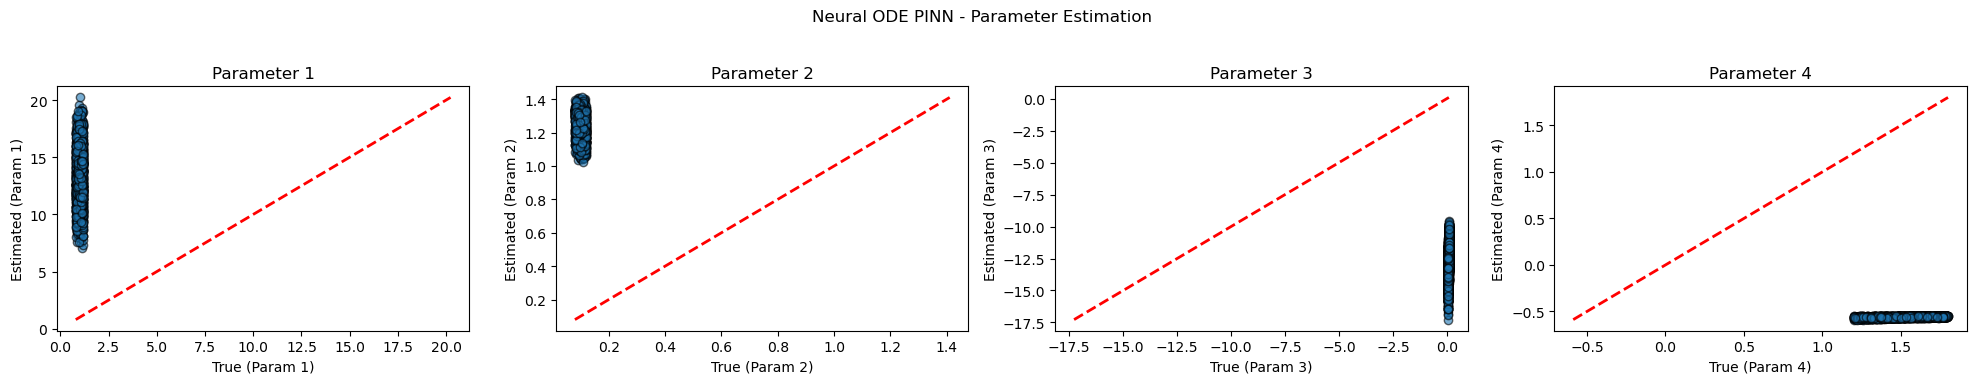

In [46]:
# 모델 학습 후, 테스트 데이터셋에 대해 추정된 파라미터를 비교
true_params, estimated_params = extract_true_and_estimated_params(trained_model, test_loader, device='cuda')

# 시각화
plot_parameter_scatter(true_params, estimated_params, title='Neural ODE PINN - Parameter Estimation')

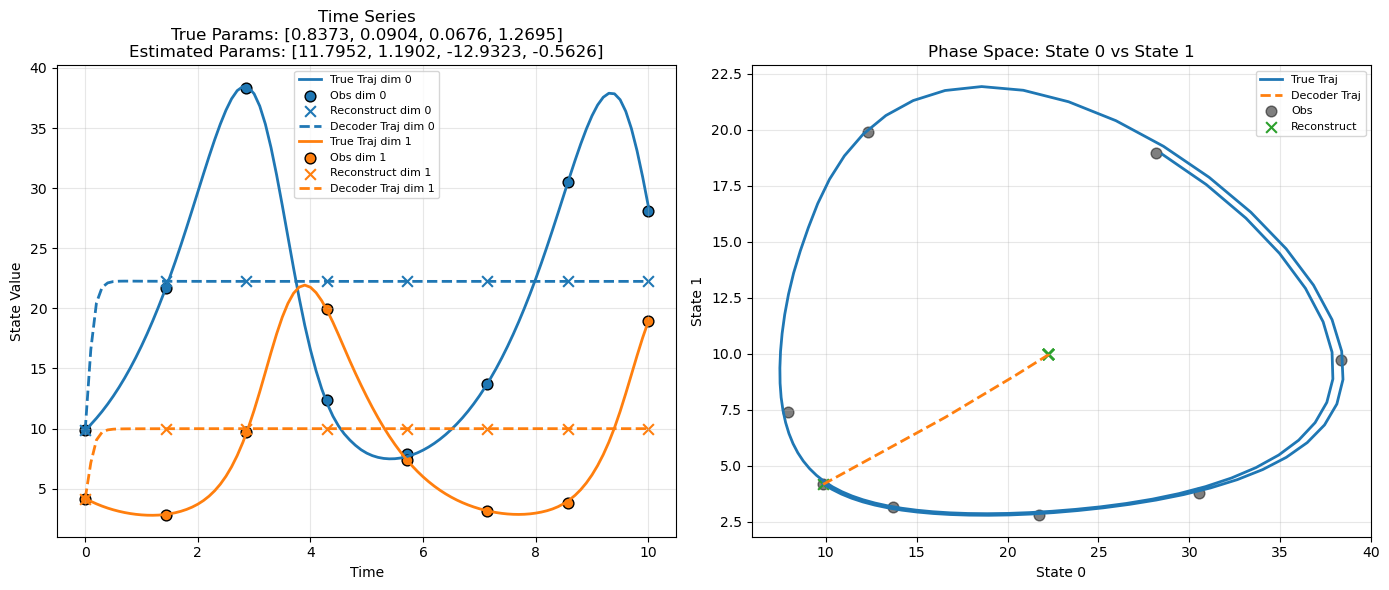

In [47]:
sample_idx = 4
sample_row = test_df.iloc[sample_idx].to_dict()
plot_sample_with_decoder_and_phase_space(sample_row, trained_model, device='cuda')


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # use standard odeint
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):  # dt increased for stability
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. PINN Loss: Vector Field Matching
# -------------------------------
def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    B, T, D = xy_hat.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat = xy_hat.reshape(-1, D)
    theta_flat = theta_exp.reshape(-1, theta_hat.size(-1))
    # force physics loss in FP32
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 5. LVODEFunc & NeuralODEDecoder with RK4
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx = self.net(inp)
        # clamp output for stability
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x):
            return self.odefunc(x.reshape(B, -1), theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='rk4')
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# Sinusoidal Positional Encoding & TransformerEncoder
# -------------------------------
def get_sinusoidal_positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    pos = torch.arange(max_len).unsqueeze(1).float()
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_heads=4, ff_dim=128, n_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.embed = nn.Linear(input_dim, ff_dim)
        self.register_buffer('pos_enc', get_sinusoidal_positional_encoding(max_len, ff_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=ff_dim, nhead=n_heads,
            dim_feedforward=ff_dim * 2, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.out = nn.Sequential(nn.Linear(ff_dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, latent_dim))

    def forward(self, x):
        B, T, _ = x.size()
        h = self.embed(x) + self.pos_enc[:, :T, :]
        h = self.transformer(h)
        return self.out(h.mean(dim=1))

# -------------------------------
# ODEParameterEstimationModel
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, latent_dim, ode_hidden, n_layers=2):
        super().__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim, ff_dim=enc_hidden, n_layers=n_layers)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x):
        theta = self.encoder(x)
        x0 = x[:, 0, :]
        t_grid = get_time_grid(x.size(1), x.device)
        return self.decoder(x0, theta, t_grid), theta

# -------------------------------
# Optimizer & Scheduler (Warm-up + Cosine)
# -------------------------------
def setup_optimizer_scheduler(model, epochs, lr=1e-3, wd=1e-4, warmup=10):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    def lr_lambda(ep):
        if ep < warmup:
            return float(ep + 1) / warmup
        progress = (ep - warmup) / float(max(1, epochs - warmup))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return opt, torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

# -------------------------------
# 9. 학습 루프 with Checkpointing & AMP & Freezing
# -------------------------------
def train_ode_model(model, train_loader, val_loader=None,
                    epochs=1000, lr=1e-3, lambda_pinn=0.5,
                    device='cuda', patience=20, warmup=10,
                    freeze_epochs=20, ckpt_dir='checkpoints', save_every=50):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer, scheduler = setup_optimizer_scheduler(model, epochs, lr, wd=1e-4, warmup=warmup)
    scaler = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0
    train_losses, val_losses = [], []

    try:
        for ep in range(epochs):
            model.train()
            # Freeze ODEFunc for initial epochs
            if ep < freeze_epochs:
                for p in model.decoder.odefunc.parameters(): p.requires_grad_(False)
            else:
                for p in model.decoder.odefunc.parameters(): p.requires_grad_(True)

            epoch_loss = 0.0
            for batch in train_loader:
                x = batch['timeseries'].to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    x_hat, theta = model(x)
                    rec = reconstruction_loss(x_hat, x)
                    phys = pinn_loss_direct_field_match(x_hat, theta, model.decoder.odefunc)
                    lam = 0.1 + 0.9 * min(ep / warmup, 1.0)  # smoother start
                    loss = rec + lam * phys
                if torch.isnan(loss):
                    for pg in optimizer.param_groups: pg['lr'] *= 0.5
                    continue
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item() * x.size(0)
            avg_train = epoch_loss / len(train_loader.dataset)
            train_losses.append(avg_train)

            # Validation
            if val_loader:
                model.eval()
                vl = 0.0
                with torch.no_grad():
                    for b in val_loader:
                        x_val = b['timeseries'].to(device)
                        pred, _ = model(x_val)
                        vl += reconstruction_loss(pred, x_val).item() * x_val.size(0)
                avg_val = vl / len(val_loader.dataset)
                val_losses.append(avg_val)
                scheduler.step()
                if avg_val < best_val:
                    best_val, no_imp = avg_val, 0
                    torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict()},
                               os.path.join(ckpt_dir, 'best.pt'))
                else:
                    no_imp += 1
                if no_imp >= patience:
                    print("\nEarly stopping triggered. Saving checkpoint.")
                    break
            else:
                scheduler.step()

            if (ep + 1) % save_every == 0:
                torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                            'train_losses': train_losses, 'val_losses': val_losses},
                           os.path.join(ckpt_dir, f'ckpt_{ep+1}.pt'))

            print(f"Epoch {ep+1}: Train {avg_train:.4f}" + (f", Val {avg_val:.4f}" if val_loader else ""))
    except KeyboardInterrupt:
        torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                    'train_losses': train_losses, 'val_losses': val_losses},
                   os.path.join(ckpt_dir, f'interrupt_{ep}.pt'))
        print("\nInterrupted, checkpoint saved.")
        raise

    torch.save(model.state_dict(), os.path.join(ckpt_dir, 'final.pt'))
    return model, train_losses, val_losses

# -------------------------------
# 10. Evaluation
# -------------------------------
def evaluate_model(model, dloader, device='cuda'):
    model.eval()
    total_rec, total_param, count = 0.0, 0.0, 0
    with torch.no_grad():
        for b in dloader:
            x = b['timeseries'].to(device)
            p = b['params'].to(device)
            pred, theta = model(x)
            total_rec += reconstruction_loss(pred, x).item() * x.size(0)
            total_param += torch.mean((theta - p) ** 2).item() * x.size(0)
            count += x.size(0)
    avg_rec = total_rec / count
    avg_param = total_param / count
    print(f"Rec {avg_rec:.4f}, Param {avg_param:.4f}")
    return avg_rec, avg_param

# -------------------------------
# 11. Two‑Stage Training Functions & Pipeline
# -------------------------------
def pretrain_reconstruction(model, train_loader, val_loader=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)
    best_val = float('inf')
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = reconstruction_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss=0.0
            with torch.no_grad():
                for b in val_loader:
                    x = b['timeseries'].to(device)
                    pred, _ = model(x)
                    val_loss += reconstruction_loss(pred, x).item()*x.size(0)
            val_loss/=len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir,'best_pretrain.pt'))
        print(f"Pretrain Ep {ep+1}: Train {train_loss:.4f}" + (f", Val {val_loss:.4f}" if val_loader else ""))
    model.load_state_dict(torch.load(os.path.join(ckpt_dir,'best_pretrain.pt')))
    return model

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEParameterEstimationModel(2, 64, 4, 64, 2).to(device)
    # define train_loader, val_loader, test_loader
    print("==> Stage 1: Pretrain reconstruction")
    model = pretrain_reconstruction(model, train_loader, val_loader, epochs=10000, lr=1e-5, device=device)
    print("==> Stage 2: PINN fine-tuning")
    trained, tl, vl = train_ode_model(model, train_loader, val_loader, epochs=2000, lr=1e-6,
                                      lambda_pinn=1e-2, device=device, patience=100, warmup=200)
    evaluate_model(trained, test_loader, device)


/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


==> Stage 1: Pretrain reconstruction
Pretrain Ep 1: Train 177.9622, Val 166.2741
Pretrain Ep 2: Train 154.8716, Val 145.7295
Pretrain Ep 3: Train 138.5015, Val 133.8476
Pretrain Ep 4: Train 130.1947, Val 128.4425
Pretrain Ep 5: Train 126.4519, Val 125.9450
Pretrain Ep 6: Train 124.6232, Val 124.6433
Pretrain Ep 7: Train 123.6023, Val 123.8663
Pretrain Ep 8: Train 122.9732, Val 123.3695
Pretrain Ep 9: Train 122.5497, Val 123.0217
Pretrain Ep 10: Train 122.2496, Val 122.7688
Pretrain Ep 11: Train 122.0193, Val 122.5689
Pretrain Ep 12: Train 121.8373, Val 122.4078
Pretrain Ep 13: Train 121.6880, Val 122.2743
Pretrain Ep 14: Train 121.5600, Val 122.1576
Pretrain Ep 15: Train 121.4446, Val 122.0495
Pretrain Ep 16: Train 121.3376, Val 121.9449
Pretrain Ep 17: Train 121.2324, Val 121.8433
Pretrain Ep 18: Train 121.1297, Val 121.7447
Pretrain Ep 19: Train 121.0299, Val 121.6461
Pretrain Ep 20: Train 120.9315, Val 121.5491
Pretrain Ep 21: Train 120.8322, Val 121.4530
Pretrain Ep 22: Train 120.7

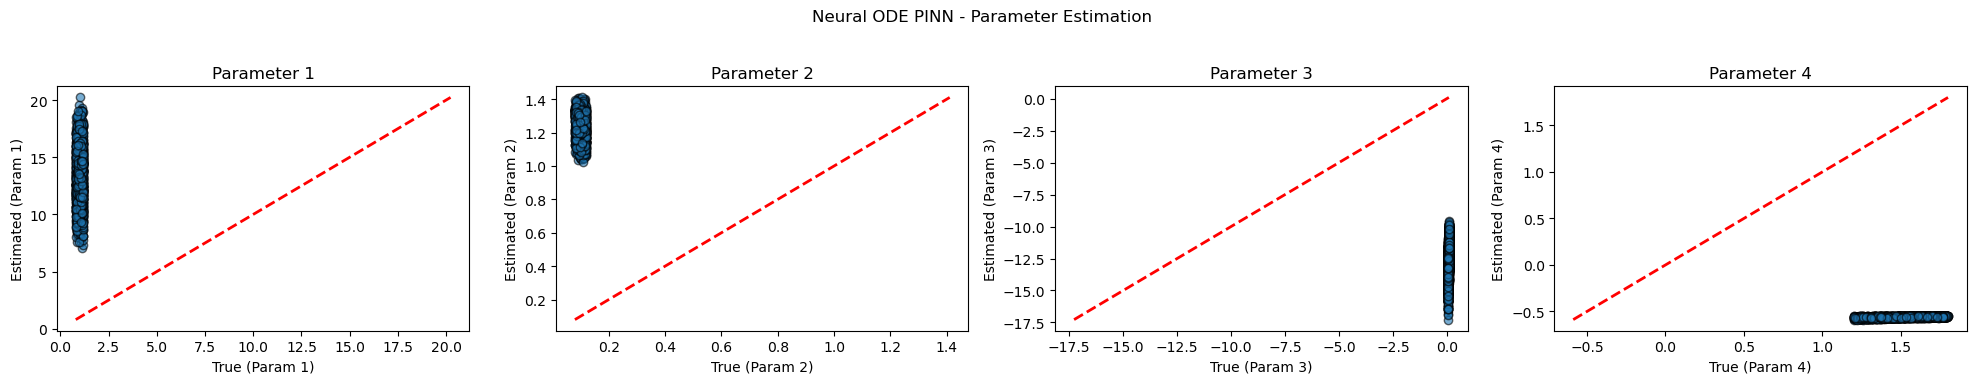

In [59]:
# 모델 학습 후, 테스트 데이터셋에 대해 추정된 파라미터를 비교
true_params, estimated_params = extract_true_and_estimated_params(trained_model, test_loader, device='cuda')

# 시각화
plot_parameter_scatter(true_params, estimated_params, title='Neural ODE PINN - Parameter Estimation')

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint  # use standard odeint
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):  # dt increased for stability
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Reconstruction Loss
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. PINN Loss: Vector Field Matching
# -------------------------------
def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    B, T, D = xy_hat.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat = xy_hat.reshape(-1, D)
    theta_flat = theta_exp.reshape(-1, theta_hat.size(-1))
    # force physics loss in FP32
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 5. LVODEFunc & NeuralODEDecoder with RK4
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx = self.net(inp)
        # clamp output for stability
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x):
            return self.odefunc(x.reshape(B, -1), theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method='rk4')
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# Sinusoidal Positional Encoding & TransformerEncoder
# -------------------------------
def get_sinusoidal_positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    pos = torch.arange(max_len).unsqueeze(1).float()
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_heads=4, ff_dim=128, n_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.embed = nn.Linear(input_dim, ff_dim)
        self.register_buffer('pos_enc', get_sinusoidal_positional_encoding(max_len, ff_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=ff_dim, nhead=n_heads,
            dim_feedforward=ff_dim * 2, dropout=dropout,
            batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.out = nn.Sequential(nn.Linear(ff_dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, latent_dim))

    def forward(self, x):
        B, T, _ = x.size()
        h = self.embed(x) + self.pos_enc[:, :T, :]
        h = self.transformer(h)
        return self.out(h.mean(dim=1))

# -------------------------------
# ODEParameterEstimationModel
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, latent_dim, ode_hidden, n_layers=2):
        super().__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim, ff_dim=enc_hidden, n_layers=n_layers)
        self.decoder = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x):
        theta = self.encoder(x)
        x0 = x[:, 0, :]
        t_grid = get_time_grid(x.size(1), x.device)
        return self.decoder(x0, theta, t_grid), theta


In [ ]:

# -------------------------------
# Optimizer & Scheduler (Warm-up + Cosine)
# -------------------------------
def setup_optimizer_scheduler(model, epochs, lr=1e-3, wd=1e-4, warmup=10):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    def lr_lambda(ep):
        if ep < warmup:
            return float(ep + 1) / warmup
        progress = (ep - warmup) / float(max(1, epochs - warmup))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return opt, torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

# -------------------------------
# 9. 학습 루프 with Checkpointing & AMP & Freezing
# -------------------------------
def train_ode_model(model, train_loader, val_loader=None,
                    epochs=1000, lr=1e-3, lambda_pinn=0.5,
                    device='cuda', patience=20, warmup=10,
                    freeze_epochs=20, ckpt_dir='checkpoints', save_every=50):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer, scheduler = setup_optimizer_scheduler(model, epochs, lr, wd=1e-4, warmup=warmup)
    scaler = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0
    train_losses, val_losses = [], []

    try:
        for ep in range(epochs):
            model.train()
            # Freeze ODEFunc for initial epochs
            if ep < freeze_epochs:
                for p in model.decoder.odefunc.parameters(): p.requires_grad_(False)
            else:
                for p in model.decoder.odefunc.parameters(): p.requires_grad_(True)

            epoch_loss = 0.0
            for batch in train_loader:
                x = batch['timeseries'].to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    x_hat, theta = model(x)
                    rec = reconstruction_loss(x_hat, x)
                    phys = pinn_loss_direct_field_match(x_hat, theta, model.decoder.odefunc)
                    lam = 0.1 + 0.9 * min(ep / warmup, lambda_pinn)  # smoother start
                    loss = rec + lam * phys
                if torch.isnan(loss):
                    for pg in optimizer.param_groups: pg['lr'] *= 0.5
                    continue
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item() * x.size(0)
            avg_train = epoch_loss / len(train_loader.dataset)
            train_losses.append(avg_train)

            # Validation
            if val_loader:
                model.eval()
                vl = 0.0
                with torch.no_grad():
                    for b in val_loader:
                        x_val = b['timeseries'].to(device)
                        pred, _ = model(x_val)
                        vl += reconstruction_loss(pred, x_val).item() * x_val.size(0)
                avg_val = vl / len(val_loader.dataset)
                val_losses.append(avg_val)
                scheduler.step()
                if avg_val < best_val:
                    best_val, no_imp = avg_val, 0
                    torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict()},
                               os.path.join(ckpt_dir, 'best.pt'))
                else:
                    no_imp += 1
                if no_imp >= patience:
                    print("\nEarly stopping triggered. Saving checkpoint.")
                    break
            else:
                scheduler.step()

            if (ep + 1) % save_every == 0:
                torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                            'train_losses': train_losses, 'val_losses': val_losses},
                           os.path.join(ckpt_dir, f'ckpt_{ep+1}.pt'))

            print(f"Epoch {ep+1}: Train {avg_train:.4f}" + (f", Val {avg_val:.4f}" if val_loader else ""))
    except KeyboardInterrupt:
        torch.save({'ep': ep, 'model': model.state_dict(), 'opt': optimizer.state_dict(),
                    'train_losses': train_losses, 'val_losses': val_losses},
                   os.path.join(ckpt_dir, f'interrupt_{ep}.pt'))
        print("\nInterrupted, checkpoint saved.")
        raise

    torch.save(model.state_dict(), os.path.join(ckpt_dir, 'final.pt'))
    return model, train_losses, val_losses

# -------------------------------
# 10. Evaluation
# -------------------------------
def evaluate_model(model, dloader, device='cuda'):
    model.eval()
    total_rec, total_param, count = 0.0, 0.0, 0
    with torch.no_grad():
        for b in dloader:
            x = b['timeseries'].to(device)
            p = b['params'].to(device)
            pred, theta = model(x)
            total_rec += reconstruction_loss(pred, x).item() * x.size(0)
            total_param += torch.mean((theta - p) ** 2).item() * x.size(0)
            count += x.size(0)
    avg_rec = total_rec / count
    avg_param = total_param / count
    print(f"Rec {avg_rec:.4f}, Param {avg_param:.4f}")
    return avg_rec, avg_param

# -------------------------------
# 11. Two‑Stage Training Functions & Pipeline
# -------------------------------
def pretrain_reconstruction(model, train_loader, val_loader=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.99, patience=100)
    best_val = float('inf')
    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = reconstruction_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss=0.0
            with torch.no_grad():
                for b in val_loader:
                    x = b['timeseries'].to(device)
                    pred, _ = model(x)
                    val_loss += reconstruction_loss(pred, x).item()*x.size(0)
            val_loss/=len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir,'best_pretrain.pt'))
        print(f"Pretrain Ep {ep+1}: Train {train_loss:.4f}" + (f", Val {val_loss:.4f}" if val_loader else ""))
    model.load_state_dict(torch.load(os.path.join(ckpt_dir,'best_pretrain.pt')))
    return model

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEParameterEstimationModel(input_dim=2, 
                                        enc_hidden=16,
                                        latent_dim=4,
                                        ode_hidden=16,
                                        n_layers=1).to(device)
    # define train_loader, val_loader, test_loader
    print("==> Stage 1: Pretrain reconstruction")
    model = pretrain_reconstruction(model, train_loader, val_loader, epochs=20000, lr=1e-3, device=device)
    print("==> Stage 2: PINN fine-tuning")
    trained, tl, vl = train_ode_model(model, train_loader, val_loader, epochs=10000, lr=1e-8,
                                      lambda_pinn=1e-3, device=device, patience=200, warmup=200)
    evaluate_model(trained, test_loader, device)


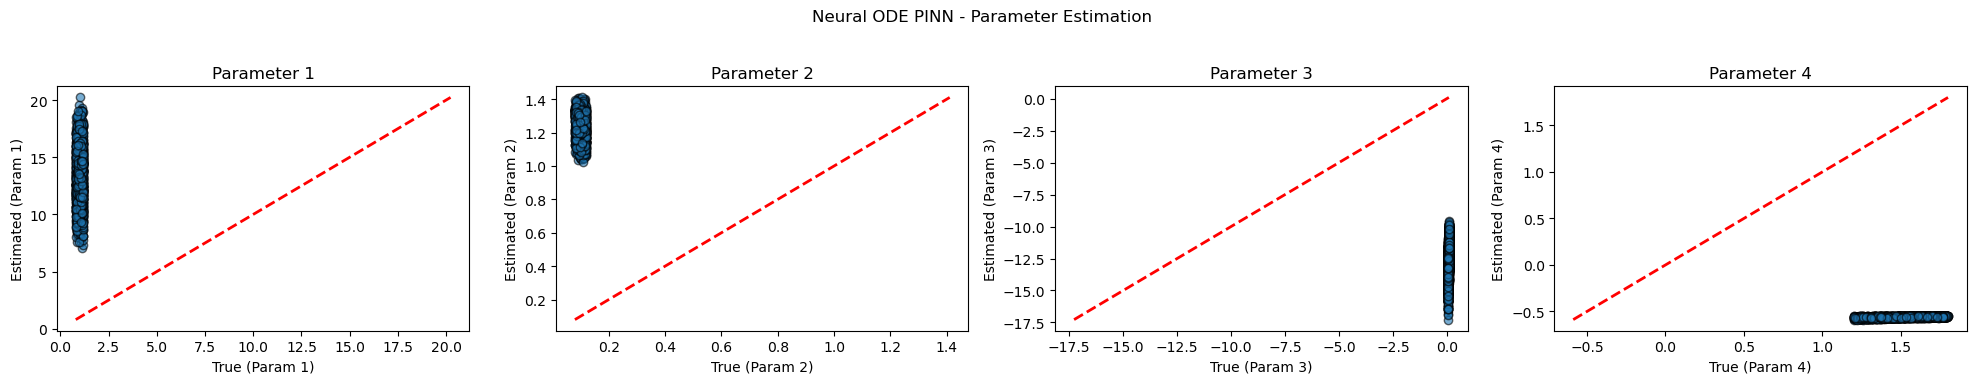

In [66]:
# 모델 학습 후, 테스트 데이터셋에 대해 추정된 파라미터를 비교
true_params, estimated_params = extract_true_and_estimated_params(trained_model, test_loader, device='cuda')

# 시각화
plot_parameter_scatter(true_params, estimated_params, title='Neural ODE PINN - Parameter Estimation')

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from tqdm import tqdm
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Loss functions
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    B, T, D = xy_hat.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat   = xy_hat.reshape(-1, D)
    theta_flat= theta_exp.reshape(-1, theta_hat.size(-1))
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. Model components (unchanged)
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx  = self.net(inp)
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc, solver='rk4'):
        super().__init__()
        self.odefunc = odefunc
        self.solver  = solver

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x):
            return self.odefunc(x.reshape(B, -1), theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method=self.solver)
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# ... TransformerEncoder and ODEParameterEstimationModel unchanged ...

# -------------------------------
# 5. Two-Stage Training Pipeline
# -------------------------------

def pretrain_reconstruction(model, train_loader, val_loader=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.99, patience=50)
    best_val = float('inf')

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = reconstruction_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val = b['timeseries'].to(device)
                    pred, _ = model(x_val)
                    val_loss += reconstruction_loss(pred, x_val).item() * x_val.size(0)
            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_pretrain.pt'))

        print(f"[Pretrain] Epoch {ep+1}/{epochs} - Train Loss: {train_loss:.4f}" +
              (f", Val Loss: {val_loss:.4f}" if val_loader else ""))

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_pretrain.pt')))
    return model


# Stage 2: PINN Fine-Tuning with encoder freeze control

def train_finetune(model, train_loader, val_loader=None,
                   epochs=500, lr=1e-4, lambda_pinn=0.1,
                   device='cuda', warmup=50, freeze_enc_epochs=100,
                   ckpt_dir='checkpoints/finetune'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    # Freeze encoder entirely initially
    for p in model.encoder.parameters(): p.requires_grad_(False)

    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr, weight_decay=1e-4
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler()

    best_val, no_imp = float('inf'), 0
    for ep in range(epochs):
        model.train()
        # Unfreeze encoder after freeze_enc_epochs
        if ep == freeze_enc_epochs:
            for p in model.encoder.parameters(): p.requires_grad_(True)
            # re-create optimizer to include encoder params
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

        epoch_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                x_hat, theta = model(x)
                rec_loss  = reconstruction_loss(x_hat, x)
                phys_loss = pinn_loss_direct_field_match(x_hat, theta, model.decoder.odefunc)
                lam = min((ep / warmup), 1.0) * lambda_pinn
                loss = rec_loss + lam * phys_loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item() * x.size(0)

        avg_train = epoch_loss / len(train_loader.dataset)
        # Validation on reconstruction only
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val = b['timeseries'].to(device)
                    pred, _ = model(x_val)
                    val_loss += reconstruction_loss(pred, x_val).item() * x_val.size(0)
            avg_val = val_loss / len(val_loader.dataset)
            scheduler.step()
            if avg_val < best_val:
                best_val, no_imp = avg_val, 0
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_finetune.pt'))
            else:
                no_imp += 1
                if no_imp >= 20:
                    print("Early stopping finetune")
                    break

        print(f"[FineTune] Epoch {ep+1}/{epochs} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_finetune.pt')))
    return model

# -------------------------------
# Entry point
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEParameterEstimationModel(input_dim=2,
                                        enc_hidden=16,
                                        latent_dim=4,
                                        ode_hidden=16,
                                        n_layers=1).to(device)
    # define train_loader, val_loader, test_loader

    # Stage 1: Pretraining reconstruction
    model = pretrain_reconstruction(model, train_loader, val_loader,
                                    epochs=1000, lr=1e-3, device=device)

    # Stage 2: Finetune with PINN
    model = train_finetune(model, train_loader, val_loader,
                           epochs=1000, lr=1e-4, lambda_pinn=1e-3,
                           device=device, warmup=200,
                           freeze_enc_epochs=200)

    # Final evaluation
    evaluate_model(model, test_loader, device)


/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Pretrain] Epoch 1/1000 - Train Loss: 130.4152, Val Loss: 122.1184
[Pretrain] Epoch 2/1000 - Train Loss: 120.9974, Val Loss: 121.0909
[Pretrain] Epoch 3/1000 - Train Loss: 120.0569, Val Loss: 120.5576
[Pretrain] Epoch 4/1000 - Train Loss: 119.8507, Val Loss: 120.4404
[Pretrain] Epoch 5/1000 - Train Loss: 119.7509, Val Loss: 120.3663
[Pretrain] Epoch 6/1000 - Train Loss: 119.6693, Val Loss: 120.2625
[Pretrain] Epoch 7/1000 - Train Loss: 119.5711, Val Loss: 120.2009
[Pretrain] Epoch 8/1000 - Train Loss: 119.4734, Val Loss: 120.0718
[Pretrain] Epoch 9/1000 - Train Loss: 119.3715, Val Loss: 119.9733
[Pretrain] Epoch 10/1000 - Train Loss: 119.2853, Val Loss: 119.8878
[Pretrain] Epoch 11/1000 - Train Loss: 119.2035, Val Loss: 119.8045
[Pretrain] Epoch 12/1000 - Train Loss: 119.0964, Val Loss: 119.6949
[Pretrain] Epoch 13/1000 - Train Loss: 118.9204, Val Loss: 119.4205
[Pretrain] Epoch 14/1000 - Train Loss: 118.5289, Val Loss: 118.9485
[Pretrain] Epoch 15/1000 - Train Loss: 117.9827, Val Loss

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/finetune/best_finetune.pt'

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from tqdm import tqdm
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Loss functions
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def pinn_loss_direct_field_match(xy_hat, theta_hat, odefunc):
    B, T, D = xy_hat.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat   = xy_hat.reshape(-1, D)
    theta_flat= theta_exp.reshape(-1, theta_hat.size(-1))
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. Model components
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx  = self.net(inp)
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc, solver='rk4'):
        super().__init__()
        self.odefunc = odefunc
        self.solver  = solver

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x):
            return self.odefunc(x.reshape(B, -1), theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method=self.solver)
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# 5. Encoder-Decoder with separate param mapping
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, z_dim, param_dim, ode_hidden, n_layers=2):
        super().__init__()
        # Transformer encoder outputs high-dim latent z
        self.encoder   = TransformerEncoder(input_dim, z_dim, ff_dim=enc_hidden, n_layers=n_layers)
        # Separate network maps z -> physical parameters θ
        self.param_net = nn.Sequential(
            nn.Linear(z_dim, z_dim), nn.ReLU(),
            nn.Linear(z_dim, param_dim)
        )
        # Neural ODE decoder
        self.decoder   = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x):
        z      = self.encoder(x)             # [B, z_dim]
        theta  = self.param_net(z)           # [B, param_dim]
        x0     = x[:, 0, :]
        t_grid = get_time_grid(x.size(1), x.device)
        x_hat  = self.decoder(x0, theta, t_grid)
        return x_hat, theta

# -------------------------------
# 6. Two-Stage Training Pipeline
# -------------------------------

def pretrain_reconstruction(model, train_loader, val_loader=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=20)
    best_val = float('inf')

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = reconstruction_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val, _ = model(b['timeseries'].to(device))
                    val_loss += reconstruction_loss(x_val, b['timeseries'].to(device)).item() * x_val.size(0)
            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_pretrain.pt'))
        print(f"[Pretrain] Ep {ep+1}/{epochs} - Train: {train_loss:.4f}" + (f", Val: {val_loss:.4f}" if val_loader else ""))

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_pretrain.pt')))
    return model


def train_finetune(model, train_loader, val_loader=None,
                   epochs=500, lr=1e-4, lambda_pinn=0.1,
                   device='cuda', warmup=50, freeze_enc_epochs=100,
                   ckpt_dir='checkpoints/finetune'):
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    # Initially freeze encoder
    for p in model.encoder.parameters(): p.requires_grad_(False)

    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler    = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0

    for ep in range(epochs):
        model.train()
        if ep == freeze_enc_epochs:
            for p in model.encoder.parameters(): p.requires_grad_(True)
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-ep)
            scaler    = torch.cuda.amp.GradScaler()

        epoch_loss = 0.0
        for batch in train_loader:
            x = batch['timeseries'].to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                x_hat, theta = model(x)
                rec_loss  = reconstruction_loss(x_hat, x)
                phys_loss = pinn_loss_direct_field_match(x_hat, theta, model.decoder.odefunc)
                lam = min(ep / warmup, 1.0) * lambda_pinn
                loss = rec_loss + lam * phys_loss
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item() * x.size(0)

        avg_train = epoch_loss / len(train_loader.dataset)
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val = b['timeseries'].to(device)
                    pred, _ = model(x_val)
                    val_loss += reconstruction_loss(pred, x_val).item() * x_val.size(0)
            avg_val = val_loss / len(val_loader.dataset)
            scheduler.step()
            if avg_val < best_val:
                best_val, no_imp = avg_val, 0
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_finetune.pt'))
            else:
                no_imp += 1
                if no_imp >= 20:
                    break
        print(f"[FineTune] Ep {ep+1}/{epochs} - Train: {avg_train:.4f}, Val: {avg_val:.4f}")

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_finetune.pt')))
    return model

# -------------------------------
# Entry point
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEParameterEstimationModel(
        input_dim=2,
        enc_hidden=16,
        z_dim=16,
        param_dim=4,
        ode_hidden=16,
        n_layers=1
    ).to(device)
    # define train_loader, val_loader, test_loader

    model = pretrain_reconstruction(model, train_loader, val_loader,
                                    epochs=1000, lr=1e-3, device=device)
    model = train_finetune(model, train_loader, val_loader,
                           epochs=1000, lr=1e-4, lambda_pinn=1e-3,
                           device=device, warmup=200,
                           freeze_enc_epochs=200)
    evaluate_model(model, test_loader, device)


/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Pretrain] Ep 1/1000 - Train: 142.2777, Val: 121.9942
[Pretrain] Ep 2/1000 - Train: 120.9315, Val: 121.1197
[Pretrain] Ep 3/1000 - Train: 119.9918, Val: 120.3111
[Pretrain] Ep 4/1000 - Train: 119.5716, Val: 120.1442
[Pretrain] Ep 5/1000 - Train: 119.4333, Val: 120.0227
[Pretrain] Ep 6/1000 - Train: 119.3379, Val: 119.9404
[Pretrain] Ep 7/1000 - Train: 119.2573, Val: 119.8538
[Pretrain] Ep 8/1000 - Train: 119.1633, Val: 119.7554
[Pretrain] Ep 9/1000 - Train: 118.9822, Val: 119.4434
[Pretrain] Ep 10/1000 - Train: 118.5727, Val: 118.9179
[Pretrain] Ep 11/1000 - Train: 118.0785, Val: 118.4750
[Pretrain] Ep 12/1000 - Train: 117.7086, Val: 118.3203
[Pretrain] Ep 13/1000 - Train: 117.4255, Val: 117.9304
[Pretrain] Ep 14/1000 - Train: 117.2374, Val: 117.7786
[Pretrain] Ep 15/1000 - Train: 117.0974, Val: 117.6574
[Pretrain] Ep 16/1000 - Train: 117.0220, Val: 117.5848
[Pretrain] Ep 17/1000 - Train: 116.9690, Val: 117.5346
[Pretrain] Ep 18/1000 - Train: 116.9223, Val: 117.5162
[Pretrain] Ep 19/10

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/finetune/best_finetune.pt'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import torch.nn.functional as F
from tqdm import tqdm
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Loss functions
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def pinn_loss_direct_field_match(xy_hat_phys, theta_hat, odefunc):
    B, T, D = xy_hat_phys.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat   = xy_hat_phys.reshape(-1, D)
    theta_flat= theta_exp.reshape(-1, theta_hat.size(-1))
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. Model components
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx  = self.net(inp)
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc, solver='rk4'):
        super().__init__()
        self.odefunc = odefunc
        self.solver  = solver

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x_flat):
            x = x_flat.reshape(B, -1)
            return self.odefunc(x, theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method=self.solver)
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# 5. Encoder-Decoder with separate param mapping
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, z_dim, param_dim, ode_hidden, n_layers=2):
        super().__init__()
        self.encoder   = TransformerEncoder(input_dim, z_dim, ff_dim=enc_hidden, n_layers=n_layers)
        self.param_net = nn.Sequential(
            nn.Linear(z_dim, z_dim), nn.ReLU(),
            nn.Linear(z_dim, param_dim)
        )
        self.decoder   = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x_norm):
        z      = self.encoder(x_norm)
        theta  = self.param_net(z)
        x0     = x_norm[:, 0, :]
        t_grid = get_time_grid(x_norm.size(1), x_norm.device)
        x_hat_norm = self.decoder(x0, theta, t_grid)
        return x_hat_norm, theta

# -------------------------------
# 6. Two-Stage Training Pipeline with normalization
# -------------------------------

def pretrain_reconstruction(model, train_loader, val_loader=None,
                              x_mean=None, x_std=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    assert x_mean is not None and x_std is not None, "x_mean and x_std must be provided"
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=20)
    best_val = float('inf')

    for ep in range(epochs):
        model.train(); total_loss = 0.0
        for batch in train_loader:
            x_phys = batch['timeseries'].to(device)
            x_norm = (x_phys - x_mean) / x_std
            optimizer.zero_grad()
            x_hat_norm, _ = model(x_norm)
            loss = reconstruction_loss(x_hat_norm, x_norm)
            loss.backward(); optimizer.step()
            total_loss += loss.item() * x_phys.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val_phys = b['timeseries'].to(device)
                    x_val_norm = (x_val_phys - x_mean) / x_std
                    pred_norm, _ = model(x_val_norm)
                    val_loss += reconstruction_loss(pred_norm, x_val_norm).item() * x_val_phys.size(0)
            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_pretrain.pt'))
        print(f"[Pretrain] Ep {ep+1}/{epochs} - Train: {train_loss:.4f}" + (f", Val: {val_loss:.4f}" if val_loader else ""))

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_pretrain.pt')))
    return model


def train_finetune(model, train_loader, val_loader=None,
                   x_mean=None, x_std=None,
                   epochs=500, lr=1e-4, lambda_pinn=0.1,
                   device='cuda', warmup=50, freeze_enc_epochs=100,
                   ckpt_dir='checkpoints/finetune'):
    assert x_mean is not None and x_std is not None, "x_mean and x_std must be provided"
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    # Freeze encoder initially
    for p in model.encoder.parameters(): p.requires_grad_(False)

    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler    = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0

    for ep in range(epochs):
        model.train(); epoch_loss = 0.0
        # Unfreeze encoder after freeze_enc_epochs
        if ep == freeze_enc_epochs:
            for p in model.encoder.parameters(): p.requires_grad_(True)
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-ep)
            scaler    = torch.cuda.amp.GradScaler()

        for batch in train_loader:
            x_phys = batch['timeseries'].to(device)
            x_norm = (x_phys - x_mean) / x_std
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                x_hat_norm, theta = model(x_norm)
                # Reconstruction loss on normalized
                rec_loss = reconstruction_loss(x_hat_norm, x_norm)
                # Inverse scaling for physics loss
                x_hat_phys = x_hat_norm * x_std + x_mean
                phys_loss = pinn_loss_direct_field_match(x_hat_phys, theta, model.decoder.odefunc)
                lam = min(ep / warmup, 1.0) * lambda_pinn
                loss = rec_loss + lam * phys_loss
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer); scaler.update()
            epoch_loss += loss.item() * x_phys.size(0)

        avg_train = epoch_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val_phys = b['timeseries'].to(device)
                    x_val_norm = (x_val_phys - x_mean) / x_std
                    pred_norm, _ = model(x_val_norm)
                    val_loss += reconstruction_loss(pred_norm, x_val_norm).item() * x_val_phys.size(0)
            avg_val = val_loss / len(val_loader.dataset)
            scheduler.step()
            if avg_val < best_val:
                best_val, no_imp = avg_val, 0
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_finetune.pt'))
            else:
                no_imp += 1
                if no_imp >= 20:
                    break
        print(f"[FineTune] Ep {ep+1}/{epochs} - Train: {avg_train:.4f}, Val: {avg_val:.4f}")

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_finetune.pt')))
    return model

# -------------------------------
# Entry point
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Compute dataset mean and std over training sequences
    all_data = []
    for b in train_loader:
        all_data.append(b['timeseries'])
    all_data = torch.cat(all_data, dim=0).to(device)
    x_mean = all_data.mean(dim=(0,1))
    x_std  = all_data.std(dim=(0,1))

    model = ODEParameterEstimationModel(input_dim=2,
                                        enc_hidden=16,
                                        z_dim=16,
                                        param_dim=4,
                                        ode_hidden=16,
                                        n_layers=1).to(device)

    model = pretrain_reconstruction(model, train_loader, val_loader,
                                    x_mean=x_mean, x_std=x_std,
                                    epochs=1000, lr=1e-3, device=device)
    model = train_finetune(model, train_loader, val_loader,
                           x_mean=x_mean, x_std=x_std,
                           epochs=1000, lr=1e-4, lambda_pinn=1e-3,
                           device=device, warmup=200,
                           freeze_enc_epochs=200)

    evaluate_model(model, test_loader, device)


[Pretrain] Ep 1/1000 - Train: 1.3297, Val: 1.0273
[Pretrain] Ep 2/1000 - Train: 0.9821, Val: 0.9424
[Pretrain] Ep 3/1000 - Train: 0.8941, Val: 0.8637
[Pretrain] Ep 4/1000 - Train: 0.8503, Val: 0.8434
[Pretrain] Ep 5/1000 - Train: 0.8246, Val: 0.7867
[Pretrain] Ep 6/1000 - Train: 0.5483, Val: 0.3914
[Pretrain] Ep 7/1000 - Train: 0.3204, Val: 0.2963
[Pretrain] Ep 8/1000 - Train: 0.2808, Val: 0.2613
[Pretrain] Ep 9/1000 - Train: 0.2614, Val: 0.2549
[Pretrain] Ep 10/1000 - Train: 0.2520, Val: 0.2469
[Pretrain] Ep 11/1000 - Train: 0.2454, Val: 0.2364
[Pretrain] Ep 12/1000 - Train: 0.2408, Val: 0.2314
[Pretrain] Ep 13/1000 - Train: 0.2348, Val: 0.2237
[Pretrain] Ep 14/1000 - Train: 0.2271, Val: 0.2277
[Pretrain] Ep 15/1000 - Train: 0.2253, Val: 0.2262
[Pretrain] Ep 16/1000 - Train: 0.2223, Val: 0.2169
[Pretrain] Ep 17/1000 - Train: 0.2204, Val: 0.2115
[Pretrain] Ep 18/1000 - Train: 0.2171, Val: 0.2094
[Pretrain] Ep 19/1000 - Train: 0.2149, Val: 0.2185
[Pretrain] Ep 20/1000 - Train: 0.2144, V

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/finetune/best_finetune.pt'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import torch.nn.functional as F
from tqdm import tqdm
import math
import os

# -------------------------------
# 1. Utility: time grid 생성 함수
# -------------------------------
def get_time_grid(T, device, dt=0.2):
    return torch.linspace(0, dt * (T - 1), T, device=device)

# -------------------------------
# 2. Loss functions
# -------------------------------
def reconstruction_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def pinn_loss_direct_field_match(xy_hat_phys, theta_hat, odefunc):
    B, T, D = xy_hat_phys.shape
    theta_exp = theta_hat.unsqueeze(1).repeat(1, T, 1)
    xy_flat   = xy_hat_phys.reshape(-1, D)
    theta_flat= theta_exp.reshape(-1, theta_hat.size(-1))
    f_pred = odefunc(xy_flat.float(), theta_flat.float())
    f_true = lotka_volterra_rhs(xy_flat.float(), theta_flat.float())
    return torch.mean((f_pred - f_true) ** 2)

# -------------------------------
# 3. Lotka–Volterra RHS (ground truth)
# -------------------------------
def lotka_volterra_rhs(x, theta):
    x1, x2 = x[:, 0], x[:, 1]
    a, b, g, d = theta[:, 0], theta[:, 1], theta[:, 2], theta[:, 3]
    dx = a * x1 - b * x1 * x2
    dy = -g * x2 + d * x1 * x2
    return torch.stack([dx, dy], dim=1)

# -------------------------------
# 4. Model components
# -------------------------------
class LVODEFunc(nn.Module):
    def __init__(self, hidden_dim, max_slope=10.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 2)
        )
        self.max_slope = max_slope

    def forward(self, x, theta):
        inp = torch.cat([x, theta], dim=1)
        dx  = self.net(inp)
        return torch.tanh(dx) * self.max_slope

class NeuralODEDecoder(nn.Module):
    def __init__(self, odefunc, solver='rk4'):
        super().__init__()
        self.odefunc = odefunc
        self.solver  = solver

    def forward(self, x0, theta, t_grid):
        B = x0.size(0)
        def dynamics(t, x_flat):
            x = x_flat.reshape(B, -1)
            return self.odefunc(x, theta).reshape(-1)
        x0_flat = x0.reshape(-1)
        x_t = odeint(dynamics, x0_flat, t_grid, method=self.solver)
        return x_t.reshape(t_grid.size(0), B, -1).permute(1, 0, 2)

# -------------------------------
# 5. Encoder-Decoder with separate param mapping + scale constraint
# -------------------------------
class ODEParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, enc_hidden, z_dim, param_dim, ode_hidden, n_layers=2,
                 theta_min=None, theta_max=None):
        super().__init__()
        # Transformer encoder outputs high-dim latent z
        self.encoder   = TransformerEncoder(input_dim, z_dim, ff_dim=enc_hidden, n_layers=n_layers)
        # Separate network maps z -> raw parameters
        self.param_net = nn.Sequential(
            nn.Linear(z_dim, z_dim), nn.ReLU(),
            nn.Linear(z_dim, param_dim)
        )
        # Register physical parameter range for scaling
        if theta_min is None:
            theta_min = torch.zeros(param_dim)
        if theta_max is None:
            theta_max = torch.ones(param_dim) * 10.0
        self.register_buffer('theta_min', theta_min.float())
        self.register_buffer('theta_max', theta_max.float())
        # Neural ODE decoder
        self.decoder   = NeuralODEDecoder(LVODEFunc(ode_hidden))

    def forward(self, x_norm):
        # Encode
        z      = self.encoder(x_norm)
        # Raw theta
        raw_theta = self.param_net(z)
        # Constrain via sigmoid + affine
        theta = torch.sigmoid(raw_theta) * (self.theta_max - self.theta_min) + self.theta_min
        # Decode
        x0     = x_norm[:, 0, :]
        t_grid = get_time_grid(x_norm.size(1), x_norm.device)
        x_hat_norm = self.decoder(x0, theta, t_grid)
        return x_hat_norm, theta

# -------------------------------
# 6. Two-Stage Training Pipeline with normalization
# -------------------------------

def pretrain_reconstruction(model, train_loader, val_loader=None,
                              x_mean=None, x_std=None,
                              epochs=100, lr=1e-3, device='cuda',
                              ckpt_dir='checkpoints/pretrain'):
    assert x_mean is not None and x_std is not None, "x_mean and x_std must be provided"
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=20)
    best_val = float('inf')

    for ep in range(epochs):
        model.train(); total_loss = 0.0
        for batch in train_loader:
            x_phys = batch['timeseries'].to(device)
            x_norm = (x_phys - x_mean) / x_std
            optimizer.zero_grad()
            x_hat_norm, _ = model(x_norm)
            loss = reconstruction_loss(x_hat_norm, x_norm)
            loss.backward(); optimizer.step()
            total_loss += loss.item() * x_phys.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val_phys = b['timeseries'].to(device)
                    x_val_norm = (x_val_phys - x_mean) / x_std
                    pred_norm, _ = model(x_val_norm)
                    val_loss += reconstruction_loss(pred_norm, x_val_norm).item() * x_val_phys.size(0)
            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_pretrain.pt'))
        print(f"[Pretrain] Ep {ep+1}/{epochs} - Train: {train_loss:.4f}" + (f", Val: {val_loss:.4f}" if val_loader else ""))

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_pretrain.pt')))
    return model


def train_finetune(model, train_loader, val_loader=None,
                   x_mean=None, x_std=None,
                   epochs=500, lr=1e-4, lambda_pinn=0.1,
                   device='cuda', warmup=50, freeze_enc_epochs=100,
                   ckpt_dir='checkpoints/finetune'):
    assert x_mean is not None and x_std is not None, "x_mean and x_std must be provided"
    os.makedirs(ckpt_dir, exist_ok=True)
    model.to(device)
    # Freeze encoder initially
    for p in model.encoder.parameters(): p.requires_grad_(False)

    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler    = torch.cuda.amp.GradScaler()
    best_val, no_imp = float('inf'), 0

    for ep in range(epochs):
        model.train(); epoch_loss = 0.0
        # Unfreeze encoder after freeze_enc_epochs
        if ep == freeze_enc_epochs:
            for p in model.encoder.parameters(): p.requires_grad_(True)
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-ep)
            scaler    = torch.cuda.amp.GradScaler()

        for batch in train_loader:
            x_phys = batch['timeseries'].to(device)
            x_norm = (x_phys - x_mean) / x_std
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                x_hat_norm, theta = model(x_norm)
                # Reconstruction loss on normalized
                rec_loss = reconstruction_loss(x_hat_norm, x_norm)
                # Inverse scaling for physics loss
                x_hat_phys = x_hat_norm * x_std + x_mean
                phys_loss = pinn_loss_direct_field_match(x_hat_phys, theta, model.decoder.odefunc)
                lam = min(ep / warmup, 1.0) * lambda_pinn
                loss = rec_loss + lam * phys_loss
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer); scaler.update()
            epoch_loss += loss.item() * x_phys.size(0)

        avg_train = epoch_loss / len(train_loader.dataset)
        if val_loader:
            model.eval(); val_loss = 0.0
            with torch.no_grad():
                for b in val_loader:
                    x_val_phys = b['timeseries'].to(device)
                    x_val_norm = (x_val_phys - x_mean) / x_std
                    pred_norm, _ = model(x_val_norm)
                    val_loss += reconstruction_loss(pred_norm, x_val_norm).item() * x_val_phys.size(0)
            avg_val = val_loss / len(val_loader.dataset)
            scheduler.step()
            if avg_val < best_val:
                best_val, no_imp = avg_val, 0
                torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_finetune.pt'))
            else:
                no_imp += 1
                if no_imp >= 20:
                    break
        print(f"[FineTune] Ep {ep+1}/{epochs} - Train: {avg_train:.4f}, Val: {avg_val:.4f}")

    model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_finetune.pt')))
    return model

# -------------------------------
# Entry point
# -------------------------------
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Compute dataset mean and std over training sequences
    all_data = []
    for b in train_loader:
        all_data.append(b['timeseries'])
    all_data = torch.cat(all_data, dim=0).to(device)
    x_mean = all_data.mean(dim=(0,1))
    x_std  = all_data.std(dim=(0,1))

    model = ODEParameterEstimationModel(input_dim=2,
                                        enc_hidden=16,
                                        z_dim=16,
                                        param_dim=4,
                                        ode_hidden=16,
                                        n_layers=1).to(device)

    model = pretrain_reconstruction(model, train_loader, val_loader,
                                    x_mean=x_mean, x_std=x_std,
                                    epochs=1000, lr=1e-3, device=device)
    model = train_finetune(model, train_loader, val_loader,
                           x_mean=x_mean, x_std=x_std,
                           epochs=1000, lr=1e-4, lambda_pinn=1e-3,
                           device=device, warmup=200,
                           freeze_enc_epochs=200)

    evaluate_model(model, test_loader, device)

[Pretrain] Ep 1/1000 - Train: 1.1838, Val: 0.9899
[Pretrain] Ep 2/1000 - Train: 0.9389, Val: 0.9026
[Pretrain] Ep 3/1000 - Train: 0.8677, Val: 0.8564
[Pretrain] Ep 4/1000 - Train: 0.8448, Val: 0.8417
[Pretrain] Ep 5/1000 - Train: 0.8303, Val: 0.8250
[Pretrain] Ep 6/1000 - Train: 0.7935, Val: 0.7311
[Pretrain] Ep 7/1000 - Train: 0.4728, Val: 0.3475
[Pretrain] Ep 8/1000 - Train: 0.3298, Val: 0.3268
[Pretrain] Ep 9/1000 - Train: 0.3035, Val: 0.2877
[Pretrain] Ep 10/1000 - Train: 0.2871, Val: 0.2952
[Pretrain] Ep 11/1000 - Train: 0.2790, Val: 0.2705
[Pretrain] Ep 12/1000 - Train: 0.2717, Val: 0.2660
[Pretrain] Ep 13/1000 - Train: 0.2641, Val: 0.2592
[Pretrain] Ep 14/1000 - Train: 0.2589, Val: 0.2539
[Pretrain] Ep 15/1000 - Train: 0.2556, Val: 0.2556
[Pretrain] Ep 16/1000 - Train: 0.2461, Val: 0.2421
[Pretrain] Ep 17/1000 - Train: 0.2435, Val: 0.2533
[Pretrain] Ep 18/1000 - Train: 0.2363, Val: 0.2299
[Pretrain] Ep 19/1000 - Train: 0.2289, Val: 0.2297
[Pretrain] Ep 20/1000 - Train: 0.2244, V

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/finetune/best_finetune.pt'